# 不動産価格予測モデル検討レポート

## 1. はじめに

本レポートでは、米国の特定地域の不動産売買データを用いて、不動産価格予測モデルを構築・評価する。  
本分析は、将来の同様データに対する価格予測サービスの有用性を評価し、事業化の可否や改善策を検討するための基礎資料となる。  

## 2. データ概要

対象データには以下の変数が含まれる。

- **date**: 売買成立日
- **price**: 売買価格(予測対象)
- **sqft_lot**: 敷地面積
- **sqft_living**: 居住スペース面積
- **grade**: 建築・デザイン品質評価(1～13)
- **lat**: 緯度
- **long**: 経度
- **yr_built**: 建築年
- **yr_renovated**: 最終リノベーション年(0は未リノベーション)

本分析では、`date` と `yr_renovated` をモデル利用可能な特徴量へ変換する。

## 3. 分析環境とパッケージ


In [1]:
# %%
# --- 共通パッケージを一括インポート ---
# データ処理や可視化、モデル構築に必要なパッケージをインポートします。
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# モデル学習用
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

# ブースティング手法のライブラリ XGBoost
import xgboost as xgb

# 不要な警告を非表示にするため
import warnings
warnings.filterwarnings('ignore')

# Notebook表示のための設定
%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.2f}'.format

# 日本語フォント設定（グラフ表示のため）
plt.rcParams['font.family'] = 'meiryo'


## 4. データ読み込みと基本確認

`data.csv` を読み込み、`date` を日付型へ変換する。


In [2]:
# %%
# データ読み込みとinfo表示
# 'date' 列を文字列型で読み込んで後から日付型に変換
data = pd.read_csv("data.csv", dtype={'date': str})
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# データの先頭行確認
display(data.head())
# データ情報確認
display(data.info())


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
2 2015-02-25  180000     10000          770      6 47.74 -122.23      1933   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   

   yr_renovated  
0             0  
1          1991  
2             0  
3             0  
4             0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21613 non-null  datetime64[ns]
 1   price         21613 non-null  int64         
 2   sqft_lot      21613 non-null  int64         
 3   sqft_living   21613 non-null  int64         
 4   grade         21613 non-null  int64         
 5   lat           21613 non-null  float64       
 6   long          21613 non-null  float64       
 7   yr_built      21613 non-null  int64         
 8   yr_renovated  21613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.5 MB


None

## 5. 特徴量エンジニアリング

ここで、`date` からの特徴量抽出と `yr_renovated` からの特徴量変換を行う。

- `date` を用いて `year_sold`, `month_sold`, `days_since_2014_01_01` を作成する
- `yr_renovated` を用いて、リノベーション有無フラグ(`renovated_flag`)およびリノベから売却までの経過年数(`years_since_renovation`)を作成する。

その後、統計量を再確認する。

In [3]:
# %%
# 特徴量エンジニアリング（date→year_sold,month_sold,days_since_2014_01_01 などの作成）
base_date = pd.Timestamp("2014-01-01")
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['days_since_2014_01_01'] = (data['date'] - base_date).dt.days + 1

# リノベーションフラグとリノベ後の経過年数の作成
data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['years_since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    0
)

# 数値項目の一覧
numeric_cols = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

# 統計量を取得して日本語ラベルに変換
describe_df = data[numeric_cols].describe()

jp_index = {
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
}
jp_columns = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

describe_df = (describe_df
               .rename(index=jp_index)
               .rename(columns=jp_columns)
               .applymap(lambda x: f"{x:,.2f}"))

# 統計量確認
display(describe_df)


価格          敷地面積   居住スペース面積 建築・デザイン品質評価         緯度         経度  \
件数       21,613.00     21,613.00  21,613.00   21,613.00  21,613.00  21,613.00   
平均      540,088.14     15,106.97   2,079.90        7.66      47.56    -122.21   
標準偏差    367,127.20     41,420.51     918.44        1.18       0.14       0.14   
最小       75,000.00        520.00     290.00        1.00      47.16    -122.52   
25%     321,950.00      5,040.00   1,427.00        7.00      47.47    -122.33   
中央値     450,000.00      7,618.00   1,910.00        7.00      47.57    -122.23   
75%     645,000.00     10,688.00   2,550.00        8.00      47.68    -122.12   
最大    7,700,000.00  1,651,359.00  13,540.00       13.00      47.78    -121.31   

            建築年        売却年        売却月 2014年1月1日からの日数 リノベーションフラグ リノベーションからの経過年数  
件数    21,613.00  21,613.00  21,613.00      21,613.00  21,613.00      21,613.00  
平均     1,971.01   2,014.32       6.57         302.19       0.04           0.78  
標準偏差      29.37       0.47       3.12         113.05       0.20           4.90  
最小     1,900.00   2,014.00       1.00         122.00       0.00          -1.00  
25%    1,951.00   2,014.00       4.00         203.00       0.00           0.00  
中央値    1,975.00   2,014.00       6.00         289.00       0.00           0.00  
75%    1,997.00   2,015.00       9.00         413.00       0.00           0.00  
最大     2,015.00   2,015.00      12.00         512.00       1.00          80.00

## 5.2 エラーデータの除外とデータ再確認

リノベーションからの経過年数(`years_since_renovation`)が負の値となっているデータは、`yr_renovated` が `year_sold` より後になっているためエラーデータと判断し、除外します。エラーデータを除外した後、再度統計量を表で確認します。


In [4]:
# %%
# リノベーション経過年数が負のデータを除外
initial_count = data.shape[0]
data = data[data['years_since_renovation'] >= 0]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

# エラーデータ除外数の表示
print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したエラーデータの件数: {removed_count}")

# 再度統計量を表示
describe_df = data[numeric_cols].describe().rename(index=jp_index).rename(columns=jp_columns)
describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


除外前のデータ件数: 21613
除外後のデータ件数: 21607
除外したエラーデータの件数: 6


価格          敷地面積   居住スペース面積 建築・デザイン品質評価         緯度         経度  \
件数       21,607.00     21,607.00  21,607.00   21,607.00  21,607.00  21,607.00   
平均      540,061.05     15,107.16   2,079.59        7.66      47.56    -122.21   
標準偏差    367,158.09     41,425.79     918.31        1.18       0.14       0.14   
最小       75,000.00        520.00     290.00        1.00      47.16    -122.52   
25%     321,725.00      5,040.00   1,423.50        7.00      47.47    -122.33   
中央値     450,000.00      7,618.00   1,910.00        7.00      47.57    -122.23   
75%     645,000.00     10,687.50   2,550.00        8.00      47.68    -122.12   
最大    7,700,000.00  1,651,359.00  13,540.00       13.00      47.78    -121.31   

            建築年        売却年        売却月 2014年1月1日からの日数 リノベーションフラグ リノベーションからの経過年数  
件数    21,607.00  21,607.00  21,607.00      21,607.00  21,607.00      21,607.00  
平均     1,971.01   2,014.32       6.57         302.22       0.04           0.78  
標準偏差      29.37       0.47       3.12         113.05       0.20           4.90  
最小     1,900.00   2,014.00       1.00         122.00       0.00           0.00  
25%    1,951.00   2,014.00       4.00         203.00       0.00           0.00  
中央値    1,975.00   2,014.00       6.00         289.00       0.00           0.00  
75%    1,997.00   2,015.00       9.00         413.00       0.00           0.00  
最大     2,015.00   2,015.00      12.00         512.00       1.00          80.00

# 5.3 極端なデータの除外

1. 建築年 (yr_built) の異常値の検出と処理
問題点:

最小値が 1,900 年となっており、非常に古い物件が含まれています。これらの物件は市場特性が異なる可能性があります。
対応策:

戦後時期までに建築された物件は通常の物件とは特性が異なる(歴史的価値など)ものとして、
建築年を 1950年 から 2024年 の間に制限します。

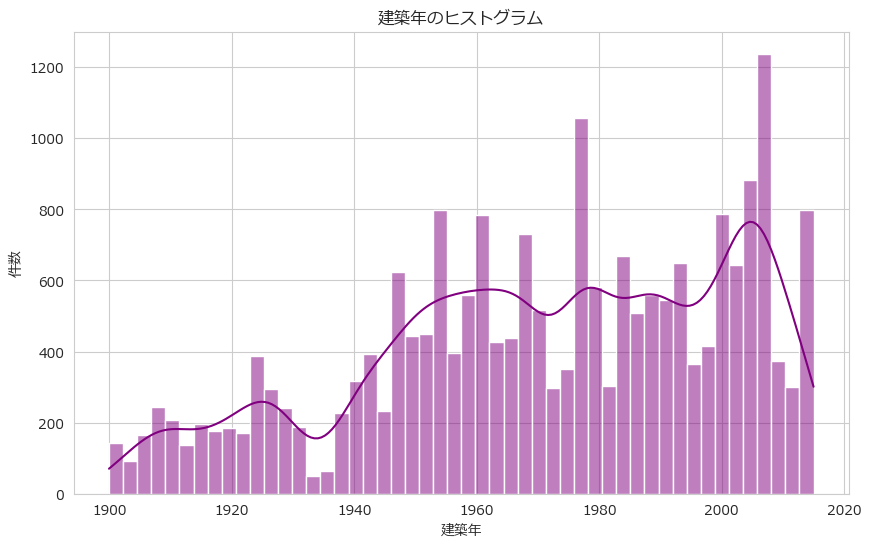

建築年の異常値除外前のデータ件数: 21607
建築年の異常値除外後のデータ件数: 16674
除外した建築年の異常値の件数: 4933


In [5]:
# %%
# 極端な建築年を除外する処理(1950年~2024年)
plt.figure(figsize=(10, 6))
sns.histplot(data['yr_built'], bins=50, kde=True, color='purple')
plt.title("建築年のヒストグラム")
plt.xlabel("建築年")
plt.ylabel("件数")
plt.show()

lower_bound_yr_built = 1950
upper_bound_yr_built = 2024

initial_count = data.shape[0]
data = data[(data['yr_built'] >= lower_bound_yr_built) & (data['yr_built'] <= upper_bound_yr_built)]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"建築年の異常値除外前のデータ件数: {initial_count}")
print(f"建築年の異常値除外後のデータ件数: {filtered_count}")
print(f"除外した建築年の異常値の件数: {removed_count}")


## 5.3 カスタム `whis` による箱ひげ図の表示

このセクションでは、指定した各列に対してカスタム `whis` パラメータを用いた箱ひげ図を表示し、上下限値を計算します。計算された上限値は後続のデータフィルタリングで使用します。

### スクリプト1: 箱ひげ図の表示と上下限値の計算


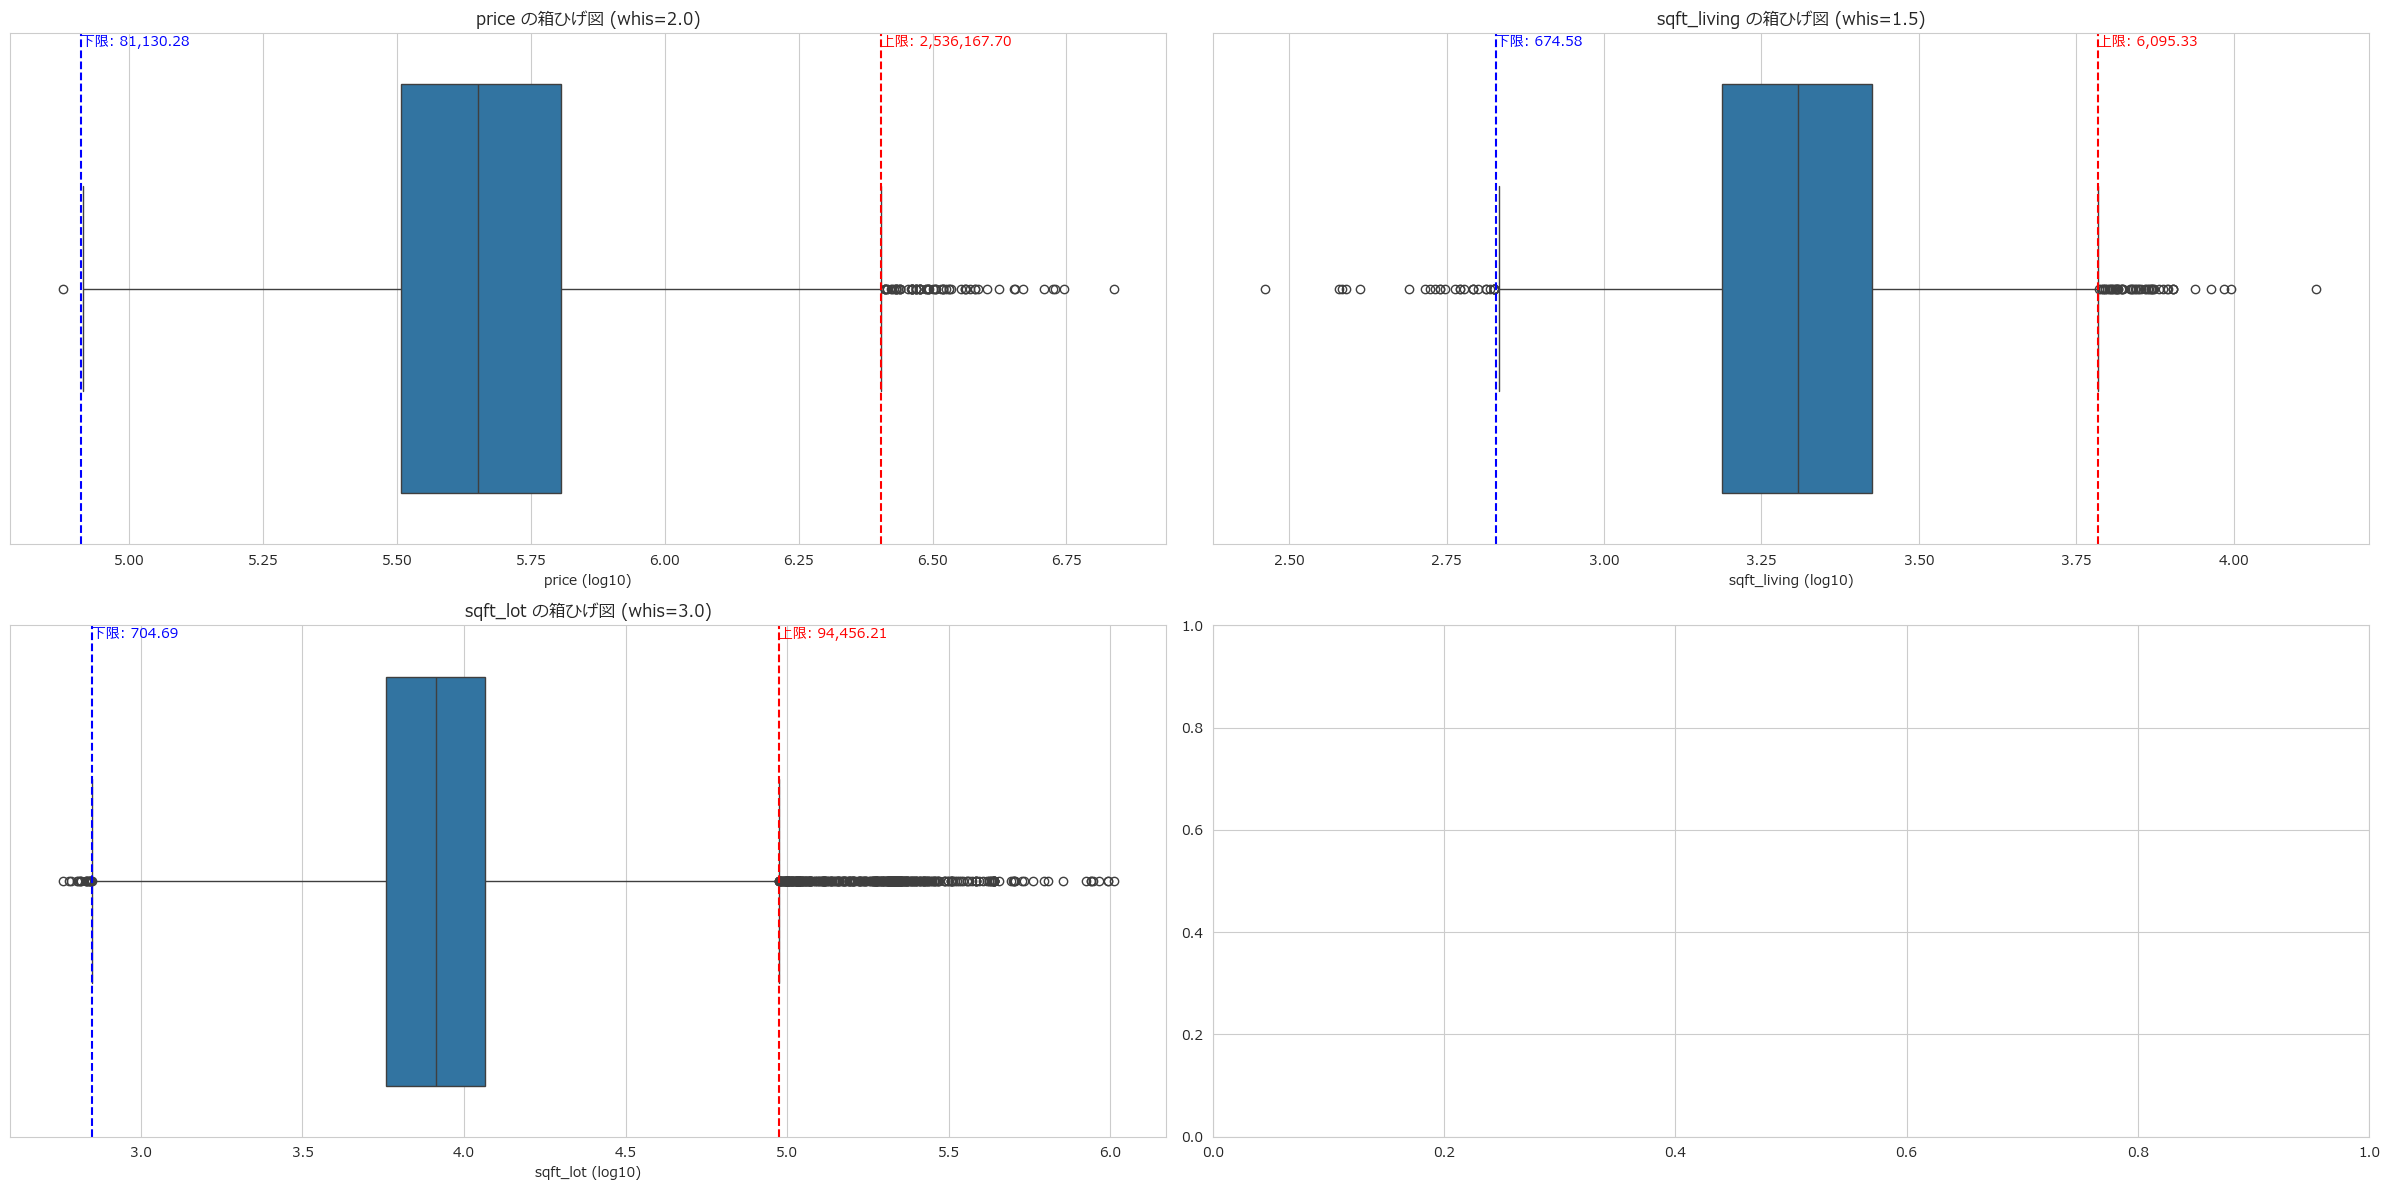

計算された上限値と下限値:
price: 上限 = 2,536,167.70, 下限 = 81,130.28
sqft_living: 上限 = 6,095.33, 下限 = 674.58
sqft_lot: 上限 = 94,456.21, 下限 = 704.69


In [6]:
# %%
# 箱ひげ図を用いて上限値・下限値を推定する関数
def plot_boxplot_custom_whis(df, column, custom_whis=1.5, log_transform=False):
    if log_transform:
        data_transformed = np.log10(df[column])
        xlabel = f"{column} (log10)"
    else:
        data_transformed = df[column]
        xlabel = column
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_transformed, whis=custom_whis)
    plt.title(f"{column} の箱ひげ図 (whis={custom_whis})")
    plt.xlabel(xlabel)
    plt.show()
    
    # IQRを使った外れ値しきい値の計算
    Q1 = data_transformed.quantile(0.25)
    Q3 = data_transformed.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + custom_whis * IQR
    lower_whisker = Q1 - custom_whis * IQR
    
    # 対数変換していた場合は元スケールに戻す
    if log_transform:
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    # 結果表示
    print(f"--- {column} の上限値と下限値 ---")
    if log_transform:
        print(f"上限（対数スケール）: {upper_whisker:.2f}, 下限（対数スケール）: {lower_whisker:.2f}")
        print(f"上限（元スケール）: {upper_limit:,.2f}, 下限（元スケール）: {lower_limit:,.2f}")
    else:
        print(f"上限: {upper_limit:,.2f}, 下限: {lower_limit:,.2f}")
    print()

# カラム毎にwhisパラメータを変えて箱ひげ図表示し、上下限値を計算する
limits = {}
columns_to_plot = [
    {'column': 'price', 'custom_whis': 2.0, 'log_transform': True},
    {'column': 'sqft_living', 'custom_whis': 1.5, 'log_transform': True},
    {'column': 'sqft_lot', 'custom_whis': 3.0, 'log_transform': True},
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))
axes = axes.flatten()

for ax, col_info in zip(axes, columns_to_plot):
    col_name = col_info['column']
    whis_val = col_info['custom_whis']
    log_tf = col_info['log_transform']

    if log_tf:
        data_plot = np.log10(data[col_name])
        xlabel = f"{col_name} (log10)"
    else:
        data_plot = data[col_name]
        xlabel = col_name
    
    sns.boxplot(x=data_plot, whis=whis_val, ax=ax)
    ax.set_title(f"{col_name} の箱ひげ図 (whis={whis_val})")
    ax.set_xlabel(xlabel)

    Q1 = data_plot.quantile(0.25)
    Q3 = data_plot.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + whis_val * IQR
    lower_whisker = Q1 - whis_val * IQR
    
    if log_tf:
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    # 求めた上下限値を記録
    limits[col_name] = {'upper_limit': upper_limit, 'lower_limit': lower_limit}

    # 赤線・青線で上限・下限を可視化
    ax.axvline(upper_whisker, color='red', linestyle='--')
    ax.axvline(lower_whisker, color='blue', linestyle='--')
    ax.text(upper_whisker, ax.get_ylim()[1]*0.95, f'上限: {upper_limit:,.2f}', color='red')
    ax.text(lower_whisker, ax.get_ylim()[1]*0.95, f'下限: {lower_limit:,.2f}', color='blue')

plt.tight_layout()
plt.show()

print("計算された上限値と下限値:")
for column, lim in limits.items():
    print(f"{column}: 上限 = {lim['upper_limit']:,.2f}, 下限 = {lim['lower_limit']:,.2f}")


## 5.4 カスタム `whis` によるデータのフィルタリング

前セクションで計算された各列の上下限値を用いて、データフレームから異常値を除外します。このセクションでは、各列ごとに異なる `whis` パラメータに基づいた上下限値を使用してデータをフィルタリングします。

### スクリプト2: データのフィルタリング


In [7]:
# %%
# 前ステップで求めた上下限値を使って、データをフィルタリングする関数
def filter_data_custom_whis(df, limits):
    initial_count = df.shape[0]
    for column, lim in limits.items():
        df = df[(df[column] >= lim['lower_limit']) & (df[column] <= lim['upper_limit'])]
        print(f"{column} の範囲 {lim['lower_limit']:,.2f} - {lim['upper_limit']:,.2f} でフィルタリング")
    
    filtered_count = df.shape[0]
    removed_count = initial_count - filtered_count
    
    print(f"\nフィルタ前の件数: {initial_count}, フィルタ後の件数: {filtered_count}, 除外数: {removed_count}")
    return df

# データをコピーしてフィルタリング実施
data_filtered = filter_data_custom_whis(df=data.copy(), limits=limits)

display(data_filtered.head())
display(data_filtered.info())


price の範囲 81,130.28 - 2,536,167.70 でフィルタリング
sqft_living の範囲 674.58 - 6,095.33 でフィルタリング
sqft_lot の範囲 704.69 - 94,456.21 でフィルタリング

フィルタ前の件数: 16674, フィルタ後の件数: 16096, 除外数: 578


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   

   yr_renovated  year_sold  month_sold  days_since_2014_01_01  renovated_flag  \
0             0       2014          10                    286               0   
1          1991       2014          12                    343               1   
3             0       2014          12                    343               0   
4             0       2015           2                    414               0   
6             0       2014           6                    178               0   

   years_since_renovation  
0                       0  
1                      23  
3                       0  
4                       0  
6                       0

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 0 to 21612
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    16096 non-null  datetime64[ns]
 1   price                   16096 non-null  int64         
 2   sqft_lot                16096 non-null  int64         
 3   sqft_living             16096 non-null  int64         
 4   grade                   16096 non-null  int64         
 5   lat                     16096 non-null  float64       
 6   long                    16096 non-null  float64       
 7   yr_built                16096 non-null  int64         
 8   yr_renovated            16096 non-null  int64         
 9   year_sold               16096 non-null  int32         
 10  month_sold              16096 non-null  int32         
 11  days_since_2014_01_01   16096 non-null  int64         
 12  renovated_flag          16096 non-null  int32      

None

## 6. 追加の特徴量エンジニアリング

データの品質向上とモデルの性能向上を図るために、追加の特徴量エンジニアリングを実施します。具体的には以下の2つのステップを行います。

1. **物件の築年数 (`age`) の算出**
2. **地域別の特徴量の作成**

これらの特徴量を追加することで、物件の物理的な特性や地理的な位置情報をモデルに反映させ、予測精度の向上を目指します。


### 6.1 物件の築年数 (`age`) の算出

`yr_built`（建築年）と `year_sold`（売却年）から物件の築年数を計算し、新たな特徴量 `age` を作成します。築年数は物件の状態や市場価値に影響を与える重要な要素となるため、モデルにおいて有用な特徴量となります。


### 6.2 地域別の特徴量の作成

`lat`（緯度）と `long`（経度）を用いて、物件の地域をクラスタリングし、地域別のカテゴリ変数を作成します。ここでは、K-Meansクラスタリングを用いて物件を複数の地域グループに分類します。これにより、地理的な特徴をモデルに組み込むことが可能となります。


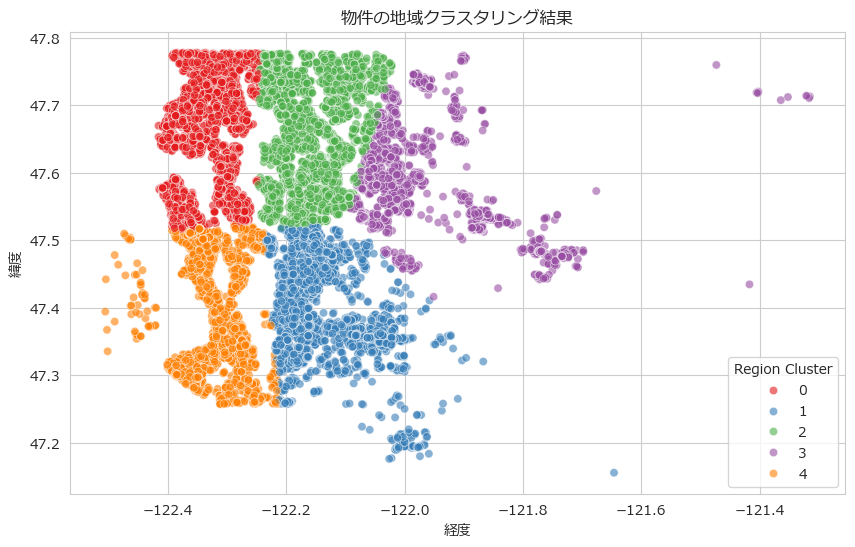

In [8]:
# %%
# 追加の特徴量エンジニアリング
# 1) 築年数: age
data_filtered['age'] = data_filtered['year_sold'] - data_filtered['yr_built']

# 2) 地域クラスタリング(K-Means)でregion_clusterを作成
coordinates = data_filtered[['lat', 'long']]
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_filtered['region_cluster'] = kmeans.fit_predict(coordinates)

# 可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='long', y='lat', hue='region_cluster', data=data_filtered, palette='Set1', alpha=0.6)
plt.title("物件の地域クラスタリング結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='Region Cluster')
plt.show()

# region_clusterをワンホットエンコーディング
region_dummies = pd.get_dummies(data_filtered['region_cluster'], prefix='region')
data_final = pd.concat([data_filtered.drop('region_cluster', axis=1), region_dummies], axis=1)
data_final['region_cluster'] = data_filtered['region_cluster']


## 6.3 地理的外れ値の除外

平均距離: 8.55, 標準偏差: 4.33, 閾値: 17.20

地理的外れ値除外前: 16096, 除外後: 15729, 除外数: 367


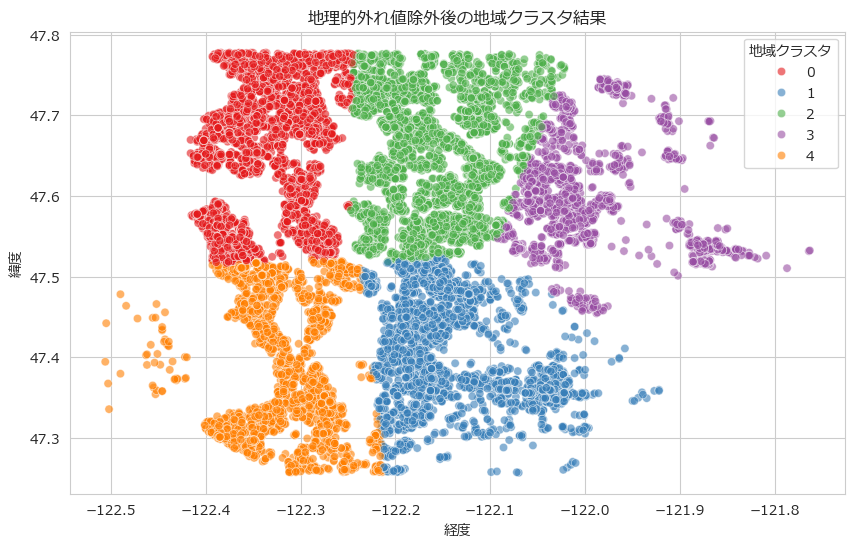

In [9]:
# %%
# 地理的外れ値の除外（クラスタ中心との距離が大きすぎるもの）
def haversine_distance(lat1, lon1, lat2, lon2):
    # Haversineの公式で2点間距離(km)を求める
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (np.sin(dlat/2)**2
         + np.cos(lat1)
         * np.cos(lat2)
         * np.sin(dlon/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371
    return R * c

# クラスタ中心を取得
cluster_centers = kmeans.cluster_centers_

# データ毎に所属クラスタの中心を取得
data_final['cluster_center_lat'] = cluster_centers[data_final['region_cluster'], 0]
data_final['cluster_center_long'] = cluster_centers[data_final['region_cluster'], 1]

# 各点からクラスタ中心までの距離を計算
data_final['distance_to_centroid'] = haversine_distance(
    data_final['lat'], data_final['long'],
    data_final['cluster_center_lat'], data_final['cluster_center_long']
)

dist_mean = data_final['distance_to_centroid'].mean()
dist_std = data_final['distance_to_centroid'].std()
dist_threshold = dist_mean + 2 * dist_std

print(f"平均距離: {dist_mean:.2f}, 標準偏差: {dist_std:.2f}, 閾値: {dist_threshold:.2f}")

# 閾値を超えるものを外れ値として除外
initial_count = data_final.shape[0]
data_final = data_final[data_final['distance_to_centroid'] <= dist_threshold]
filtered_count = data_final.shape[0]
removed_count = initial_count - filtered_count

print(f"\n地理的外れ値除外前: {initial_count}, 除外後: {filtered_count}, 除外数: {removed_count}")

# 不要なカラムを削除
data_final.drop(['cluster_center_lat','cluster_center_long','distance_to_centroid'], axis=1, inplace=True)

# 除外後のクラスタ分布を可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='long', y='lat', hue='region_cluster', data=data_final, palette='Set1', alpha=0.6)
plt.title("地理的外れ値除外後の地域クラスタ結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='地域クラスタ')
plt.show()


### 6.4 リノベーション無し物件はリノベーション済物件と取り扱いを変える
リノベーション無しの物件のデータはリノベーション経過年数が0になっており、リノベーション経過年数が1年のデータとデータとして近くなってしまうが、実際にはそこに大きな違いがある。そのため、リノベーション無しの物件はリノベーション経過年数を0にせず、NaNにする。

In [10]:
# %%
# リノベーション無し物件はyears_since_renovationをNaNに設定
data_final.loc[data_final['renovated_flag'] == 0, 'years_since_renovation'] = np.nan
display(data_final.head())
display(data_final.info())


date   price  sqft_lot  sqft_living  grade   lat    long  yr_built  \
0 2014-10-13  221900      5650         1180      7 47.51 -122.26      1955   
1 2014-12-09  538000      7242         2570      7 47.72 -122.32      1951   
3 2014-12-09  604000      5000         1960      7 47.52 -122.39      1965   
4 2015-02-18  510000      8080         1680      8 47.62 -122.05      1987   
6 2014-06-27  257500      6819         1715      7 47.31 -122.33      1995   

   yr_renovated  year_sold  ...  days_since_2014_01_01  renovated_flag  \
0             0       2014  ...                    286               0   
1          1991       2014  ...                    343               1   
3             0       2014  ...                    343               0   
4             0       2015  ...                    414               0   
6             0       2014  ...                    178               0   

   years_since_renovation  age  region_0  region_1  region_2  region_3  \
0                     NaN   59     False     False     False     False   
1                   23.00   63      True     False     False     False   
3                     NaN   49      True     False     False     False   
4                     NaN   28     False     False     False      True   
6                     NaN   19     False     False     False     False   

   region_4  region_cluster  
0      True               4  
1     False               0  
3     False               0  
4     False               3  
6      True               4  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 15729 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    15729 non-null  datetime64[ns]
 1   price                   15729 non-null  int64         
 2   sqft_lot                15729 non-null  int64         
 3   sqft_living             15729 non-null  int64         
 4   grade                   15729 non-null  int64         
 5   lat                     15729 non-null  float64       
 6   long                    15729 non-null  float64       
 7   yr_built                15729 non-null  int64         
 8   yr_renovated            15729 non-null  int64         
 9   year_sold               15729 non-null  int32         
 10  month_sold              15729 non-null  int32         
 11  days_since_2014_01_01   15729 non-null  int64         
 12  renovated_flag          15729 non-null  int32      

None

## 7. 詳細な探索的データ分析 (EDA)

追加の特徴量エンジニアリングを完了した後、データの詳細な探索的データ分析 (EDA) を実施します。このステップでは、データの傾向やパターン、特徴量間の関係性を深く理解し、予測モデルの構築に向けたインサイトを得ることを目的とします。

以下のサブセクションに分けて分析を行います。

1. **ターゲット変数 (`価格`) の分布確認**
2. **主要特徴量とターゲット変数の関係分析**
3. **相関行列の作成と可視化**
4. **カテゴリ変数の分析**
5. **地域クラスタリングの詳細分析**
6. **特徴量間の関係性の可視化**

---


### 7.1 ターゲット変数 (`価格`) の分布確認

予測対象となる `価格` の分布を確認し、データの偏りや異常値の存在を把握します。価格の分布が偏っている場合、対数変換などの前処理を検討します。


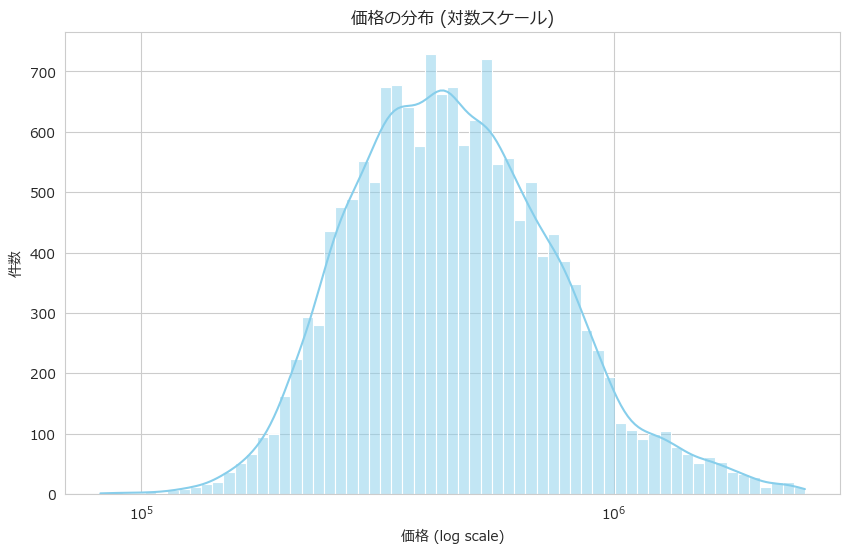

件数         15,729.00
平均        525,135.40
標準偏差      307,233.83
最小         82,000.00
25%       320,000.00
中央値       445,000.00
75%       635,000.00
最大      2,535,000.00
Name: price, dtype: object

In [11]:
# %%
# 価格の分布を対数スケールで可視化
plt.figure(figsize=(10,6))
sns.histplot(data_final['price'], kde=True, log_scale=True, color='skyblue')
plt.title("価格の分布 (対数スケール)")
plt.xlabel("価格 (log scale)")
plt.ylabel("件数")
plt.show()

price_stats = data_final['price'].describe().rename(index=jp_index).apply(lambda x: f"{x:,.2f}")
display(price_stats)


対数グラフにおいてきれいな正規分布に近い形状になっており、このままで問題はなさそう。

### 7.2 主要特徴量とターゲット変数の関係分析

主要な数値特徴量とターゲット変数 `価格` との関係を可視化し、相関の強さやパターンを確認します。これにより、価格に影響を与える可能性のある重要な特徴量を特定します。


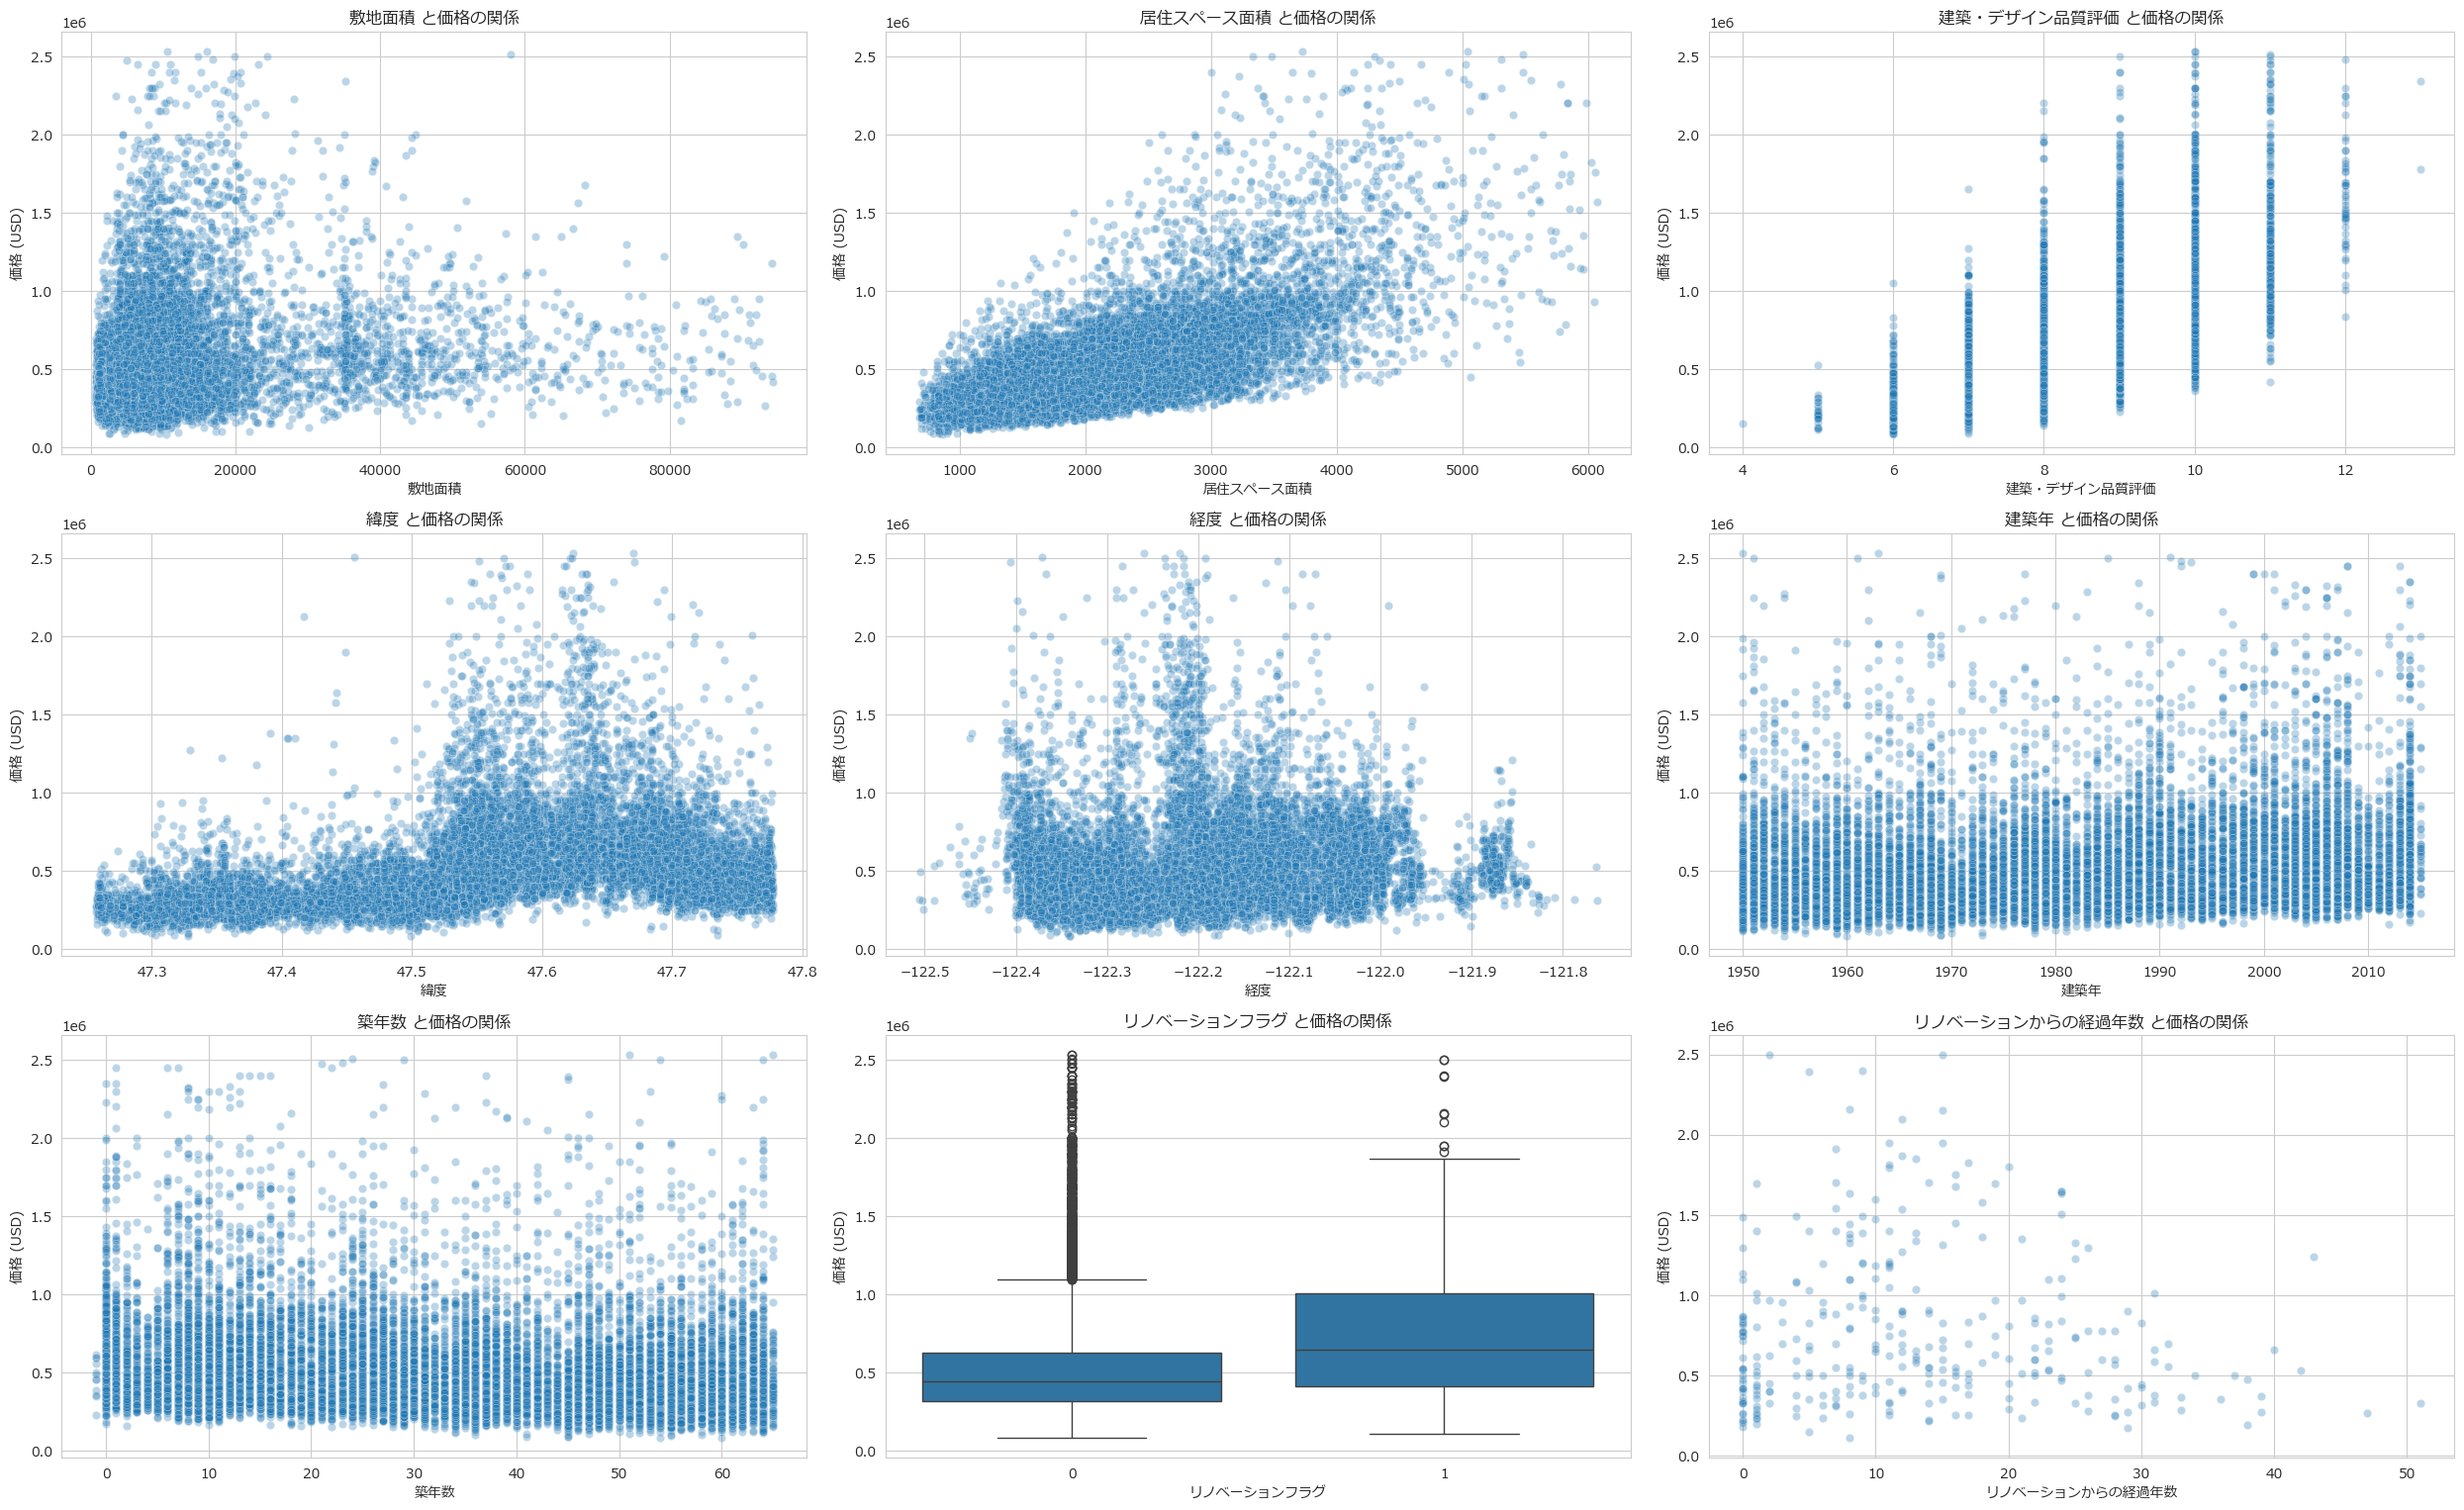

価格との相関係数
建築・デザイン品質評価         0.71
居住スペース面積            0.70
緯度                  0.36
敷地面積                0.18
建築年                 0.16
リノベーションフラグ          0.12
経度                  0.10
リノベーションからの経過年数     -0.05
築年数                -0.16

In [12]:
# %%
# 数値特徴量と価格の関係を可視化
numeric_features = ['sqft_lot','sqft_living','grade','lat','long','yr_built','age','renovated_flag','years_since_renovation']

# 日本語マッピング
feature_jp_map = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

plt.figure(figsize=(25, 20))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    # リノベフラグはboxplot、それ以外はscatterで可視化
    if feature == 'renovated_flag':
        sns.boxplot(x=data_final[feature], y=data_final['price'])
    else:
        sns.scatterplot(x=data_final[feature], y=data_final['price'], alpha=0.3)
    jp_label = feature_jp_map.get(feature, feature)
    plt.title(f"{jp_label} と価格の関係")
    plt.xlabel(jp_label)
    plt.ylabel("価格 (USD)")
plt.tight_layout()
plt.show()

# 相関係数を計算して表示
correlations = {}
for feat in numeric_features:
    correlations[feat] = data_final['price'].corr(data_final[feat])

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['価格との相関係数'])
corr_df.index = corr_df.index.to_series().apply(lambda x: feature_jp_map.get(x, x))
corr_df = corr_df.sort_values('価格との相関係数', ascending=False).round(2)

display(corr_df)


他のデータと極端に離れた外れ値データは少なくなっており、フィルタリングが正しく機能したことがわかる。

### 7.3 相関行列の作成と可視化

数値特徴量間の相関関係を把握するために、相関行列を作成しヒートマップで可視化します。これにより、相関の強いペアや多重共線性の可能性を確認します。


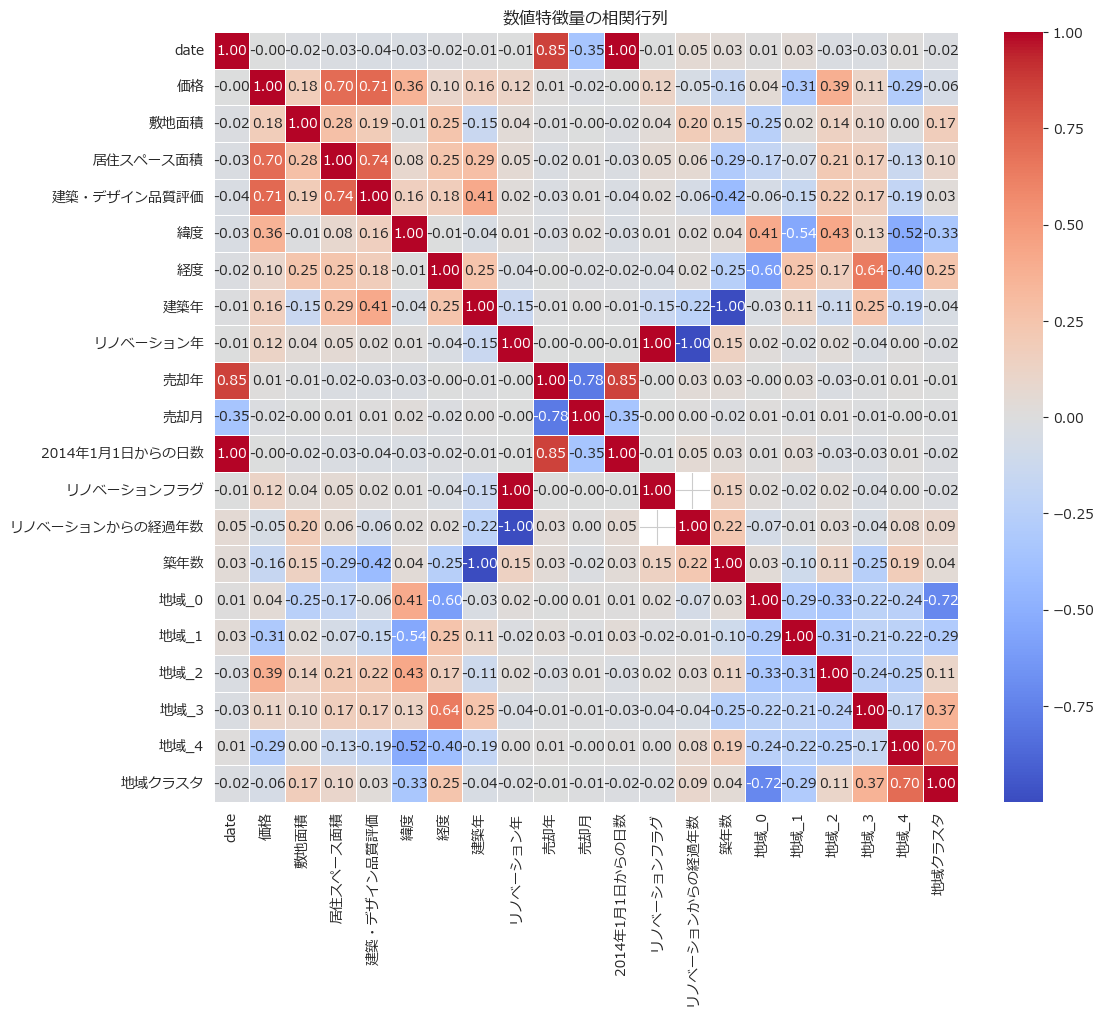

In [13]:
# %%
# 相関行列の作成と可視化
feature_names_jp = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'yr_renovated': 'リノベーション年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数',
    'age': '築年数',
    'region_0': '地域_0',
    'region_1': '地域_1',
    'region_2': '地域_2',
    'region_3': '地域_3',
    'region_4': '地域_4',
    'region_cluster': '地域クラスタ'
}

corr_matrix = data_final.corr()
corr_matrix = corr_matrix.rename(columns=feature_names_jp).rename(index=feature_names_jp)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("数値特徴量の相関行列")
plt.show()


### 7.4 カテゴリ変数の分析

カテゴリ変数である `region_cluster` に基づいて、価格やその他の数値特徴量の分布を比較します。これにより、異なる地域クラスタ間での価格の違いや特徴の違いを確認します。


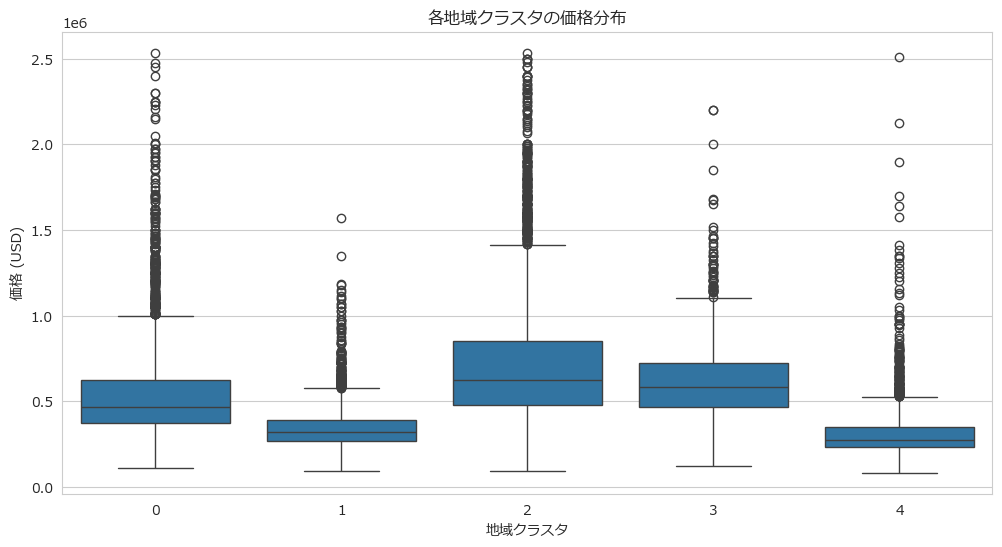

cluster      price
0        0 549,728.24
1        1 345,202.38
2        2 726,091.66
3        3 612,261.32
4        4 315,750.07

In [14]:
# %%
# カテゴリ変数 (region_0〜region_4) の分析（価格分布など）
region_columns = [col for col in data_final.columns if col.startswith('region_') and col != 'region_cluster']
melted = pd.melt(data_final, id_vars='price', value_vars=region_columns, var_name='region', value_name='is_region')
filtered_melted = melted[melted['is_region']]
filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_','').astype(int)

plt.figure(figsize=(12,6))
sns.boxplot(x='cluster', y='price', data=filtered_melted)
plt.title("各地域クラスタの価格分布")
plt.xlabel("地域クラスタ")
plt.ylabel("価格 (USD)")
plt.show()

region_price_mean = filtered_melted.groupby('cluster')['price'].mean().reset_index()
display(region_price_mean)


### 7.5 地域クラスタリングの詳細分析

地域クラスタリングに基づき、各クラスタの特徴を詳細に分析します。具体的には、各クラスタの平均価格、敷地面積、居住スペース面積などを比較し、地域ごとの特性を把握します。


地域クラスタの分布:
region_cluster
2    4115
0    3712
1    3366
4    2387
3    2149
Name: count, dtype: int64

データ型の確認:
region_cluster    int32
price             int64
sqft_lot          int64
sqft_living       int64
age               int64
dtype: object

データ型の再確認:
region_cluster    int32
price             int64
sqft_lot          int64
sqft_living       int64
age               int64
grade             int64
dtype: object


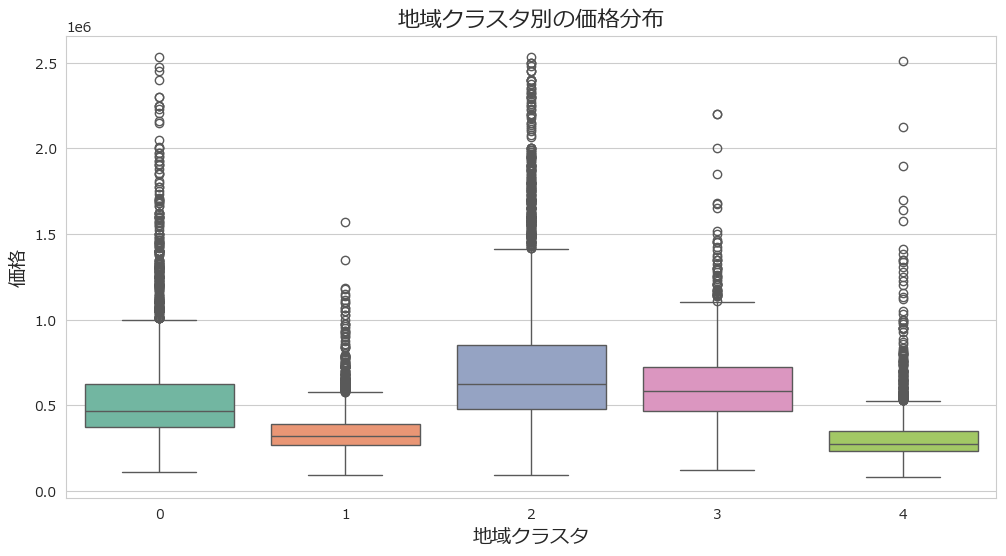


地域クラスタ別の価格統計量:


count       mean        std        min        25%  \
region_cluster                                                        
クラスタ 0         3,712.00 549,728.24 291,160.03 107,000.00 372,165.00   
クラスタ 1         3,366.00 345,202.38 127,841.80  90,000.00 265,225.00   
クラスタ 2         4,115.00 726,091.66 367,256.84  90,000.00 475,000.00   
クラスタ 3         2,149.00 612,261.32 211,521.53 119,500.00 465,000.00   
クラスタ 4         2,387.00 315,750.07 165,887.00  82,000.00 230,000.00   

                      50%        75%          max  
region_cluster                                     
クラスタ 0         467,000.00 625,501.00 2,532,000.00  
クラスタ 1         320,000.00 390,000.00 1,570,000.00  
クラスタ 2         621,000.00 850,000.00 2,535,000.00  
クラスタ 3         583,800.00 720,500.00 2,200,000.00  
クラスタ 4         276,000.00 348,000.00 2,510,000.00

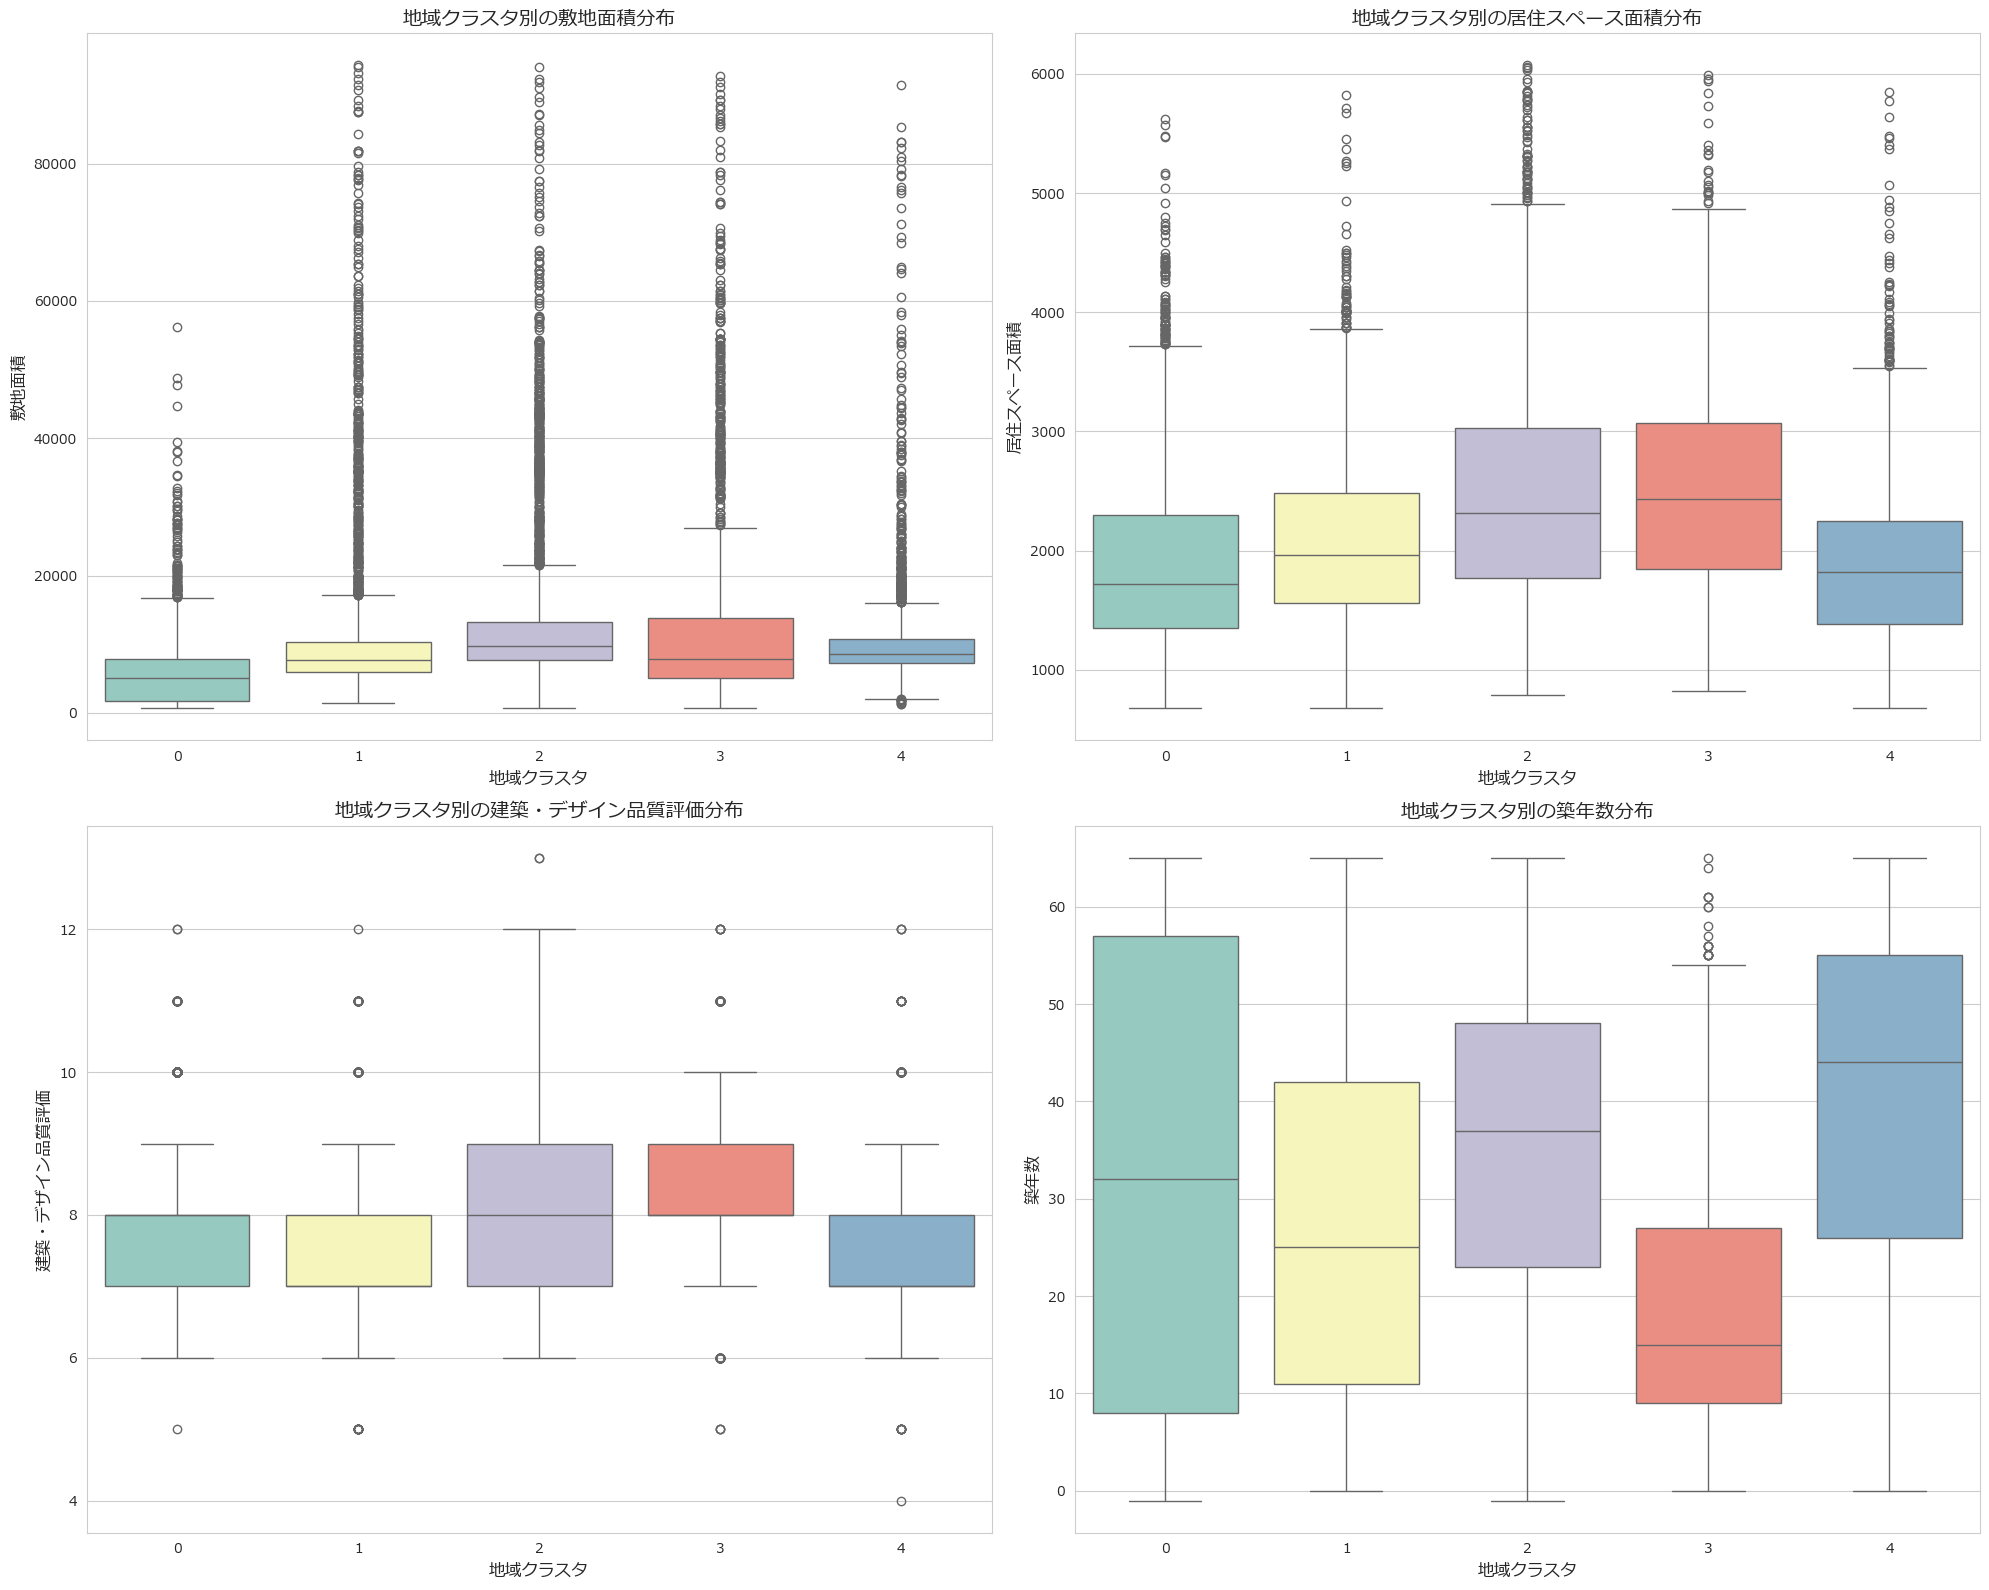


地域クラスタ別の主要特徴量の平均値:


平均価格    平均敷地面積  平均居住スペース面積  平均築年数
region_cluster                                        
クラスタ 0         549,728.24  5,756.86    1,902.25  32.22
クラスタ 1         345,202.38 11,327.87    2,061.28  27.16
クラスタ 2         726,091.66 13,448.07    2,466.65  34.68
クラスタ 3         612,261.32 13,497.82    2,521.01  18.69
クラスタ 4         315,750.07 10,846.02    1,900.41  39.55


地域クラスタ別の価格との相関係数:


region_cluster  敷地面積との相関係数  居住スペース面積との相関係数  建築・デザイン品質評価との相関係数  築年数との相関係数
0              0        0.20            0.72               0.70      -0.08
1              1        0.31            0.77               0.73      -0.36
2              2        0.18            0.75               0.72      -0.28
3              3        0.12            0.80               0.76      -0.23
4              4        0.33            0.65               0.61      -0.18

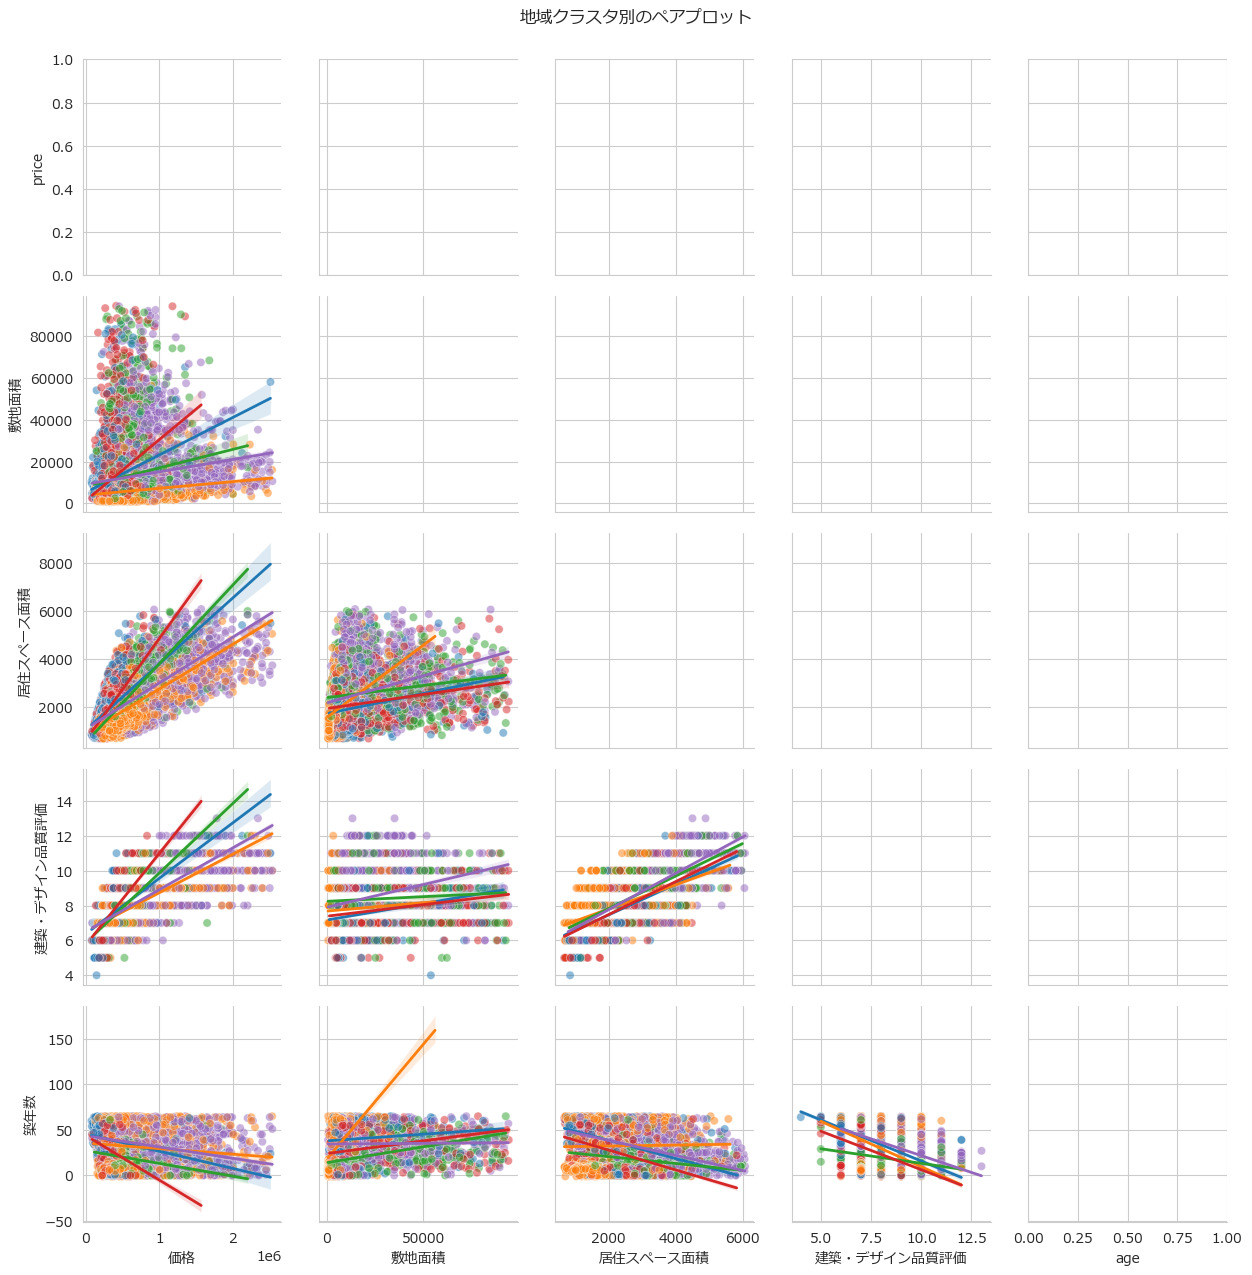

<Figure size 3000x500 with 0 Axes>

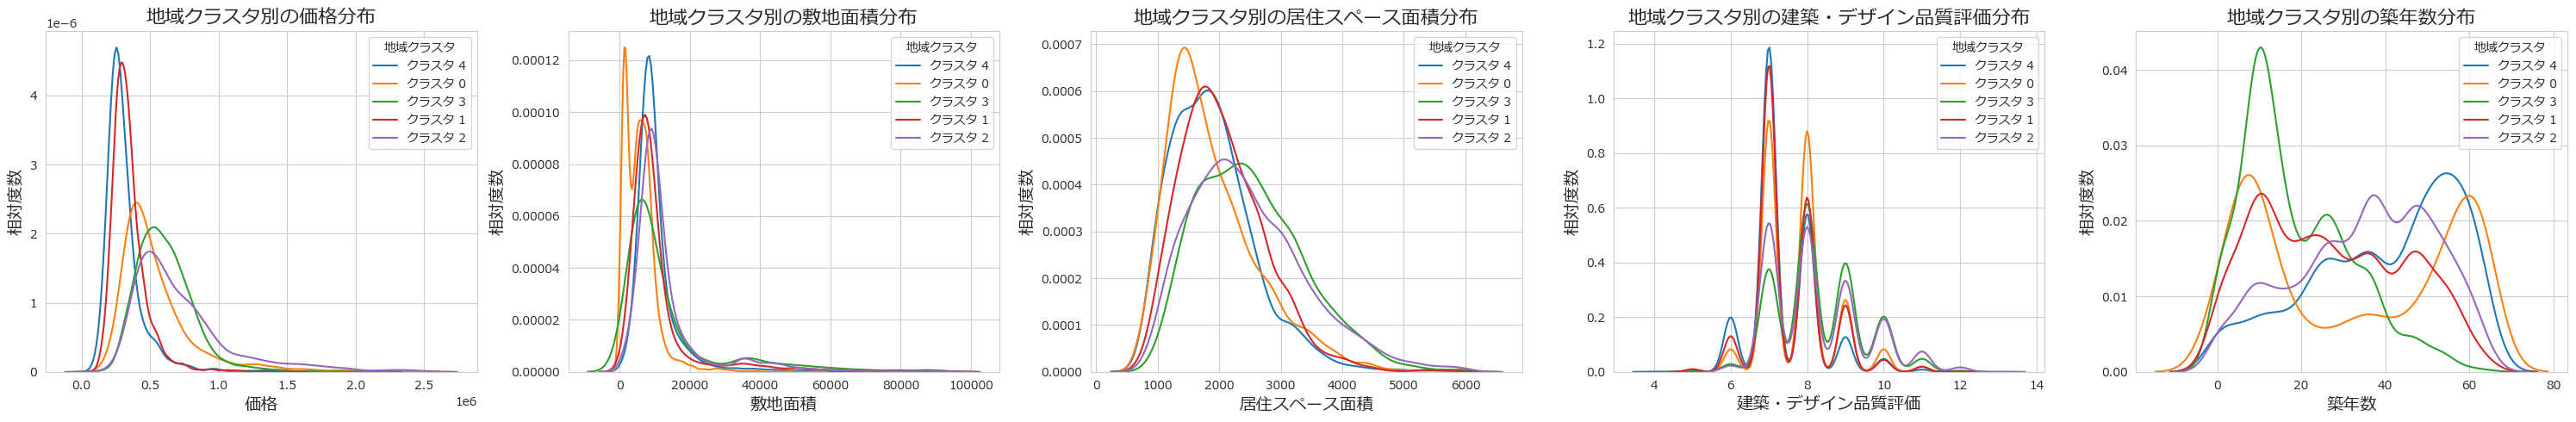

In [15]:
# ----------------------------------
# 1. データの確認・データ型の変換など
# ----------------------------------
print("地域クラスタの分布:")
print(data_final['region_cluster'].value_counts())

print("\nデータ型の確認:")
print(data_final[['region_cluster', 'price', 'sqft_lot', 'sqft_living', 'age']].dtypes)

# region_cluster が数値型でない場合は変換
if not pd.api.types.is_numeric_dtype(data_final['region_cluster']):
    data_final['region_cluster'] = pd.to_numeric(data_final['region_cluster'], errors='coerce')

# 後続の分析で使用するカラム群
numeric_columns = ['price', 'sqft_lot', 'sqft_living', 'age']

# 集計対象の数値カラムをすべて数値型に変換
for col in numeric_columns:
    data_final[col] = pd.to_numeric(data_final[col], errors='coerce')

# 'grade' カラムがある場合も数値型に変換する
if 'grade' in data_final.columns and not pd.api.types.is_numeric_dtype(data_final['grade']):
    data_final['grade'] = pd.to_numeric(data_final['grade'], errors='coerce')

print("\nデータ型の再確認:")
print(data_final[['region_cluster'] + numeric_columns + ['grade']].dtypes)

# ----------------------------------
# 2. 価格の分布比較（クラスタごと）
# ----------------------------------
if 'price' in data_final.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='region_cluster', y='price', data=data_final, palette='Set2')
    plt.title("地域クラスタ別の価格分布", fontsize=16)
    plt.xlabel("地域クラスタ", fontsize=14)
    plt.ylabel("価格", fontsize=14)
    plt.show()
else:
    print("Error: 'price' column is missing from data_final. Please ensure it is included in the DataFrame.")

# クラスタごとの価格の基本統計量
price_stats = data_final.groupby('region_cluster')['price'].describe().round(2)
price_stats = price_stats.rename(index=lambda x: f"クラスタ {int(x)}")
print("\n地域クラスタ別の価格統計量:")
display(price_stats)

# ----------------------------------
# 3. その他の主要な数値特徴量の分布比較（boxplot）
# ----------------------------------
numeric_features_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

plt.figure(figsize=(20, 16))
for i, (feature, feature_japanese) in enumerate(numeric_features_jp.items(), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='region_cluster', y=feature, data=data_final, palette='Set3')
    plt.title(f"地域クラスタ別の{feature_japanese}分布", fontsize=14)
    plt.xlabel("地域クラスタ", fontsize=12)
    plt.ylabel(feature_japanese, fontsize=12)
plt.tight_layout()
plt.show()

# 各クラスタごとの平均値
mean_values = data_final.groupby('region_cluster')[['price','sqft_lot','sqft_living','age']].mean().round(2)
mean_values = mean_values.rename(columns={
    'price': '平均価格',
    'sqft_lot': '平均敷地面積',
    'sqft_living': '平均居住スペース面積',
    'age': '平均築年数'
})
mean_values = mean_values.rename(index=lambda x: f"クラスタ {int(x)}")
print("\n地域クラスタ別の主要特徴量の平均値:")
display(mean_values)

# ----------------------------------
# 4. 地域クラスタ別の相関係数 (参考: リノベーションフラグの処理)
# ----------------------------------
# 相関計算対象に 'grade' を含める場合は、明示的に列を指定
cols_for_corr = ['price', 'sqft_lot', 'sqft_living', 'grade', 'age']

# クラスタ番号が欠損している行を除外しておく (KeyError 防止対策)
data_final = data_final.dropna(subset=['region_cluster'])

# 相関行列を計算
corr_result = data_final.groupby('region_cluster')[cols_for_corr].corr()

# 'price' の行を除外し、列として展開
# （階層インデックスの level=1 を展開し、'price' 列だけ取得）
corr_cluster = corr_result[corr_result.index.get_level_values(1) != 'price'].unstack(level=1)['price'].round(2)

# reset_indexしてカラムを展開
corr_cluster = corr_cluster.reset_index()

# カラム名をわかりやすく変更
# [region_cluster, sqft_lot, sqft_living, grade, age] の順になる
corr_cluster.columns = [
    'region_cluster', 
    '敷地面積との相関係数', 
    '居住スペース面積との相関係数', 
    '建築・デザイン品質評価との相関係数', 
    '築年数との相関係数'
]

# 地域クラスタを「クラスタX」にマッピング
corr_cluster['region_cluster'] = corr_cluster['region_cluster'].astype(int).astype(str).replace(
    {k: f"クラスタ {int(k)}" for k in data_final['region_cluster'].unique()}
)

print("\n地域クラスタ別の価格との相関係数:")
display(corr_cluster)

# ----------------------------------
# 5. ペアプロット (地域クラスタを hue として重ね描き)
# ----------------------------------
data_final['region_cluster_cat'] = data_final['region_cluster'].astype(str)

# 色の選定（クラスタ数に応じて自動調整）
num_clusters = data_final['region_cluster_cat'].nunique()
palette = sns.color_palette("tab10", n_colors=num_clusters)

# 英語の特徴量名を日本語にマッピング
feature_names_jp = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

g = sns.PairGrid(
    data_final, 
    vars=['price', 'sqft_lot', 'sqft_living', 'grade', 'age'], 
    hue='region_cluster_cat', 
    palette=palette,
    height=2.5
)
g.map_lower(sns.scatterplot, alpha=0.5)

# 下三角部分に回帰線を追加
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if j < i:  # 下三角部分のみ
            ax = g.axes[i, j]
            if ax is not None:
                x_col = g.x_vars[j]
                y_col = g.y_vars[i]
                for cluster_label, color in zip(data_final['region_cluster_cat'].unique(), palette):
                    subset = data_final[data_final['region_cluster_cat'] == cluster_label]
                    sns.regplot(
                        x=x_col, 
                        y=y_col,
                        data=subset, 
                        scatter=False, 
                        ax=ax, 
                        color=color, 
                        line_kws={'linewidth':2}
                    )
                # 軸ラベルを日本語に設定
                ax.set_xlabel(feature_names_jp.get(x_col, x_col), fontsize=10)
                ax.set_ylabel(feature_names_jp.get(y_col, y_col), fontsize=10)

plt.suptitle("地域クラスタ別のペアプロット", y=1.02)
plt.show()

# ----------------------------------
# 6. 各数値特徴量の相対度数線グラフ (地域クラスタごとの重ね描き)
# ----------------------------------
features_to_plot = ['price', 'sqft_lot', 'sqft_living', 'grade', 'age']
features_jp = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'age': '築年数'
}

plt.figure(figsize=(6*len(features_to_plot), 5))

for ax, feature in zip(plt.subplots(1, len(features_to_plot), figsize=(6*len(features_to_plot), 5))[1], features_to_plot):
    for cluster_label, color in zip(data_final['region_cluster_cat'].unique(), palette):
        subset = data_final[data_final['region_cluster_cat'] == cluster_label]
        sns.kdeplot(
            subset[feature],
            label=f"クラスタ {cluster_label}",
            color=color,
            linewidth=1.5,
            ax=ax
        )
    ax.set_title(f"地域クラスタ別の{features_jp.get(feature, feature)}分布", fontsize=16)
    ax.set_xlabel(features_jp.get(feature, feature), fontsize=14)
    ax.set_ylabel("相対度数", fontsize=14)
    ax.legend(title="地域クラスタ")

plt.tight_layout()
plt.show()


各地域ごとにデータの特性の違いがありそうで、地域ごとに分けた予測モデルを作成する必要がありそう。

### 7.6 リノベーションの有無によるデータ特性の違いを確認

リノベーションフラグの分布:
renovated_flag
0    15418
1      311
Name: count, dtype: int64


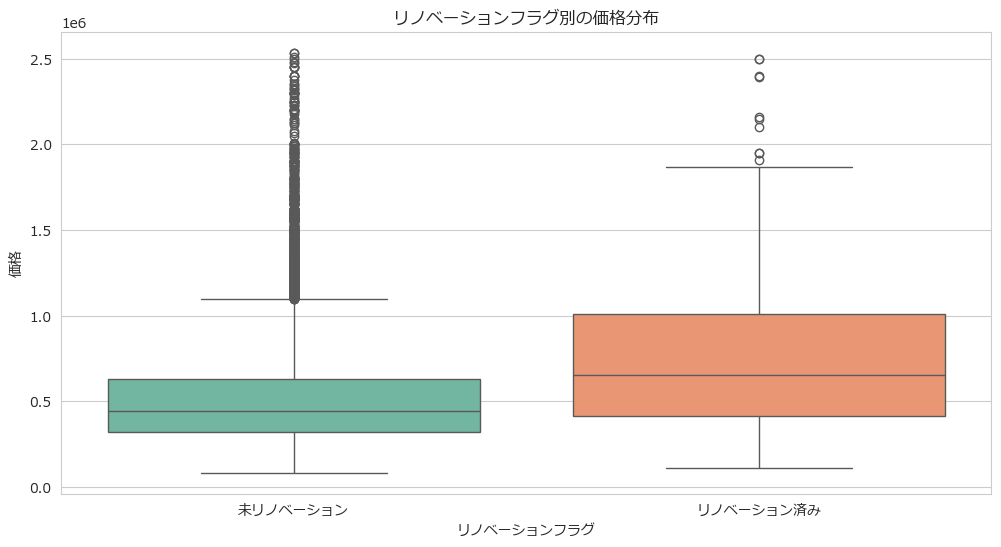

count       mean        std        min        25%  \
renovated_flag_cat                                                         
リノベーション済み             311.00 780,964.00 489,311.26 110,000.00 412,500.00   
未リノベーション           15,418.00 519,975.02 300,225.89  82,000.00 320,000.00   

                          50%          75%          max  
renovated_flag_cat                                       
リノベーション済み          650,000.00 1,007,000.00 2,500,000.00  
未リノベーション           442,500.00   630,000.00 2,535,000.00

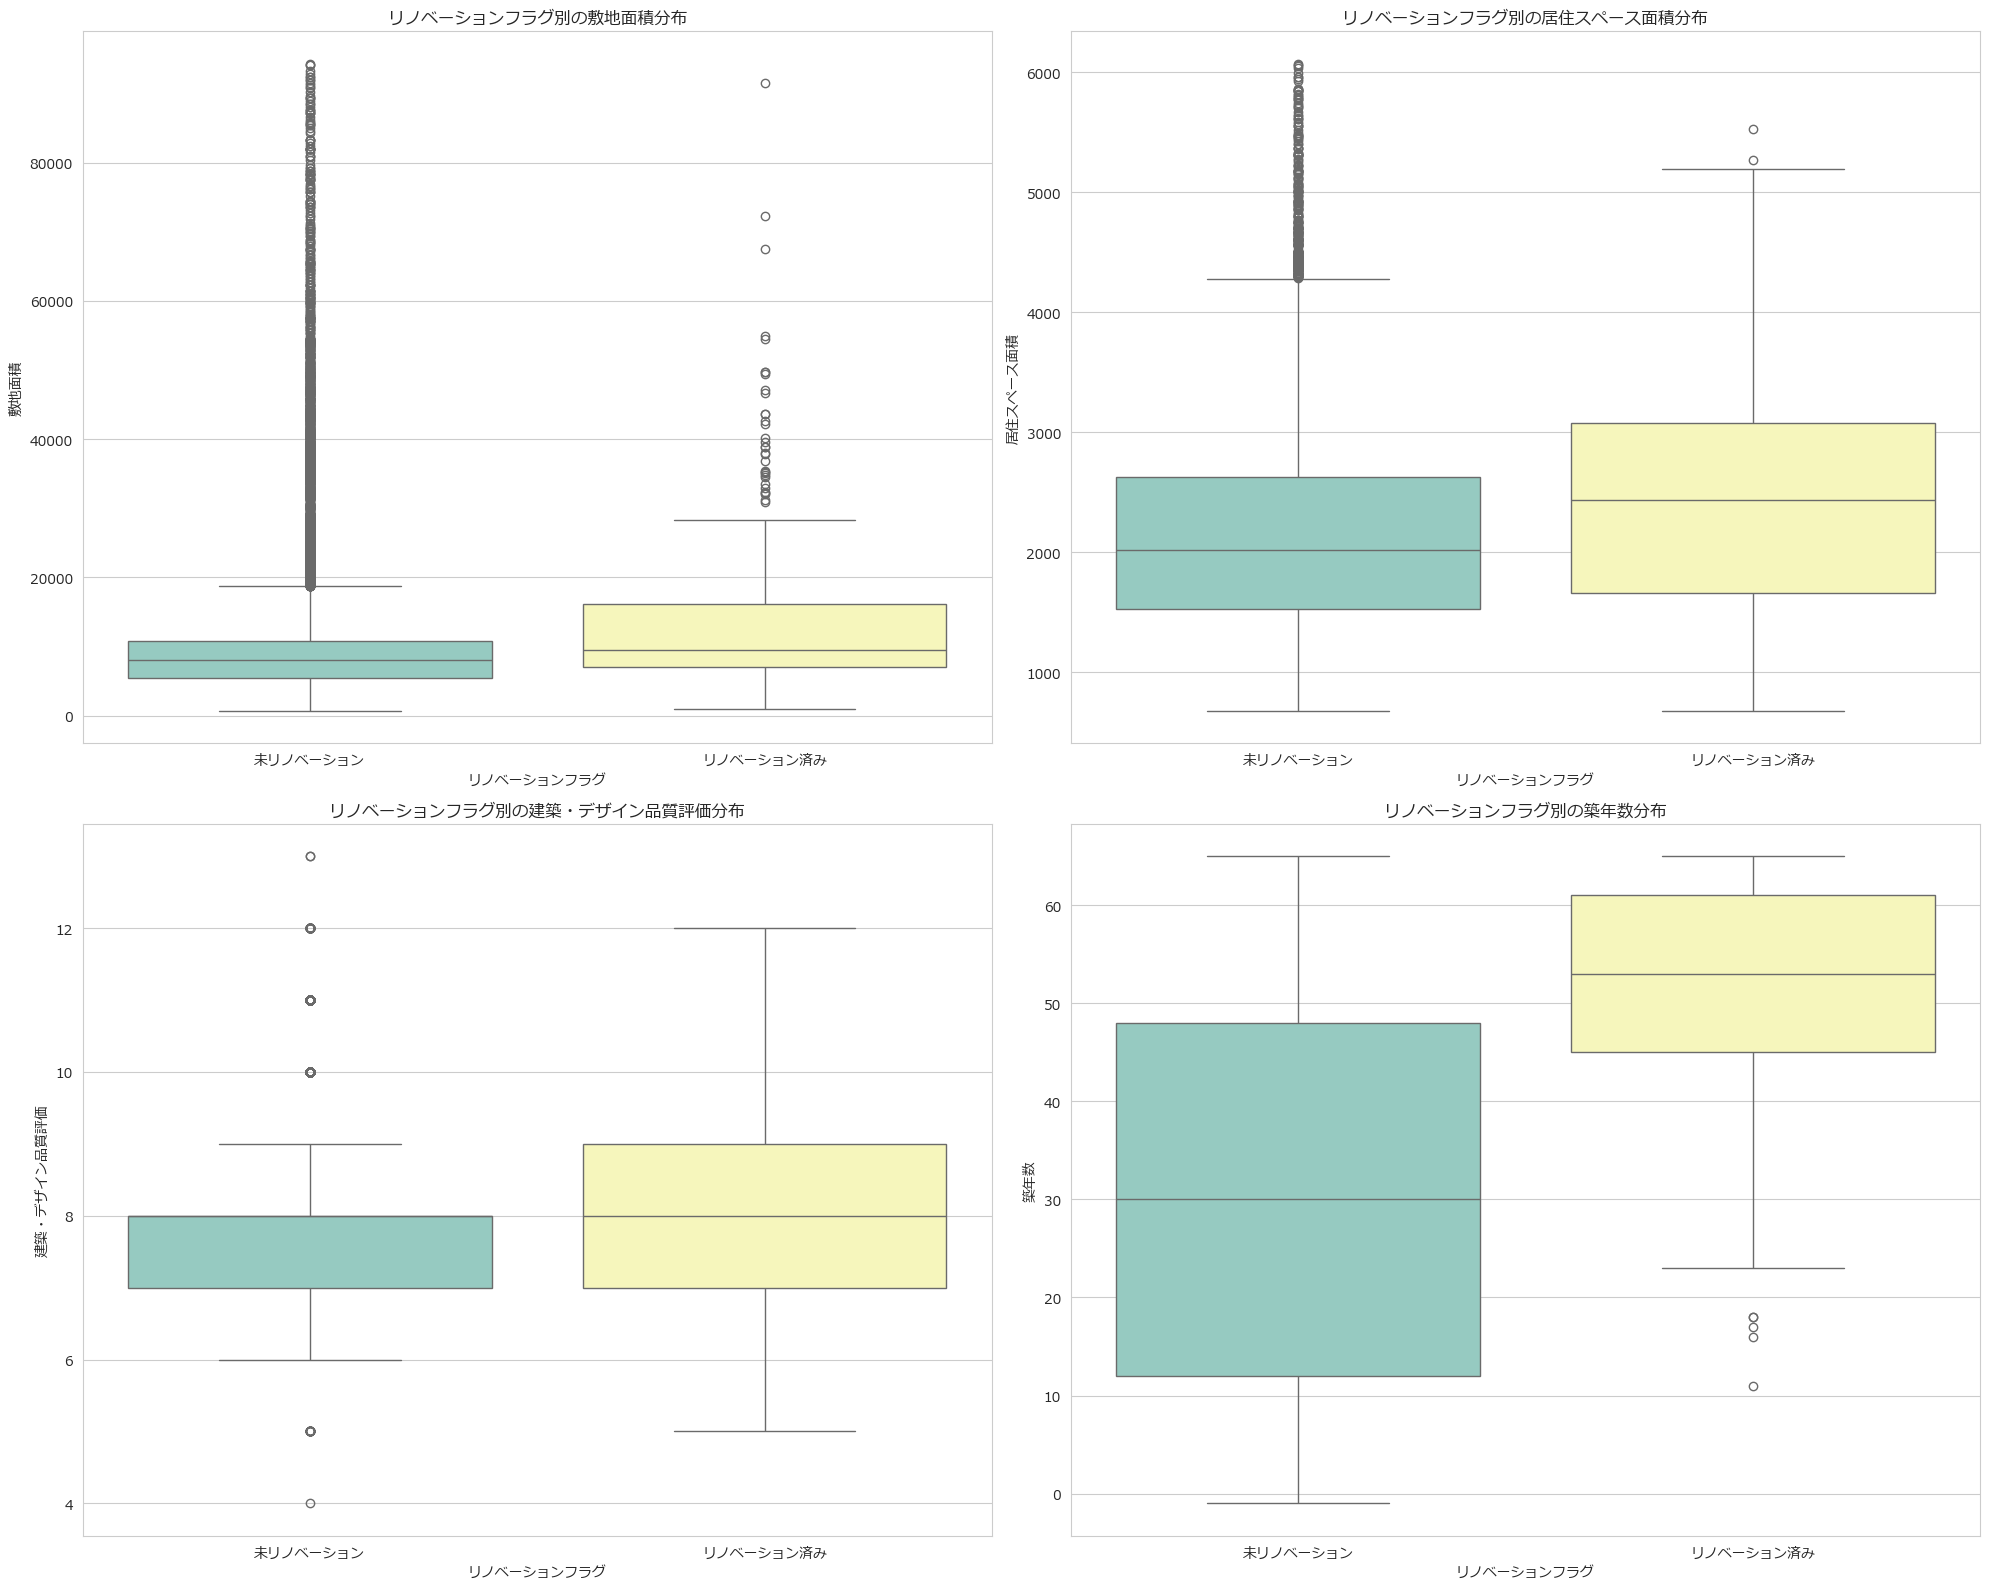

sqft_lot  sqft_living  grade   age
renovated_flag_cat                                    
リノベーション済み          13,877.10     2,454.83   8.03 51.23
未リノベーション           10,728.91     2,162.42   7.85 30.64

In [16]:
# %%
# リノベーションフラグの分布可視化
print("リノベーションフラグの分布:")
print(data_final['renovated_flag'].value_counts())

renovation_mapping = {0: '未リノベーション', 1: 'リノベーション済み'}
data_final['renovated_flag_cat'] = data_final['renovated_flag'].map(renovation_mapping)

plt.figure(figsize=(12,6))
sns.boxplot(x='renovated_flag_cat', y='price', data=data_final, palette='Set2')
plt.title("リノベーションフラグ別の価格分布")
plt.xlabel("リノベーションフラグ")
plt.ylabel("価格")
plt.show()

price_stats_reno = data_final.groupby('renovated_flag_cat')['price'].describe().round(2)
display(price_stats_reno)

# リノベーションフラグ別に主要特徴量を比較
numeric_features = ['sqft_lot','sqft_living','grade','age']
plt.figure(figsize=(20, 16))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='renovated_flag_cat', y=feature, data=data_final, palette='Set3')
    plt.title(f"リノベーションフラグ別の{feature_jp_map[feature]}分布")
    plt.xlabel("リノベーションフラグ")
    plt.ylabel(feature_jp_map[feature])
plt.tight_layout()
plt.show()

mean_vals = data_final.groupby('renovated_flag_cat')[numeric_features].mean().round(2)
display(mean_vals)


未リノベーションの物件とリノベーション済の物件でデータの特性の違いがあり、これによって分析を分けて行うべきと考えられる。

### 7.7 特徴量間の関係性の可視化

選定した主要特徴量間の関係性をペアプロットや散布図行列で可視化し、複数の特徴量間の相互作用やパターンを確認します。


<Figure size 1500x1500 with 0 Axes>

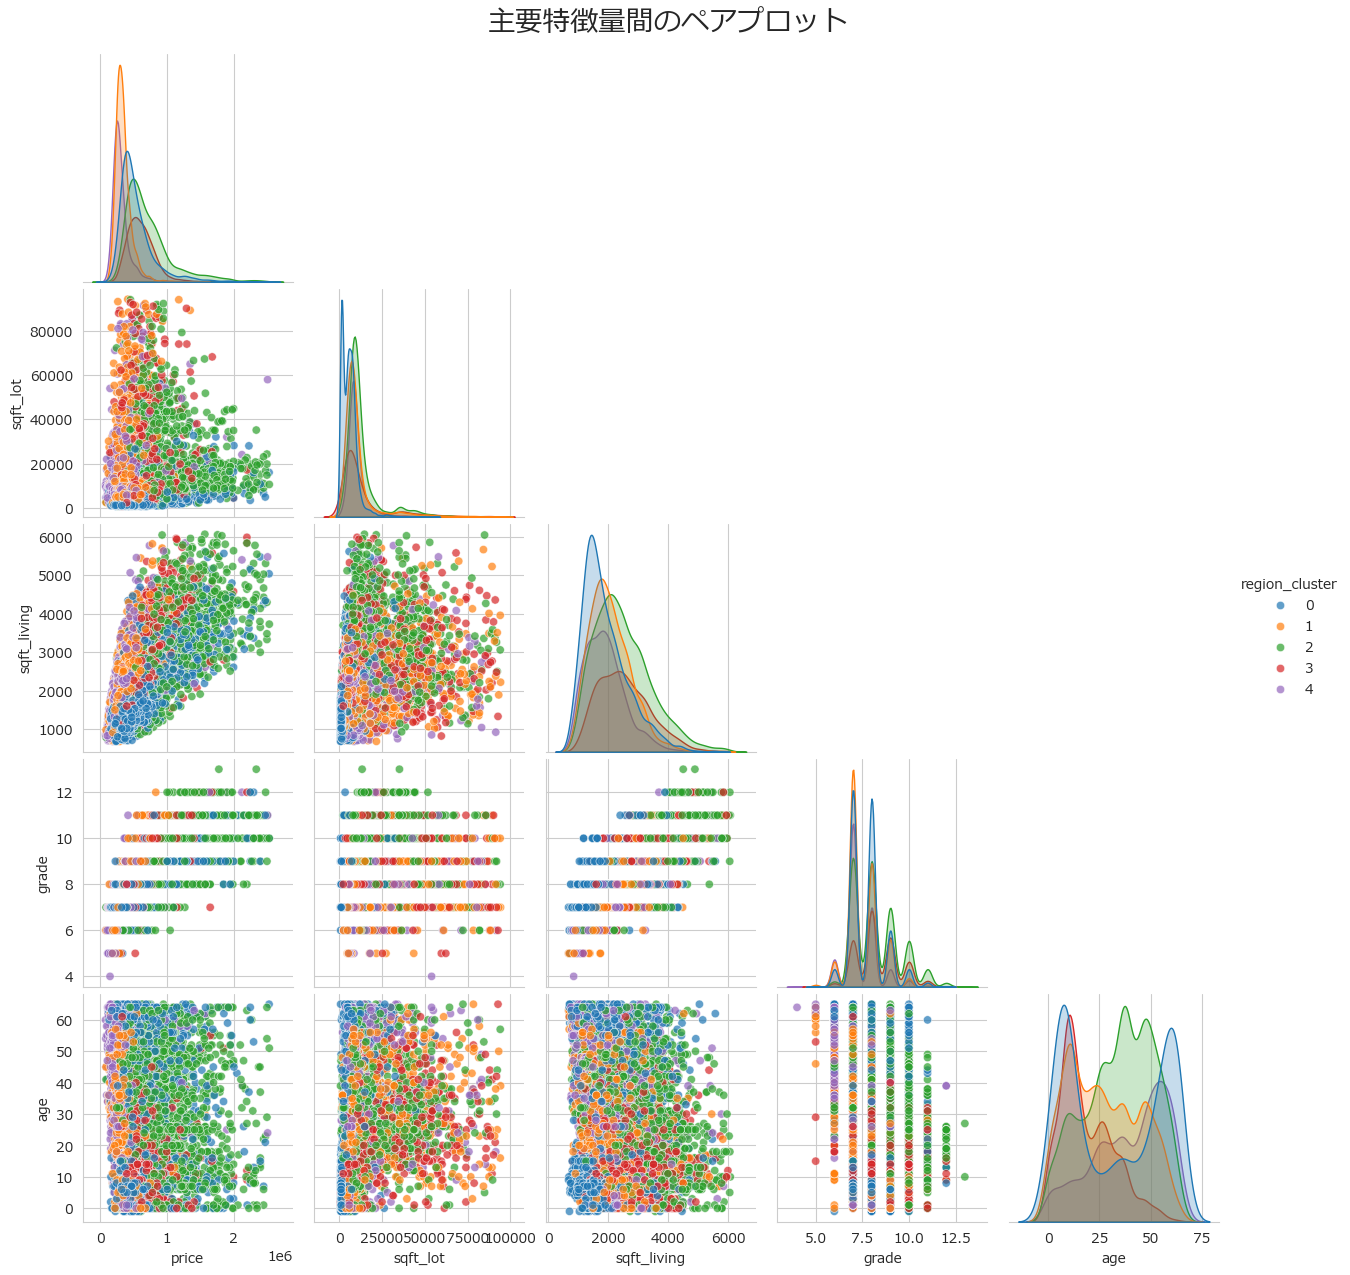

In [17]:
# %%
# 複数数値特徴量間の関係をペアプロットで可視化
label_dict = {
    'price': '価格',
    'sqft_lot': '敷地面積 (平方フィート)',
    'sqft_living': '居住スペース面積 (平方フィート)',
    'grade': '建築・デザイン品質評価',
    'age': '築年数',
    'region_cluster': '地域クラスタ'
}

plt.figure(figsize=(15,15))
sns.pairplot(
    data_final, 
    vars=['price','sqft_lot','sqft_living','grade','age'], 
    hue='region_cluster',
    palette='tab10',  # より区別しやすいカラーパレットに変更
    diag_kind='kde', 
    corner=True, 
    plot_kws={'alpha':0.7}  # 透明度を調整
)
plt.suptitle("主要特徴量間のペアプロット", y=1.02, fontsize=20)
plt.show()


# 8. 地域クラスタとリノベーション有無による価格予測モデル

前セクションでの分析結果から、物件の所在する **地域クラスタ**（`region_cluster`）と **リノベーション有無**（`renovated_flag`）によって物件の価格特性が大きく異なることが示唆されました。  
本セクションでは、これら 2 つの要素によってデータを細分化し、**XGBoost** を用いた価格予測モデルを構築・評価します。

---

## 8.1 データのサブセット分割

- **地域クラスタ**: `region_cluster` (0 〜 4)
- **リノベーション有無**: `renovated_flag` (0:未リノベーション, 1:リノベーション済み)

この 2 軸の組み合わせ (例: クラスタ0 & リノベ無し, クラスタ0 & リノベ有り, ..., クラスタ4 & リノベ無し) ごとに、以下のステップで予測モデルを作成します。

1. 対象データの抽出  
2. 学習データとテストデータへの分割  
3. XGBoost モデルの学習  
4. 評価指標 (RMSE, MAE, R² など) の算出

各モデルのパフォーマンスを比較し、予測精度の高い組み合わせや、今後の改善方針を考察します。

以下では、データの分割と学習に用いる準備を行います。


## 8.2 XGBoost モデル構築の流れ

1. **サブセット抽出**  
   `region_cluster` のユニーク値 (0,1,2,3,4) と `renovated_flag` のユニーク値 (0,1) の組み合わせごとにサブセットを作成。

2. **学習データとテストデータへの分割**  
   - `train_test_split(test_size=0.2, random_state=42)` などの設定でデータ分割を行う。

3. **XGBoost モデル構築**  
   - ハイパーパラメータチューニングは `GridSearchCV` または `RandomizedSearchCV` を使用。  
   - 最適なハイパーパラメータを見つけた後、モデルを再学習。

4. **予測精度評価**  
   - 予測結果と実測値を用いて、MAE (Mean Absolute Error)、RMSE (Root Mean Squared Error)、R² (決定係数) を算出。

5. **結果を保存**  
   - 組み合わせ (地域クラスタ, リノベーション有無) と 評価指標の結果 をテーブル化して比較。

以下のコードでは、この一連の流れをループ処理で一括実行します。


In [18]:
# %%
results_list_1 = []

# モデル1用のデータ
df_model_1 = data_final.copy()
model_cols_1 = [
    'price','sqft_living','sqft_lot','grade','age',
    'renovated_flag','years_since_renovation','region_cluster'
]
df_model_1 = df_model_1[model_cols_1]

# クラスタ・リノベーションフラグ一覧を取得
unique_clusters_1 = df_model_1['region_cluster'].unique()
unique_renovation_flags_1 = df_model_1['renovated_flag'].unique()

# パラメータグリッド例 (XGBoost)
param_grid_1 = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

# 学習結果を格納する辞書
best_models_1 = {}   # {(cluster, reno_flag): xgb_model, ...}
split_data_1 = {}    # {(cluster, reno_flag): (X_train, X_test, y_train, y_test), ...}

for cluster_id in sorted(unique_clusters_1):
    for reno_flag in sorted(unique_renovation_flags_1):
        subset_df = df_model_1[
            (df_model_1['region_cluster'] == cluster_id) &
            (df_model_1['renovated_flag'] == reno_flag)
        ]
        
        if len(subset_df) < 10:
            print(f"[INFO] クラスタ{cluster_id}, リノベ{reno_flag}: データ件数 {len(subset_df)} < 10 -> スキップ")
            continue
        
        # X, y の用意
        X = subset_df.drop('price', axis=1).drop(['region_cluster','renovated_flag'], axis=1)
        X['years_since_renovation'] = X['years_since_renovation'].fillna(0)
        y = subset_df['price']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        grid_search = GridSearchCV(
            estimator=xgb_reg,
            param_grid=param_grid_1,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_model.fit(X_train, y_train)
        
        # テストデータで評価
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results_list_1.append({
            'region_cluster': cluster_id,
            'renovated_flag': reno_flag,
            'num_samples': len(subset_df),
            'best_params': grid_search.best_params_,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        
        # 学習済みモデルとデータを辞書に格納
        best_models_1[(cluster_id, reno_flag)] = best_model
        split_data_1[(cluster_id, reno_flag)] = (X_train, X_test, y_train, y_test)
        
        print(f"[DONE] クラスタ{cluster_id}, リノベ{reno_flag} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

results_df_1 = pd.DataFrame(results_list_1).sort_values('R2', ascending=False)
display(results_df_1)


[DONE] クラスタ0, リノベ0 -> RMSE: 141738.94, MAE: 100118.38, R2: 0.729
[DONE] クラスタ0, リノベ1 -> RMSE: 350117.26, MAE: 263932.62, R2: 0.527
[DONE] クラスタ1, リノベ0 -> RMSE: 64457.70, MAE: 44812.02, R2: 0.727
[DONE] クラスタ1, リノベ1 -> RMSE: 95019.75, MAE: 74477.24, R2: 0.444
[DONE] クラスタ2, リノベ0 -> RMSE: 189708.10, MAE: 127088.71, R2: 0.661
[DONE] クラスタ2, リノベ1 -> RMSE: 403899.67, MAE: 308912.65, R2: 0.572
[DONE] クラスタ3, リノベ0 -> RMSE: 118558.41, MAE: 70679.83, R2: 0.722
[DONE] クラスタ3, リノベ1 -> RMSE: 64685.57, MAE: 57614.02, R2: -1.487
[DONE] クラスタ4, リノベ0 -> RMSE: 116730.43, MAE: 58246.07, R2: 0.465
[DONE] クラスタ4, リノベ1 -> RMSE: 137756.47, MAE: 111942.65, R2: 0.449


region_cluster  renovated_flag  num_samples  \
0               0               0         3618   
2               1               0         3316   
6               3               0         2135   
4               2               0         4010   
5               2               1          105   
1               0               1           94   
8               4               0         2339   
9               4               1           48   
3               1               1           50   
7               3               1           14   

                                         best_params       RMSE        MAE  \
0  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 141,738.94 100,118.38   
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  64,457.70  44,812.02   
6  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 118,558.41  70,679.83   
4  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 189,708.10 127,088.71   
5  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti... 403,899.67 308,912.65   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 350,117.26 263,932.62   
8  {'learning_rate': 0.01, 'max_depth': 5, 'n_est... 116,730.43  58,246.07   
9  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti... 137,756.47 111,942.65   
3  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  95,019.75  74,477.24   
7  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  64,685.57  57,614.02   

     R2  
0  0.73  
2  0.73  
6  0.72  
4  0.66  
5  0.57  
1  0.53  
8  0.47  
9  0.45  
3  0.44  
7 -1.49

## 8.3 モデル評価の比較

- **RMSE (Root Mean Squared Error)**: 小さいほど誤差が小さい  
- **MAE (Mean Absolute Error)**: 小さいほど絶対誤差が小さい  
- **R² (決定係数)**: 1 に近いほどモデルがデータをよく説明  

本結果からは、以下の点が読み取れます。

1. **クラスタ 0, リノベ 0** と **クラスタ 1, リノベ 0** が同程度の R²（約0.73）で、比較的高い決定係数を示しました。  
   - ただし RMSE を見ると、クラスタ 1, リノベ 0 は約 64,458 と、クラスタ 0, リノベ 0 の約 141,739 より大幅に小さく、予測誤差が少ないことがわかります。  
   - これはクラスタ 1 の物件特性がより均一であったり、モデルが学習しやすい分布になっている可能性があります。

2. **クラスタ 3, リノベ 0** も R² が約 0.72 と比較的高い水準を示しました。  
   - MAE は約 70,680、RMSE は約 118,558 と、規模感としてはクラスタ 1 とクラスタ 0 の中間程度と言えます。

3. **リノベーション済み（renovated_flag=1）の物件はサンプル数が少なく、R² が全体的に低め** になる傾向にあります。  
   - 特にクラスタ 1, リノベ 1 はサンプル数が 50 件しかなく、R² は 0.44 にとどまりました。サンプル数の少なさが大きく影響していると考えられます。

4. **クラスタ 4, リノベ 1**、**クラスタ 3, リノベ 1**、**クラスタ 1, リノベ 1** はデータ件数が少なく、R²も小さく予測精度があまり出ていません。

5. クラスタ 0, リノベ 1 や クラスタ 2, リノベ 1 などは RMSE が 35 万〜40 万クラスに達しており、絶対誤差がかなり大きい結果となっています。  
   - R² は 0.53 (クラスタ 0, リノベ 1) と 0.57 (クラスタ 2, リノベ 1) で、悪くはないものの、価格帯やデータのばらつきによって誤差が大きくなっている可能性があります。


## 8.4 地域クラスタによる価格予測モデルの再構築

前セクションで **地域クラスタ**（`region_cluster`）と **リノベーション有無**（`renovated_flag`）の2軸でデータを分割しモデルを構築しましたが、リノベーション済み物件のデータ件数が少ないクラスタでは予測精度が低下する問題が発生しました。  
この問題を解決するため、**リノベーション有無**によるグループ分けを廃止し、**地域クラスタ**のグループ分けのみに基づいて価格予測モデルを再構築します。  
これにより、各モデルに投入するデータ量を増やし、予測精度の向上とモデルの安定性を図ります。

### 変更点

- **グループ分けの変更**: データを **地域クラスタ** のみに基づいて分割し、各クラスタごとにモデルを構築。
- **特徴量の調整**: `renovated_flag` および `years_since_renovation` を説明変数として含める。
  - `years_since_renovation` に含まれる欠損値（リノベーション無し）は適切に補完。

### 手順

1. **データのサブセット抽出**: 各 `region_cluster` ごとにデータを抽出。
2. **学習データとテストデータへの分割**: `train_test_split` を用いてデータを分割。
3. **XGBoost モデルの学習**: ハイパーパラメータチューニングを行い、最適なモデルを選定。
4. **予測精度評価**: RMSE、MAE、R² を算出。
5. **結果の保存と比較**: 各クラスタごとのモデル評価結果をまとめる。

以下のコードでは、この一連の流れを実装します。


In [34]:
results_region_list = []
best_models_2 = {}   # <= モデル2のモデル辞書
split_data_2 = {}    # <= モデル2のデータ辞書

df_model_region = data_final[[
    'price','sqft_living','sqft_lot','grade','age',
    'renovated_flag','years_since_renovation','region_cluster'
]].copy()

X_all_2 = df_model_region.drop('price', axis=1)
y_all_2 = df_model_region['price']
unique_clusters = sorted(X_all_2['region_cluster'].unique())

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

for cluster_id in unique_clusters:
    subset_df = df_model_region[df_model_region['region_cluster'] == cluster_id]
    if len(subset_df) < 50:
        print(f"[INFO] クラスタ{cluster_id}: データ件数 {len(subset_df)} < 50, スキップ")
        continue

    # 説明変数・目的変数に分割
    X_sub = subset_df.drop(['price','region_cluster'], axis=1)
    X_sub['years_since_renovation'] = X_sub['years_since_renovation'].fillna(0)
    y_sub = subset_df['price']

    # 学習データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

    # モデル定義＆ハイパーパラメータ探索
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=0,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # ベストモデルで再学習
    best_model_2 = grid_search.best_estimator_
    best_model_2.fit(X_train, y_train)

    # テスト評価
    y_pred = best_model_2.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 結果をリストに保存
    results_region_list.append({
        'region_cluster': cluster_id,
        'num_samples': len(subset_df),
        'best_params': grid_search.best_params_,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    # (重要) 学習済みモデルと学習データを辞書に保存
    best_models_2[cluster_id] = best_model_2
    split_data_2[cluster_id] = (X_train, X_test, y_train, y_test)

    print(f"[DONE] モデル2 - cluster={cluster_id}, RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")

results_df_2 = pd.DataFrame(results_region_list).sort_values('R2', ascending=False)
display(results_df_2)


[DONE] モデル2 - cluster=0, RMSE=148375.17, MAE=100802.26, R2=0.731
[DONE] モデル2 - cluster=1, RMSE=58644.57, MAE=43322.76, R2=0.780
[DONE] モデル2 - cluster=2, RMSE=192318.17, MAE=128043.31, R2=0.685
[DONE] モデル2 - cluster=3, RMSE=84486.08, MAE=61755.88, R2=0.797
[DONE] モデル2 - cluster=4, RMSE=134960.37, MAE=63886.28, R2=0.278


region_cluster  num_samples  \
3               3         2149   
1               1         3366   
0               0         3712   
2               2         4115   
4               4         2387   

                                         best_params       RMSE        MAE  \
3  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  84,486.08  61,755.88   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  58,644.57  43,322.76   
0  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 148,375.17 100,802.26   
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 192,318.17 128,043.31   
4  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 134,960.37  63,886.28   

    R2  
3 0.80  
1 0.78  
0 0.73  
2 0.69  
4 0.28

### 評価結果の分析

1. **クラスタ3とクラスタ1の優れたパフォーマンス**
   - **クラスタ3**: R² = 0.80
   - **クラスタ1**: R² = 0.78
   - これらのクラスタは、非常に高いR²値を示しており、モデルが価格変動を効果的に説明できています。特にクラスタ1は、RMSEとMAEが最も低く、予測誤差が少ないことが確認されました。

2. **クラスタ0とクラスタ2の中程度のパフォーマンス**
   - **クラスタ0**: R² = 0.73
   - **クラスタ2**: R² = 0.69
   - これらのクラスタも一定の説明力を持っていますが、RMSEとMAEがクラスタ3やクラスタ1に比べて高いため、予測誤差がやや大きくなっています。

3. **クラスタ4の著しく低いパフォーマンス**
   - **クラスタ4**: R² = 0.28
   - クラスタ4は他のクラスタに比べて著しく低いR²値を示しており、モデルの説明力が不足しています。RMSEも134,960.37と比較的大きいため、予測誤差が顕著です。

4. **リノベーション有無によるグループ分け廃止の影響**
   - リノベーション有無でグループ分けを行っていた場合、**クラスタ4** のR²は0.47とクラスタ4におけるモデルの説明力が改善されていました。しかし、リノベーション有無でのグループ分けを廃止した結果、クラスタ4のR²が0.28に低下しました。
   - これは、リノベーション有無がクラスタ4内の価格変動に大きな影響を与えていることを示唆しています。リノベーション済みと未リノベーションの物件が同じクラスタ内に混在することで、モデルがそれぞれの特徴を適切に捉えきれていない可能性があります。

## 8.6 全データを用いた統合モデルの構築と地域クラスタ別評価

前セクションまでは、地域クラスタやリノベーション有無ごとに個別モデルを構築して価格予測を行いましたが、これらの分割に効果があったのかを確認するため、本セクションでは以下の手順で **全データを用いた単一の予測モデル** を構築し、その **予測性能を地域クラスタ別に評価** します。

1. **単一モデルの学習**  
   - 全データ（地域クラスタを含むすべてのレコード）を用いて学習用データとテストデータに分割し、XGBoost で価格予測モデルを学習する。
2. **クラスタ別の予測精度評価**  
   - 学習した単一モデルを用いてテストデータ全体の価格を予測し、予測結果をテストデータに結合。
   - テストデータを地域クラスタごとに分割し、クラスタ別に RMSE, MAE, R² を算出する。

以下のコードでは、この一連の流れを実装します。


In [33]:

best_model_3 = None            # 単一モデル本体
split_data_3 = {}             # (X_train, X_test, y_train, y_test)

df_model_all = data_final[[
    'price','sqft_living','sqft_lot','grade','age',
    'renovated_flag','years_since_renovation','region_cluster'
]].copy()

X_all_3 = df_model_all.drop('price', axis=1)
y_all_3 = df_model_all['price']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_all_3, y_all_3, test_size=0.2, random_state=42
)

param_grid_all = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
}

# モデル定義＆ハイパーパラメータ探索
xgb_reg_all = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_all = GridSearchCV(
    estimator=xgb_reg_all,
    param_grid=param_grid_all,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search_all.fit(X_train_3.drop('region_cluster', axis=1), y_train_3)

best_model_3 = grid_search_all.best_estimator_
best_model_3.fit(X_train_3.drop('region_cluster', axis=1), y_train_3)

# テスト評価
y_pred_all = best_model_3.predict(X_test_3.drop('region_cluster', axis=1))
mse_all = mean_squared_error(y_test_3, y_pred_all)
rmse_all = np.sqrt(mse_all)
mae_all = mean_absolute_error(y_test_3, y_pred_all)
r2_all = r2_score(y_test_3, y_pred_all)

print(f"【モデル3 - 単一モデル】 RMSE: {rmse_all:,.2f}, MAE: {mae_all:,.2f}, R2: {r2_all:.3f}")

# (重要) 学習データを辞書に保存
split_data_3['train'] = (X_train_3, y_train_3)
split_data_3['test'] = (X_test_3, y_test_3)

# best_model_3 は変数として保存

results_df_3 = pd.DataFrame(results_region_list).sort_values('R2', ascending=False)
display(results_df_3)


【モデル3 - 単一モデル】 RMSE: 175,290.03, MAE: 120,902.49, R2: 0.680


region_cluster  num_samples  \
3               3         2149   
1               1         3366   
0               0         3712   
2               2         4115   
4               4         2387   

                                         best_params       RMSE        MAE  \
3  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  84,486.08  61,755.88   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  58,644.57  43,322.76   
0  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 148,375.17 100,802.26   
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 192,318.17 128,043.31   
4  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti... 134,960.37  63,886.28   

    R2  
3 0.80  
1 0.78  
0 0.73  
2 0.69  
4 0.28

## 8.7 XGBoostモデルの比較

これまでに構築した3種類のXGBoostモデルの予測性能を以下の表にまとめて比較します。

1. **モデル1**: 地域クラスタとリノベーション有無で分類したモデル
2. **モデル2**: 地域クラスタのみで分類したモデル
3. **モデル3**: 全データを用いた単一モデル

### モデル評価結果の比較

#### 8.7.1 全体評価指標

以下の表は、各モデルの全体的な評価指標（RMSE、MAE、R²）を示しています。**モデル1**と**モデル2**については、地域クラスタとリノベーション有無の各サブセットの評価指標をサンプル数で加重平均して全体評価指標を算出しています。


In [35]:
# %%
# 3種類(モデル1,2,3)の比較: 加重平均などで比較表を作成
if 'results_df_1' in globals() and not results_df_1.empty:
    total_samples_m1 = results_df_1['num_samples'].sum()
    weighted_rmse_m1 = (results_df_1['RMSE'] * results_df_1['num_samples']).sum() / total_samples_m1
    weighted_mae_m1 = (results_df_1['MAE']  * results_df_1['num_samples']).sum() / total_samples_m1
    weighted_r2_m1 = (results_df_1['R2']    * results_df_1['num_samples']).sum() / total_samples_m1
else:
    weighted_rmse_m1 = np.nan
    weighted_mae_m1 = np.nan
    weighted_r2_m1 = np.nan

if 'results_df_2' in globals() and not results_df_2.empty:
    total_samples_m2 = results_df_2['num_samples'].sum()
    weighted_rmse_m2 = (results_df_2['RMSE'] * results_df_2['num_samples']).sum() / total_samples_m2
    weighted_mae_m2 = (results_df_2['MAE']  * results_df_2['num_samples']).sum() / total_samples_m2
    weighted_r2_m2 = (results_df_2['R2']    * results_df_2['num_samples']).sum() / total_samples_m2
else:
    weighted_rmse_m2 = np.nan
    weighted_mae_m2 = np.nan
    weighted_r2_m2 = np.nan

rmse_m3 = rmse_all
mae_m3 = mae_all
r2_m3 = r2_all

comparison_overall = pd.DataFrame({
    'モデル': ['モデル1','モデル2','モデル3'],
    'RMSE': [weighted_rmse_m1, weighted_rmse_m2, rmse_m3],
    'MAE':  [weighted_mae_m1,  weighted_mae_m2,  mae_m3],
    'R2':   [weighted_r2_m1,   weighted_r2_m2,   r2_m3]
})
display(comparison_overall)


モデル       RMSE        MAE   R2
0  モデル1 133,576.63  87,401.54 0.67
1  モデル2 129,904.41  84,691.37 0.67
2  モデル3 175,290.03 120,902.49 0.68

### 8.7.2 地域クラスタ別の評価指標比較

以下の表は、3種類のXGBoostモデル（地域クラスタ＋リノベーション有無で分類、地域クラスタのみで分類、全データを用いた単一モデル）の地域クラスタ別の評価指標（RMSE、MAE、R²）を比較したものです。


In [37]:
# %% [markdown]
# # 8.7.2 地域クラスタ別の評価指標比較 (冗長問題を解消)
# 
# すでに計算済みの以下データを使用して、地域クラスタ別の評価指標を比較します。
# - Model1: results_df (cluster×reno)
# - Model2: results_region_df (cluster単位)
# - Model3: df_cluster_metrics (またはその他のモデル3結果) でクラスタ別のRMSE, MAE, R2を保持していると想定

# %%
# (例) まず、Model1 については clusterとrenovated_flagごとに結果があるため、
# 「リノベ無し」または「リノベ有り」などで集約するなら下記のような処理もあり。
# ※ 必要なければスキップ

# リノベ別で集計する例 (加重平均)
model1_reno0 = (results_df[results_df['renovated_flag']==0]
                .groupby('region_cluster')
                .apply(lambda x: pd.Series({
                    'RMSE_Model1_reno0': np.average(x['RMSE'], weights=x['num_samples']),
                    'MAE_Model1_reno0':  np.average(x['MAE'],  weights=x['num_samples']),
                    'R2_Model1_reno0':   np.average(x['R2'],   weights=x['num_samples'])
                }))
               .reset_index())

model1_reno1 = (results_df[results_df['renovated_flag']==1]
                .groupby('region_cluster')
                .apply(lambda x: pd.Series({
                    'RMSE_Model1_reno1': np.average(x['RMSE'], weights=x['num_samples']),
                    'MAE_Model1_reno1':  np.average(x['MAE'],  weights=x['num_samples']),
                    'R2_Model1_reno1':   np.average(x['R2'],   weights=x['num_samples'])
                }))
               .reset_index())

# Model2 (cluster単位)
model2_grouped = results_region_df.rename(columns={
    'RMSE':'RMSE_Model2','MAE':'MAE_Model2','R2':'R2_Model2'
})[['region_cluster','RMSE_Model2','MAE_Model2','R2_Model2']]

# Model3 (cluster単位) は df_cluster_metrics を想定 (region_clusterごとにRMSE,MAE,R2)
# df_cluster_metrics.rename(...) などで列名を整形し、joinする
df_model3_cluster = df_cluster_metrics.rename(columns={
    'RMSE':'RMSE_Model3','MAE':'MAE_Model3','R2':'R2_Model3'
})

# -----------------------------------------------------------
# テーブル結合: Model1(リノベ0/1), Model2, Model3を region_cluster で比較
# -----------------------------------------------------------
# 例: Model1(リノベ0) と Model1(リノベ1) をouter merge
comparison_clusters = (model1_reno0.merge(model1_reno1, on='region_cluster', how='outer')
                                      .merge(model2_grouped, on='region_cluster', how='outer')
                                      .merge(df_model3_cluster, on='region_cluster', how='outer'))

print("=== 地域クラスタ別の評価指標比較 (Model1, Model2, Model3) ===")
display(comparison_clusters)


### 地域クラスタ別の評価指標比較 (モデル1,2,3) ###


region_cluster RMSE_Model1_reno0 MAE_Model1_reno0 R2_Model1_reno0  \
0               0               NaN              NaN             NaN   
1               1               NaN              NaN             NaN   
2               2               NaN              NaN             NaN   
3               3               NaN              NaN             NaN   
4               4               NaN              NaN             NaN   

  num_samples_reno0 RMSE_Model1_reno1 MAE_Model1_reno1 R2_Model1_reno1  \
0               NaN               NaN              NaN             NaN   
1               NaN               NaN              NaN             NaN   
2               NaN               NaN              NaN             NaN   
3               NaN               NaN              NaN             NaN   
4               NaN               NaN              NaN             NaN   

  num_samples_reno1  RMSE_Model2  MAE_Model2  R2_Model2  num_samples_m2  \
0               NaN   148,375.17  100,802.26       0.73            3712   
1               NaN    58,644.57   43,322.76       0.78            3366   
2               NaN   192,318.17  128,043.31       0.69            4115   
3               NaN    84,486.08   61,755.88       0.80            2149   
4               NaN   134,960.37   63,886.28       0.28            2387   

  RMSE_Model3 MAE_Model3 R2_Model3 num_samples_m3  
0         NaN        NaN       NaN            NaN  
1         NaN        NaN       NaN            NaN  
2         NaN        NaN       NaN            NaN  
3         NaN        NaN       NaN            NaN  
4         NaN        NaN       NaN            NaN

## 8.8 優秀なモデル1の予測結果の可視化

In [39]:
# リノベ別で集計する例 (加重平均)
model1_reno0 = (results_df_1[results_df_1['renovated_flag']==0]
                .groupby('region_cluster')
                .apply(lambda x: pd.Series({
                    'RMSE_Model1_reno0': np.average(x['RMSE'], weights=x['num_samples']),
                    'MAE_Model1_reno0':  np.average(x['MAE'],  weights=x['num_samples']),
                    'R2_Model1_reno0':   np.average(x['R2'],   weights=x['num_samples'])
                }))
               .reset_index())

model1_reno1 = (results_df_1[results_df_1['renovated_flag']==1]
                .groupby('region_cluster')
                .apply(lambda x: pd.Series({
                    'RMSE_Model1_reno1': np.average(x['RMSE'], weights=x['num_samples']),
                    'MAE_Model1_reno1':  np.average(x['MAE'],  weights=x['num_samples']),
                    'R2_Model1_reno1':   np.average(x['R2'],   weights=x['num_samples'])
                }))
               .reset_index())

# Model2 (cluster単位)
model2_grouped = results_df_2.rename(columns={
    'RMSE':'RMSE_Model2','MAE':'MAE_Model2','R2':'R2_Model2'
})[['region_cluster','RMSE_Model2','MAE_Model2','R2_Model2']]

# Model3 (cluster単位) は df_cluster_metrics を想定 (region_clusterごとにRMSE,MAE,R2)
# df_cluster_metrics.rename(...) などで列名を整形し、joinする
df_model3_cluster = results_df_3.rename(columns={
    'RMSE':'RMSE_Model3','MAE':'MAE_Model3','R2':'R2_Model3'
})

# -----------------------------------------------------------
# テーブル結合: Model1(リノベ0/1), Model2, Model3を region_cluster で比較
# -----------------------------------------------------------
# 例: Model1(リノベ0) と Model1(リノベ1) をouter merge
comparison_clusters = (model1_reno0.merge(model1_reno1, on='region_cluster', how='outer')
                                      .merge(model2_grouped, on='region_cluster', how='outer')
                                      .merge(df_model3_cluster, on='region_cluster', how='outer'))

print("=== 地域クラスタ別の評価指標比較 (Model1, Model2, Model3) ===")
display(comparison_clusters)

=== 地域クラスタ別の評価指標比較 (Model1, Model2, Model3) ===


region_cluster  RMSE_Model1_reno0  MAE_Model1_reno0  R2_Model1_reno0  \
0               0         141,738.94        100,118.38             0.73   
1               1          64,457.70         44,812.02             0.73   
2               2         189,708.10        127,088.71             0.66   
3               3         118,558.41         70,679.83             0.72   
4               4         116,730.43         58,246.07             0.47   

   RMSE_Model1_reno1  MAE_Model1_reno1  R2_Model1_reno1  RMSE_Model2  \
0         350,117.26        263,932.62             0.53   148,375.17   
1          95,019.75         74,477.24             0.44    58,644.57   
2         403,899.67        308,912.65             0.57   192,318.17   
3          64,685.57         57,614.02            -1.49    84,486.08   
4         137,756.47        111,942.65             0.45   134,960.37   

   MAE_Model2  R2_Model2  num_samples  \
0  100,802.26       0.73         3712   
1   43,322.76       0.78         3366   
2  128,043.31       0.69         4115   
3   61,755.88       0.80         2149   
4   63,886.28       0.28         2387   

                                         best_params  RMSE_Model3  MAE_Model3  \
0  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   148,375.17  100,802.26   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    58,644.57   43,322.76   
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   192,318.17  128,043.31   
3  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...    84,486.08   61,755.88   
4  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   134,960.37   63,886.28   

   R2_Model3  
0       0.73  
1       0.78  
2       0.69  
3       0.80  
4       0.28

## 8.9 モデル比較に基づく考察
### モデル全体の評価

- **モデル1**（地域クラスタ＋リノベーション有無で分類）は、各クラスタ内でリノベーションの有無を考慮することで、一定の予測精度を達成しています。
- **モデル2**（地域クラスタのみで分類）は、リノベーション有無を考慮しないため、モデル1に比べてシンプルですが、ほとんどのクラスタでモデル1と同等かそれ以上のR²値を示しています。
- **モデル3**（全データを用いた単一モデル）は、全地域クラスタを一括で学習するため、特定のクラスタでは予測精度が低下しています。特にクラスタ1ではR²が-0.10と非常に低く、予測が実際のデータよりも悪化しています。

### 地域クラスタ別の詳細分析

1. **クラスタ0**
   - **モデル1**と**モデル2**のRMSEおよびMAEはほぼ同等であり、R²も高い値（0.72、0.73）を示しています。
   - **モデル3**ではRMSEとMAEが増加し、R²が低下しています。これは、全データを一括で学習することにより、特定クラスタの特性を十分に捉えきれていないためと考えられます。

2. **クラスタ1**
   - **モデル1**と**モデル2**では非常に高いR²値（0.72、0.78）を達成していますが、**モデル3**ではR²が-0.10となり、予測精度が著しく低下しています。
   - クラスタ1では地域クラスタが価格に大きな影響を与えている可能性が高く、モデル3ではこの要因を適切に捉えられていないため、予測が不安定になっています。

3. **クラスタ2**
   - **モデル1**と**モデル2**のR²はそれぞれ0.66、0.69と中程度の説明力を示しています。**モデル3**ではさらに低下し、R²が0.63となっています。単一モデルでは十分な予測精度を達成できていないことが示唆されます。

4. **クラスタ3**
   - **モデル1**と**モデル2**は高いR²値（0.72、0.80）を示しており、モデル2が特に優れたパフォーマンスを発揮しています。
   - **モデル3**ではR²が0.66となり、モデル1およびモデル2と比較してやや低い値を示しています。単一モデルでは十分な予測精度を達成できていないことが示唆されます。

5. **クラスタ4**
   - **モデル1**ではR²が0.47と、**モデル2**や**モデル3**よりも高いものの、全体的には低い説明力を持っています。
   - **モデル2**および**モデル3**ではR²がそれぞれ0.28、0.12と非常に低く、クラスタ4における価格予測が困難であることを示しています。
   - クラスタ4ではリノベーションの有無が価格に大きく影響している可能性が高く、モデル2およびモデル3ではこの要因を適切に捉えられていないため、予測精度が著しく低下しています。

### 総合的な考察

1. **リノベーション有無の重要性**
   - クラスタ4では、リノベーション有無が価格に大きな影響を与えていることが明らかです。モデル1ではこれらの要因を考慮することで、モデル2やモデル3に比べて高い予測精度を達成しています。

2. **モデルの適用範囲と柔軟性**
   - **モデル1**はリノベーション有無を考慮することで、特定のクラスタにおいて高い予測精度を維持していますが、リノベーション有のデータが少ないためにクラスタによってはデータ量が不足し、十分な学習を行うことができません。
   - **モデル2**はリノベーション有のデータが少ない問題を解決していますが、リノベーション有無の影響が大きいクラスタでは予測精度が低下しています。
   - **モデル3**は一括で学習するため、全体としての管理は容易ですが、クラスタごとの特性を十分に捉えられず、一部のクラスタで予測精度が著しく低下しています。


# 8.9　結果
これまでの分析の結果から、地域クラスタ0~3の将来データに対しては地域クラスタのみによって分割された予測モデル2を使用し、このモデルでは検出性能が低い地域クラスタ4の将来データについては、これがリノベーション無しの場合は地域クラスタに加えてリノベーション有無で分割された予測モデル1を使用すべきであると結論付けます。

# 9. モデルの内部構造の可視化と比較分析

ここでは、**モデル1 (地域クラスタ＋リノベーション有無)** における **すべてのクラスタ (0～4)** × **リノベーション有無 (0 or 1)** の組み合わせについて、以下を行います。

1. **ベストパラメータを用いた再学習**  
2. **特徴量重要度（Feature Importance）の可視化**  
3. **決定木の可視化（0番目の木のみ）**  

また、各組み合わせごとに得られた「上位N個の特徴量重要度」をまとめて一覧表示し、モデル間の違いを比較しやすい形で出力します。


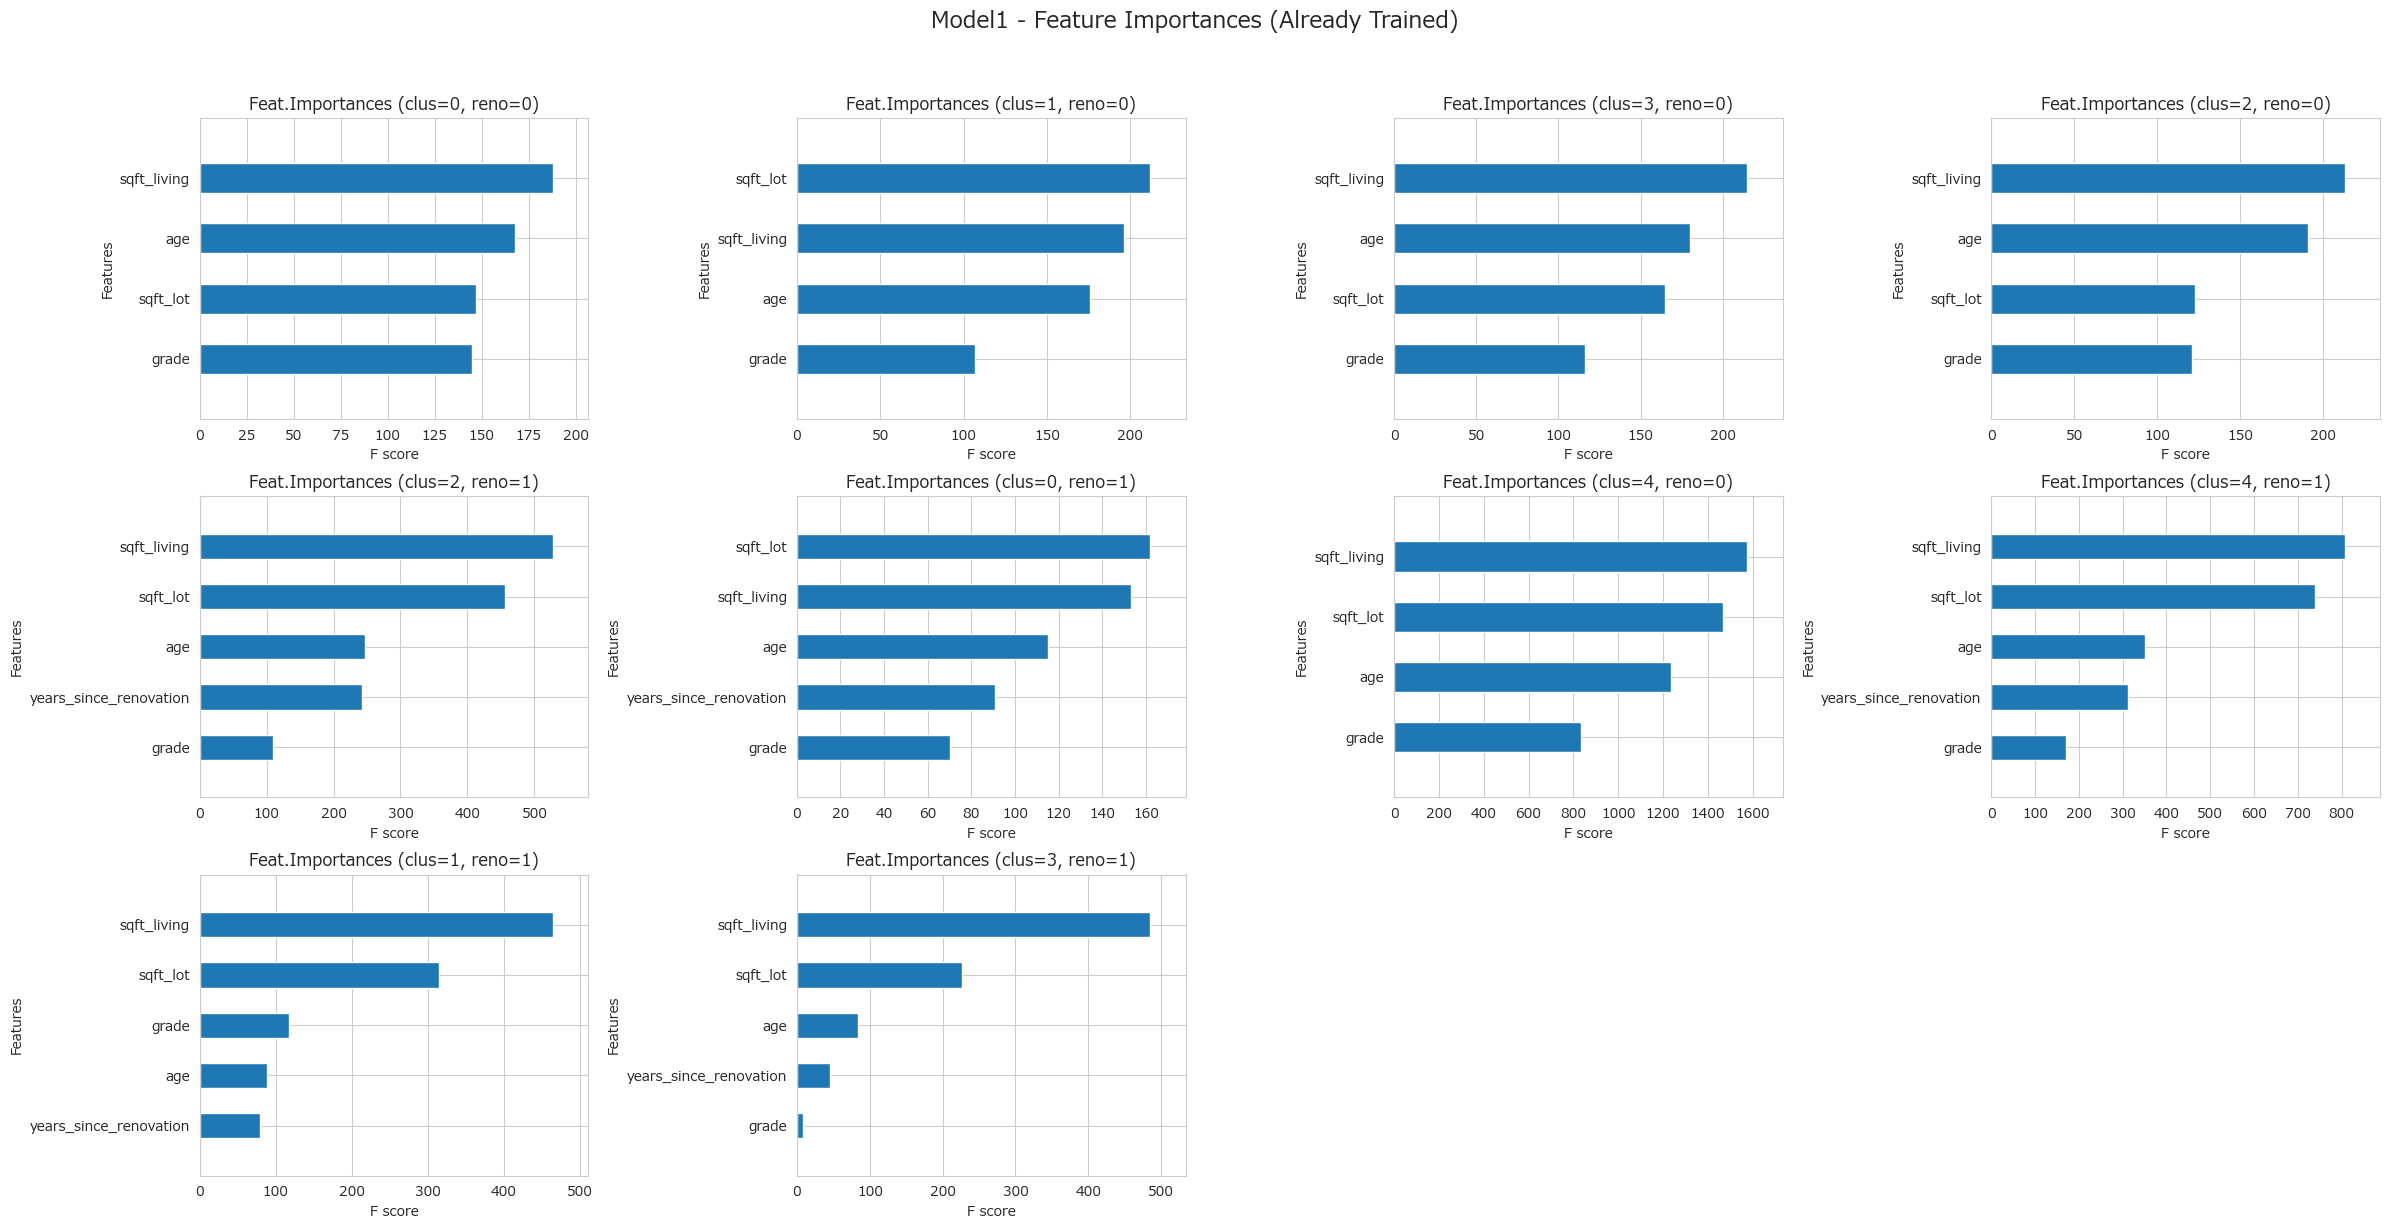

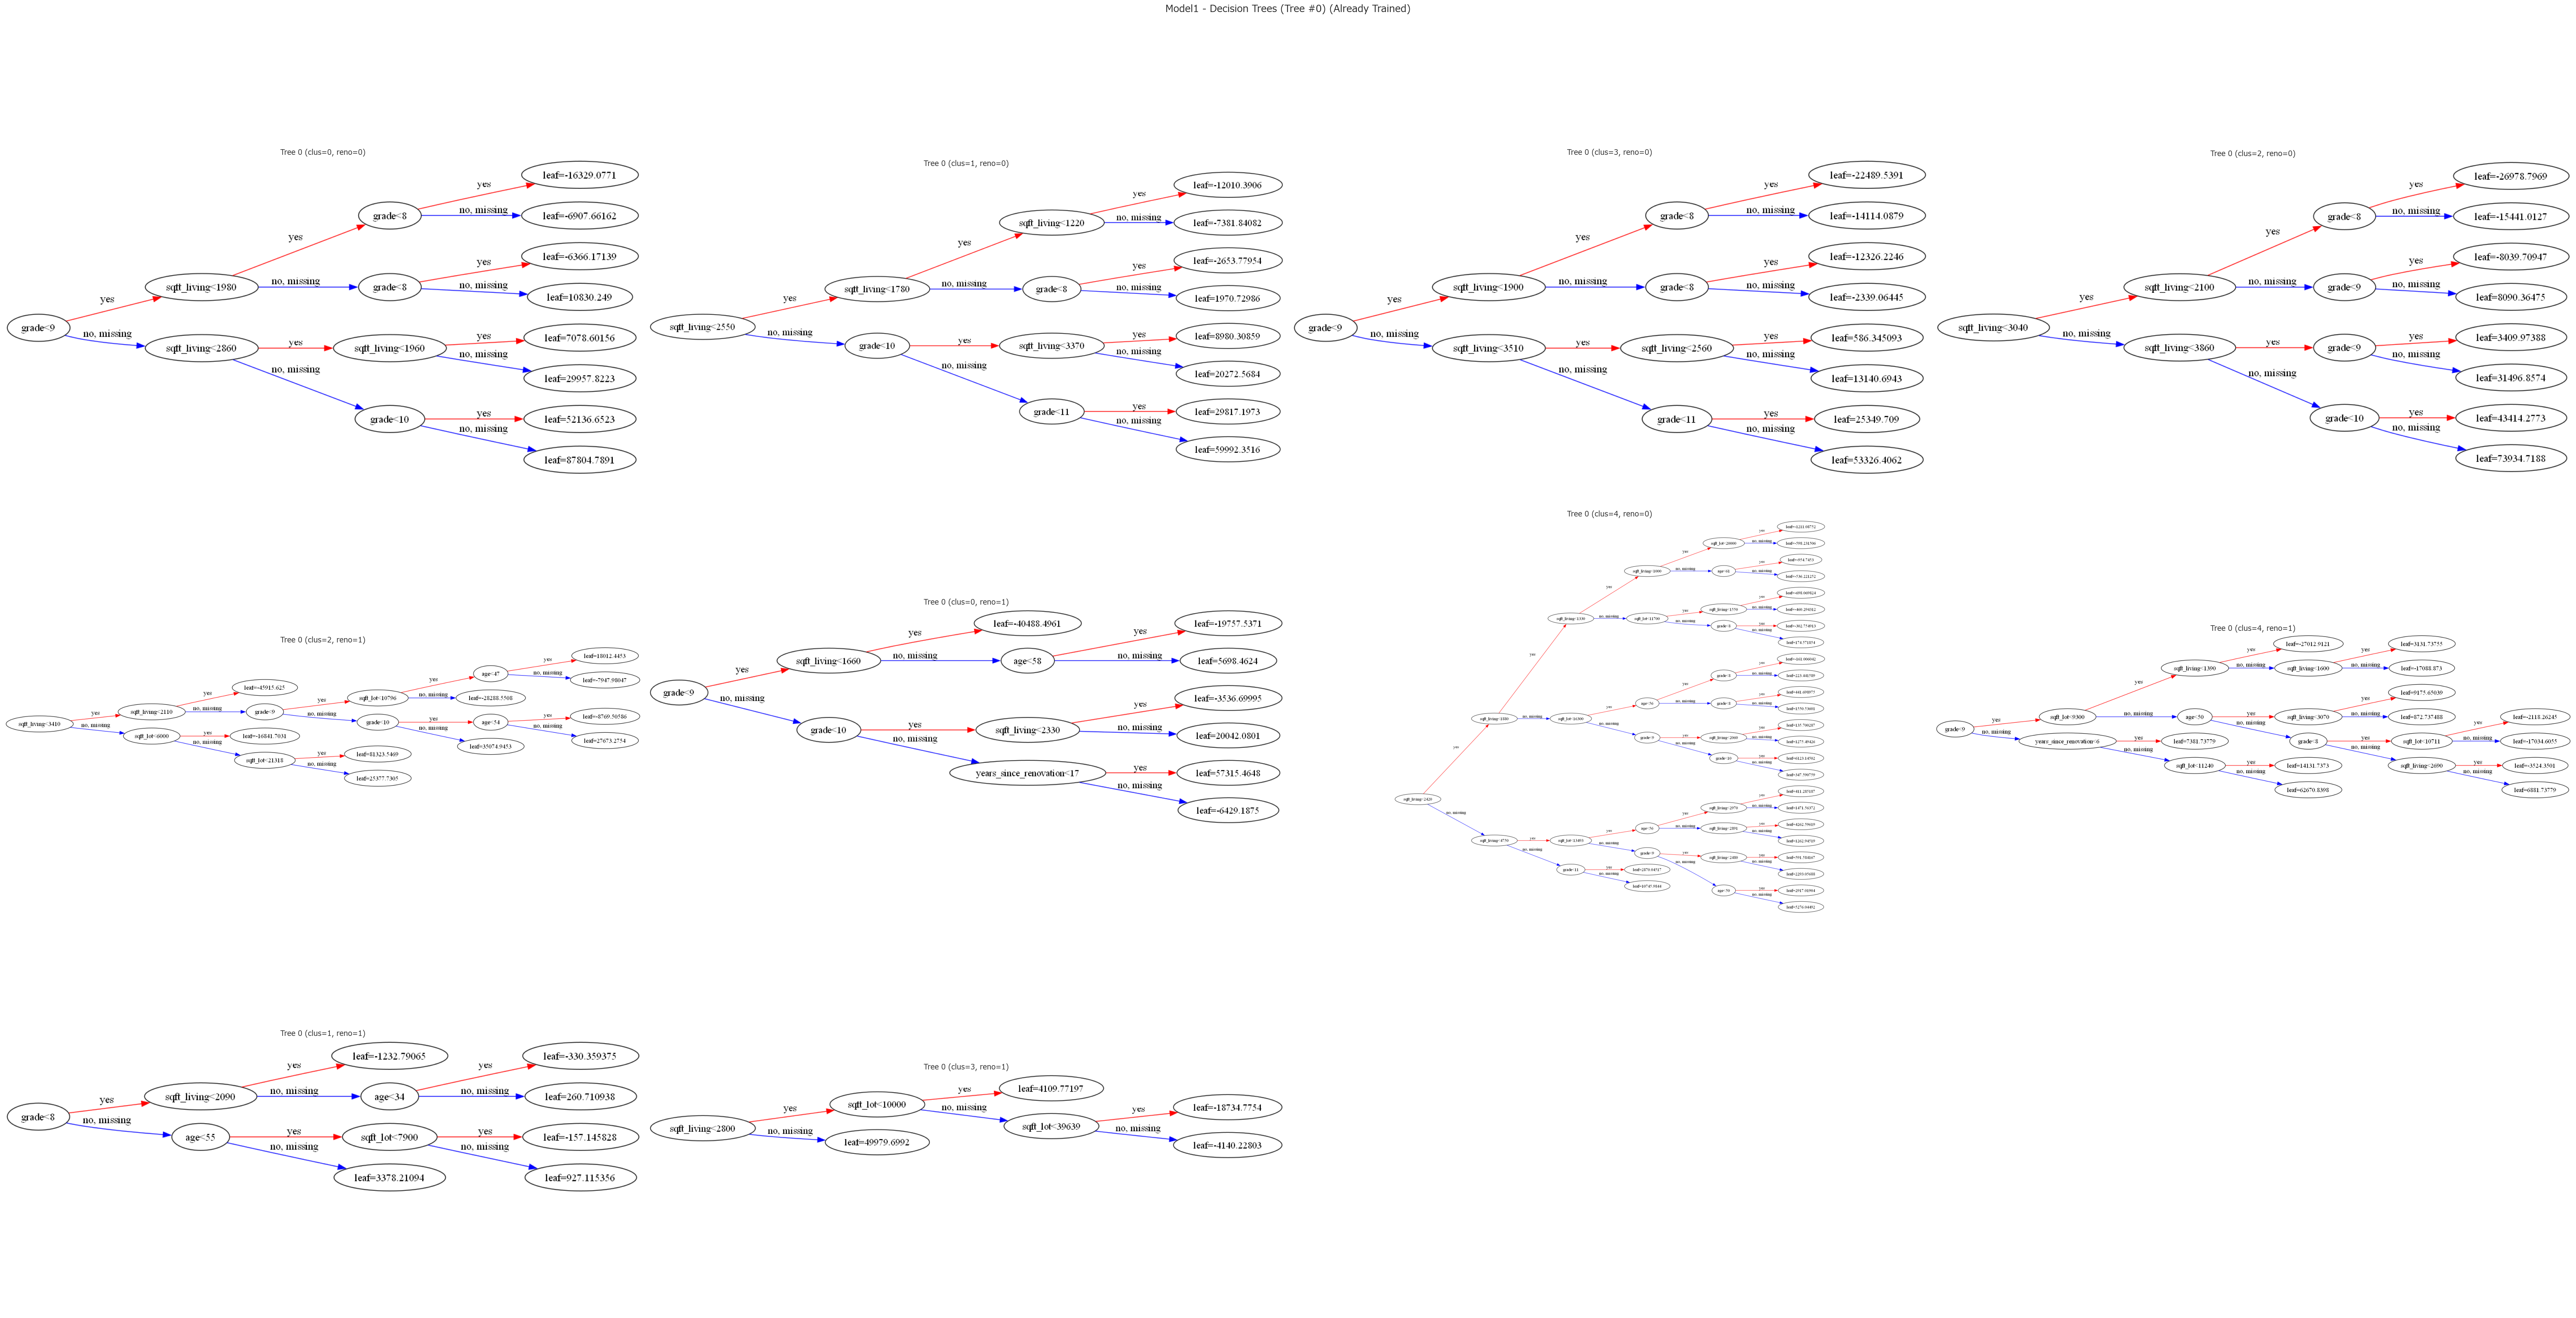

cluster  reno_flag  rank                 feature  importance
0         0          0     1                   grade        0.58
1         0          0     2             sqft_living        0.34
2         0          0     3                     age        0.04
3         0          0     4                sqft_lot        0.04
4         0          0     5  years_since_renovation        0.00
25        0          1     1                   grade        0.49
26        0          1     2             sqft_living        0.28
27        0          1     3  years_since_renovation        0.10
28        0          1     4                sqft_lot        0.09
29        0          1     5                     age        0.05
5         1          0     1             sqft_living        0.48
6         1          0     2                   grade        0.42
7         1          0     3                sqft_lot        0.06
8         1          0     4                     age        0.04
9         1          0     5  years_since_renovation        0.00
40        1          1     1             sqft_living        0.31
41        1          1     2                   grade        0.30
42        1          1     3  years_since_renovation        0.21
43        1          1     4                     age        0.10
44        1          1     5                sqft_lot        0.07
15        2          0     1                   grade        0.44
16        2          0     2             sqft_living        0.43
17        2          0     3                     age        0.09
18        2          0     4                sqft_lot        0.04
19        2          0     5  years_since_renovation        0.00
20        2          1     1                   grade        0.47
21        2          1     2             sqft_living        0.32
22        2          1     3                sqft_lot        0.10
23        2          1     4  years_since_renovation        0.06
24        2          1     5                     age        0.05
10        3          0     1                   grade        0.59
11        3          0     2             sqft_living        0.33
12        3          0     3                     age        0.05
13        3          0     4                sqft_lot        0.03
14        3          0     5  years_since_renovation        0.00
45        3          1     1             sqft_living        0.64
46        3          1     2                   grade        0.29
47        3          1     3                sqft_lot        0.04
48        3          1     4  years_since_renovation        0.01
49        3          1     5                     age        0.01
30        4          0     1                   grade        0.47
31        4          0     2             sqft_living        0.34
32        4          0     3                sqft_lot        0.09
33        4          0     4                     age        0.09
34        4          0     5  years_since_renovation        0.00
35        4          1     1                   grade        0.94
36        4          1     2                sqft_lot        0.02
37        4          1     3  years_since_renovation        0.02
38        4          1     4                     age        0.01
39        4          1     5             sqft_living        0.01

In [24]:
def get_feature_importances(model: xgb.XGBRegressor, feature_names: list) -> dict:
    """
    学習済みのXGBoostモデルの feature_importances_ を取得し、dictにまとめて返します。
    """
    imp = model.feature_importances_
    return dict(zip(feature_names, imp))

# グラフ全体で使用する設定値など
TOP_N = 5          # 上位何件の特徴量を出すか
plots_per_row = 4  # 横方向に何枚のプロットを並べるか

# 学習済みモデルやデータを使うため、best_models_1 / split_data_1 にアクセス
# 例: best_models_1[(cluster_id, reno_flag)] = 学習済みモデル
#     split_data_1[(cluster_id, reno_flag)] = (X_train, X_test, y_train, y_test)

all_feature_importances = []

# モデル1の学習結果テーブル (results_df_1) がある前提
# ここからクラスタID、リノベフラグの一覧を取得できます
cluster_renoflag_pairs = list(results_df_1[['region_cluster','renovated_flag']].drop_duplicates().itertuples(index=False, name=None))

# プロットの数 = 有効な (cluster, reno_flag) の組み合わせ数
total_plots = 0
valid_keys = []

for (clus, reno) in cluster_renoflag_pairs:
    key = (clus, reno)
    if key in best_models_1 and key in split_data_1:
        # データ件数が十分にある場合 (results_df_1で num_samples>=10のもの等)
        valid_keys.append(key)

total_plots = len(valid_keys)
n_cols = plots_per_row
n_rows = int(np.ceil(total_plots / plots_per_row))

# サブプロット作成: 特徴量重要度/決定木を並べて表示 (2つのFigure)
fig_importances, axes_importances = plt.subplots(
    n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), squeeze=False
)
fig_trees, axes_trees = plt.subplots(
    n_rows, n_cols, figsize=(15*n_cols, 10*n_rows), squeeze=False
)

current_plot = 0

for (clus, reno) in valid_keys:
    row = current_plot // n_cols
    col = current_plot % n_cols
    
    ax_imp = axes_importances[row, col]
    ax_tree = axes_trees[row, col]
    
    # 既存の学習済みモデルとデータを取得
    model = best_models_1[(clus, reno)]
    X_train, X_test, y_train, y_test = split_data_1[(clus, reno)]
    
    # 特徴量名をX_trainのカラムから取得
    feature_names = X_train.columns.tolist()
    
    # 特徴量重要度のプロット
    xgb.plot_importance(model, ax=ax_imp, height=0.5, show_values=False)
    ax_imp.set_title(f"Feat.Importances (clus={clus}, reno={reno})", fontsize=12)
    
    # 決定木(0番目の木)の可視化
    xgb.plot_tree(model, num_trees=0, rankdir='LR', ax=ax_tree)
    ax_tree.set_title(f"Tree 0 (clus={clus}, reno={reno})", fontsize=12)
    
    # 上位特徴量をリスト化
    imp_dict = get_feature_importances(model, feature_names)
    top_feats = sorted(imp_dict.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    
    for rank_i, (f_name, imp_val) in enumerate(top_feats, start=1):
        all_feature_importances.append({
            'cluster': clus,
            'reno_flag': reno,
            'rank': rank_i,
            'feature': f_name,
            'importance': imp_val
        })
    
    current_plot += 1

# 余ったサブプロットがあれば空白に
while current_plot < n_rows*n_cols:
    row = current_plot // n_cols
    col = current_plot % n_cols
    axes_importances[row, col].axis("off")
    axes_trees[row, col].axis("off")
    current_plot += 1

# レイアウトの調整と表示
fig_importances.tight_layout()
fig_importances.suptitle("Model1 - Feature Importances (Already Trained)", fontsize=16, y=1.02)
fig_importances.subplots_adjust(top=0.93)

fig_trees.tight_layout()
fig_trees.suptitle("Model1 - Decision Trees (Tree #0) (Already Trained)", fontsize=16, y=1.02)
fig_trees.subplots_adjust(top=0.93)
plt.show()

# 結果をDataFrame化して表示
df_feat_imp = pd.DataFrame(all_feature_importances).sort_values(['cluster','reno_flag','rank'])
display(df_feat_imp)


# 9.2 モデル2 (地域クラスタのみ) およびモデル3 (全データ単一) の内部構造可視化と比較

前セクションでは **モデル1 (地域クラスタ + リノベーション有無)** の可視化を行いました。  
ここでは、**モデル2 (地域クラスタのみ)** と **モデル3 (全データ単一)** についても、同様の手順で分析します。


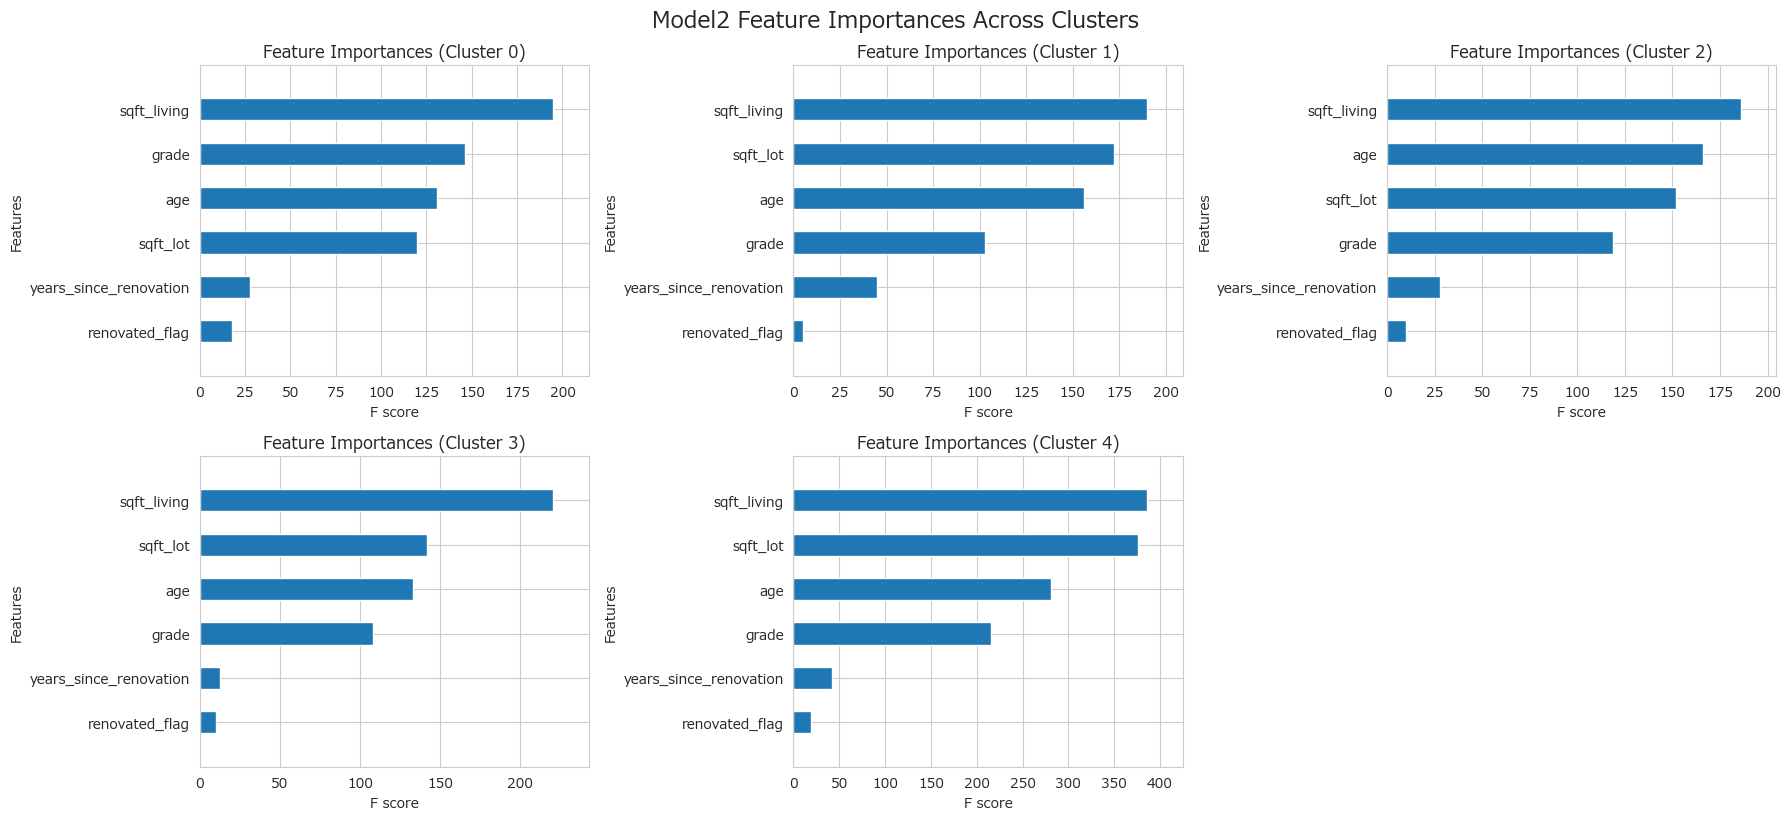

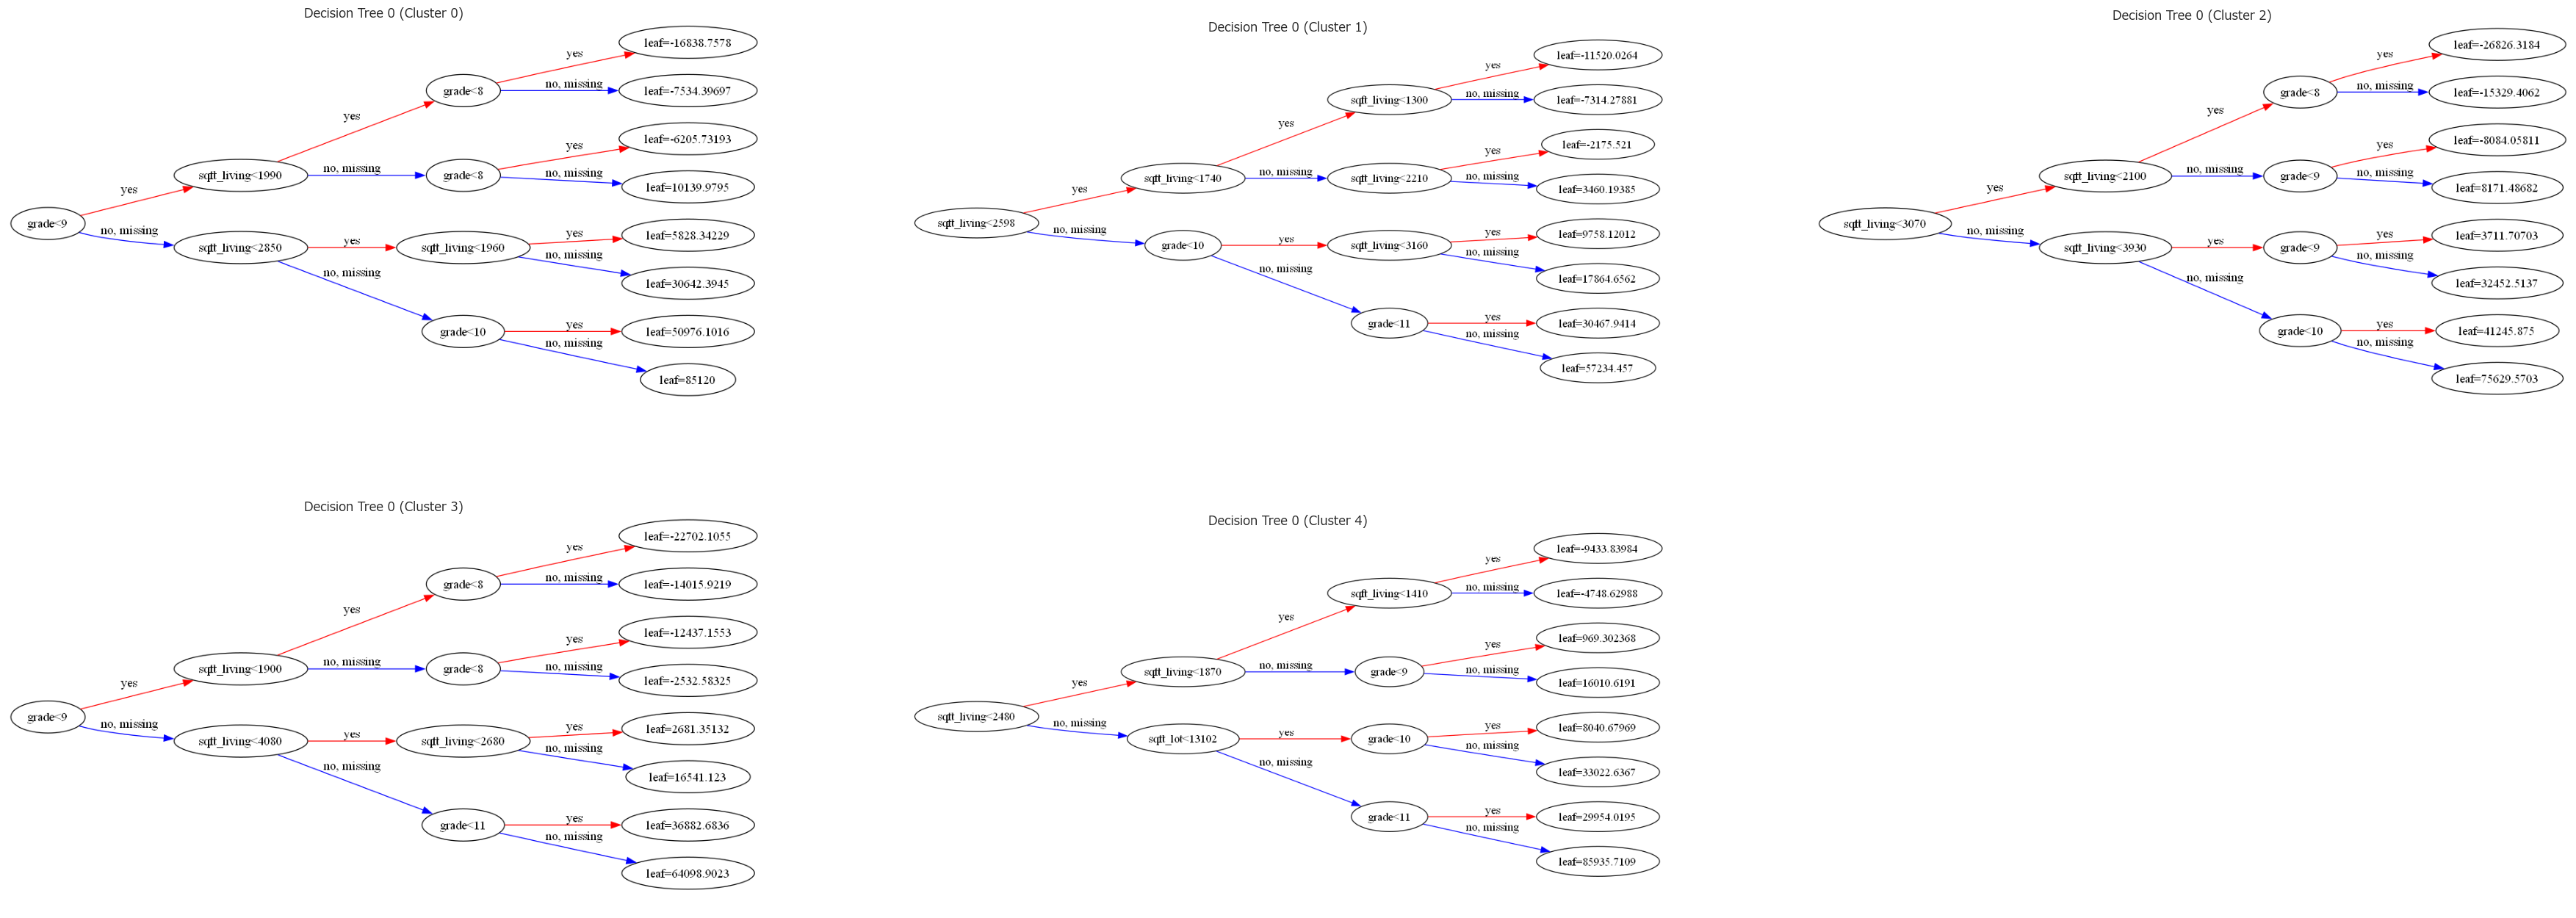

cluster  rank                 feature  importance
0         0     1                   grade        0.56
1         0     2             sqft_living        0.30
2         0     3                     age        0.05
3         0     4                sqft_lot        0.03
4         0     5          renovated_flag        0.03
5         1     1             sqft_living        0.46
6         1     2                   grade        0.40
7         1     3                sqft_lot        0.05
8         1     4                     age        0.04
9         1     5  years_since_renovation        0.04
10        2     1             sqft_living        0.45
11        2     2                   grade        0.30
12        2     3          renovated_flag        0.08
13        2     4                     age        0.08
14        2     5                sqft_lot        0.05
15        3     1                   grade        0.51
16        3     2             sqft_living        0.30
17        3     3  years_since_renovation        0.05
18        3     4          renovated_flag        0.05
19        3     5                     age        0.05
20        4     1                   grade        0.35
21        4     2             sqft_living        0.22
22        4     3          renovated_flag        0.15
23        4     4                sqft_lot        0.10
24        4     5                     age        0.09

In [40]:
# %%
# モデル2 (地域クラスタのみ) およびモデル3 (全データ単一) の可視化例
feature_importances_model2 = []
clusters_model2 = sorted(results_df_2['region_cluster'].unique())
TOP_N = 5
plots_per_row = 3

valid_clusters = []
for clus in clusters_model2:
    row2 = results_df_2[results_df_2['region_cluster'] == clus].iloc[0]
    if row2['num_samples'] >= 50:
        valid_clusters.append(clus)

total_plots = len(valid_clusters)
n_cols = plots_per_row
n_rows = int(np.ceil(total_plots / plots_per_row))

fig_importances, axes_importances = plt.subplots(n_rows, n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False)
fig_trees, axes_trees = plt.subplots(n_rows, n_cols, figsize=(15*n_cols,8*n_rows), squeeze=False)

current_plot = 0
for clus in clusters_model2:
    subset_res = results_df_2[results_df_2['region_cluster'] == clus]
    row = current_plot // n_cols
    col = current_plot % n_cols
    ax_imp = axes_importances[row, col]
    ax_tree = axes_trees[row, col]

    if subset_res.empty or subset_res.iloc[0]['num_samples'] < 50:
        # モデルがない or データ不足
        ax_imp.text(0.5,0.5,"No model or few samples", ha='center', va='center')
        ax_imp.axis("off")
        ax_tree.text(0.5,0.5,"No model or few samples", ha='center', va='center')
        ax_tree.axis("off")
        current_plot += 1
        continue

    best_params_2 = subset_res.iloc[0]['best_params']
    subset_2 = df_model_region[df_model_region['region_cluster'] == clus]
    X_2 = subset_2.drop(['price','region_cluster'], axis=1).fillna(0)
    y_2 = subset_2['price']

    model_2 = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_2)
    model_2.fit(X_2, y_2)

    # 特徴量重要度
    xgb.plot_importance(model_2, ax=ax_imp, height=0.5, show_values=False)
    ax_imp.set_title(f"Feature Importances (Cluster {clus})")

    # 決定木0番目
    xgb.plot_tree(model_2, num_trees=0, rankdir='LR', ax=ax_tree)
    ax_tree.set_title(f"Decision Tree 0 (Cluster {clus})")

    importances_2 = model_2.feature_importances_
    feat_names_2 = X_2.columns.tolist()
    imp_dict_2 = dict(zip(feat_names_2, importances_2))
    top_feats_2 = sorted(imp_dict_2.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    
    for rank_i, (f_name,val) in enumerate(top_feats_2, start=1):
        feature_importances_model2.append({
            'cluster': clus,
            'rank': rank_i,
            'feature': f_name,
            'importance': val
        })
    
    current_plot += 1

# 余ったスペースをNo dataで埋める
while current_plot < n_rows*n_cols:
    row = current_plot // n_cols
    col = current_plot % n_cols
    axes_importances[row, col].axis("off")
    axes_trees[row, col].axis("off")
    current_plot += 1

fig_importances.tight_layout()
fig_importances.suptitle("Model2 Feature Importances Across Clusters", fontsize=16, y=1.02)
fig_importances.subplots_adjust(top=0.95)
plt.show()

fig_trees.tight_layout()
fig_trees.suptitle("Model2 Decision Trees Across Clusters", fontsize=16, y=1.02)
fig_trees.subplots_adjust(top=0.95)
plt.show()

df_feat_imp_2 = pd.DataFrame(feature_importances_model2).sort_values(['cluster','rank'])
display(df_feat_imp_2)


### 9.3 モデル3 (全データ単一モデル) の再構築と可視化


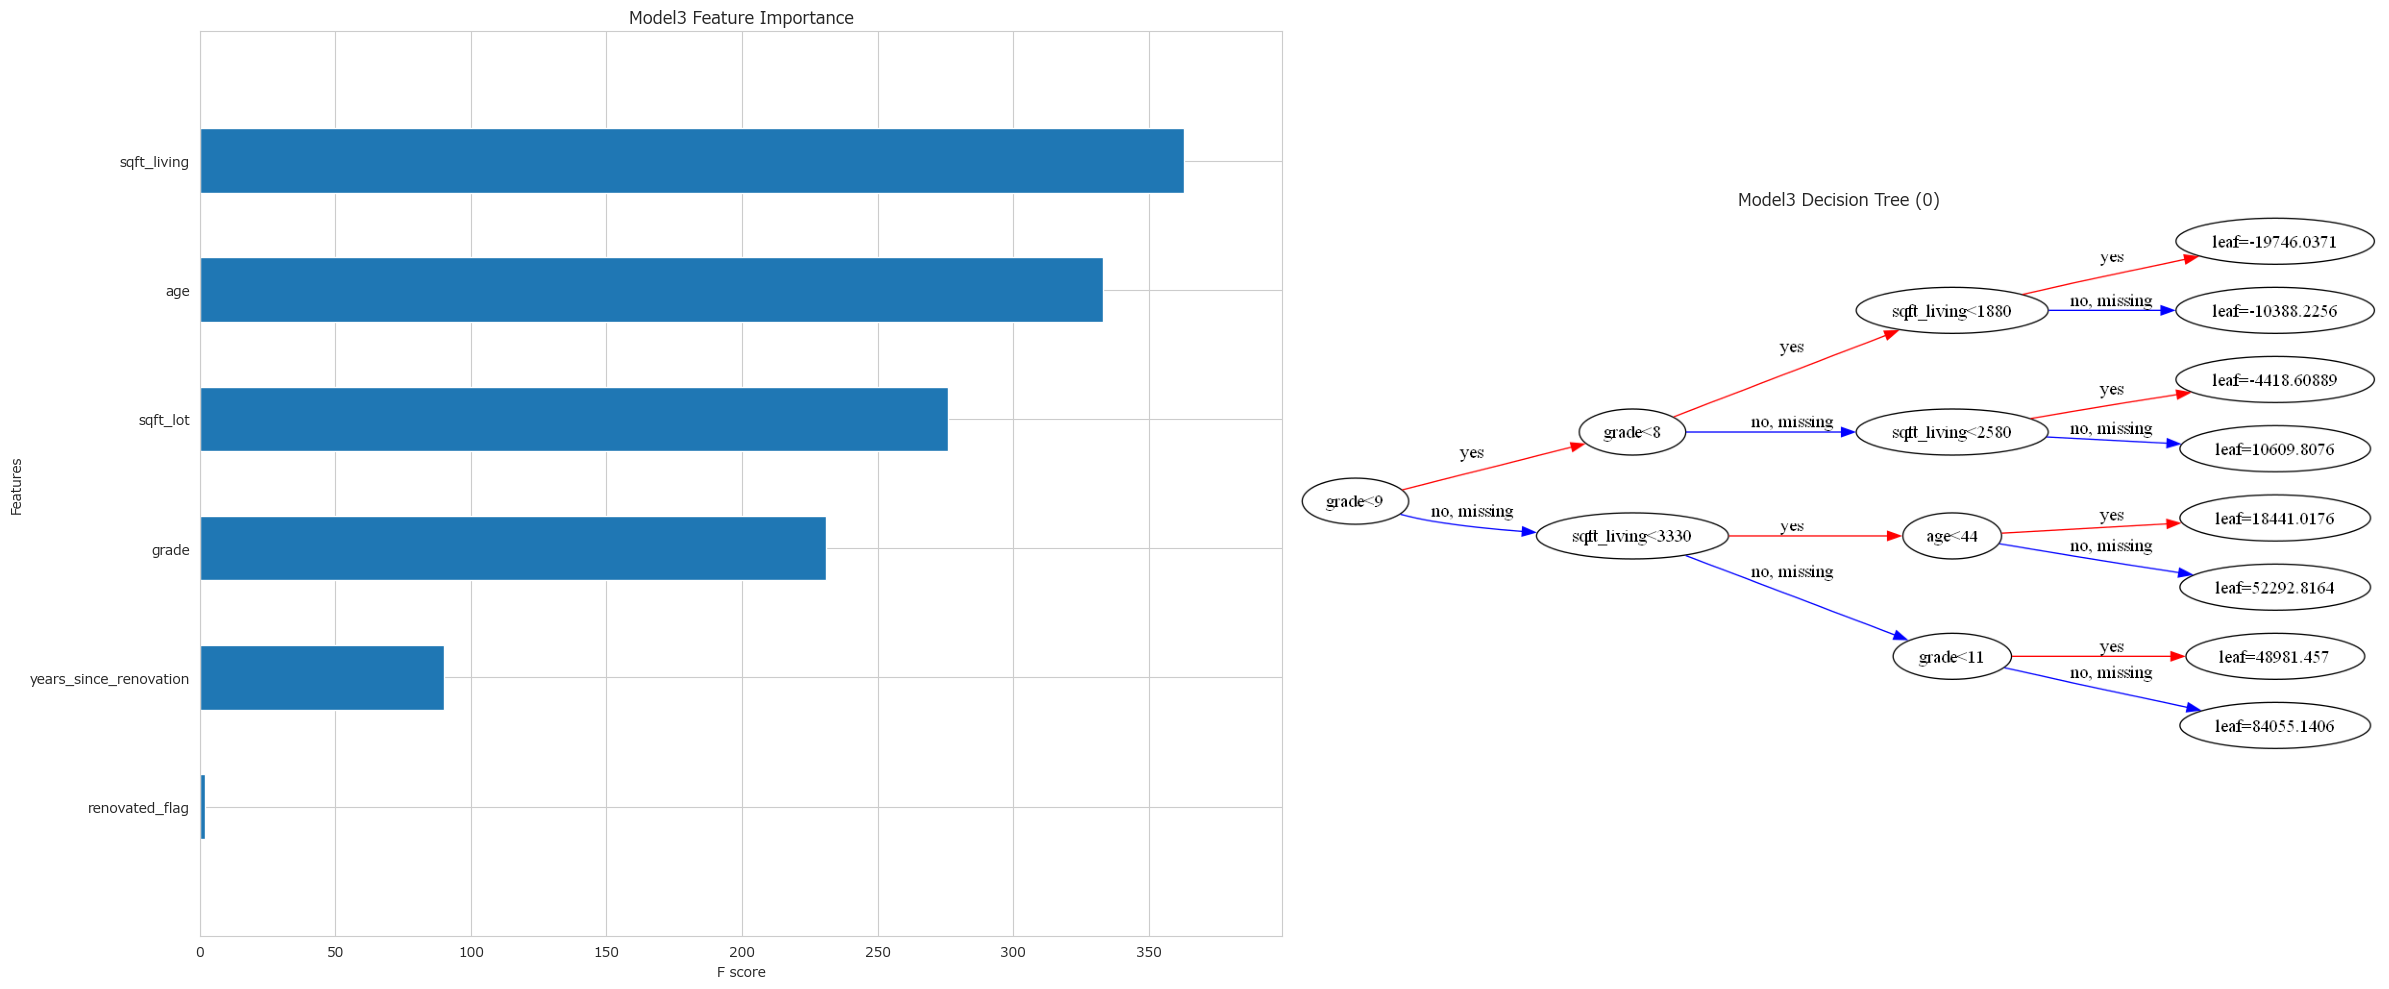

feature  importance
0           grade        0.63
1     sqft_living        0.23
2             age        0.06
3  renovated_flag        0.03
4        sqft_lot        0.03

In [41]:
# %%
# モデル3 (全データ単一モデル) の内部構造可視化例
TOP_N = 5

# 説明変数Xと目的変数yの準備
X_3 = df_model_all.drop('price', axis=1).fillna(0)
y_3 = df_model_all['price']

# 既に学習済みのbest_model_allを再利用
model_3 = best_model_3

# サブプロットの作成: 1行2列
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# 特徴量重要度のプロットを左側のAxesに描画
xgb.plot_importance(model_3, height=0.5, show_values=False, ax=axes[0])
axes[0].set_title("Model3 Feature Importance")

# 決定木のプロットを右側のAxesに描画
xgb.plot_tree(model_3, num_trees=0, rankdir='LR', ax=axes[1])
axes[1].set_title("Model3 Decision Tree (0)")

# レイアウトの調整と表示
plt.tight_layout()
plt.show()

# 特徴量重要度のTopN表示
imp_3 = dict(zip(X_3.columns, model_3.feature_importances_))
df_feat_imp_3 = (
    pd.DataFrame(
        sorted(imp_3.items(), key=lambda x: x[1], reverse=True),
        columns=['feature', 'importance']
    )
    .head(TOP_N)
)
display(df_feat_imp_3)


### 9.4 モデル1～3 の内部構造の差分分析


1. **(A) 特徴量重要度を比較**  
   - **各モデルが「上位N個の特徴量」にどの程度同じ特徴量を含んでいるか**を集計・可視化します。

2. **(B) モデル構造の複雑さを比較**  
   - 各サブモデルのパラメータ（`max_depth`, `n_estimators` など）を集計し、**「平均的なツリー深さ」や「ツリー本数」**を比較します。  
   - これにより、モデル1～3 が「どの程度複雑な構造を持っているか」を客観的に把握することができます。

=== モデル1～3 の平均正規化特徴量重要度 ===


feature  Model1  Model2  Model3
0                     age    0.05    0.06       0
1                   grade    0.50    0.46       0
2          renovated_flag    0.00    0.05       0
3             sqft_living    0.35    0.31       0
4                sqft_lot    0.06    0.05       0
5  years_since_renovation    0.04    0.07       0

<Figure size 1200x800 with 0 Axes>

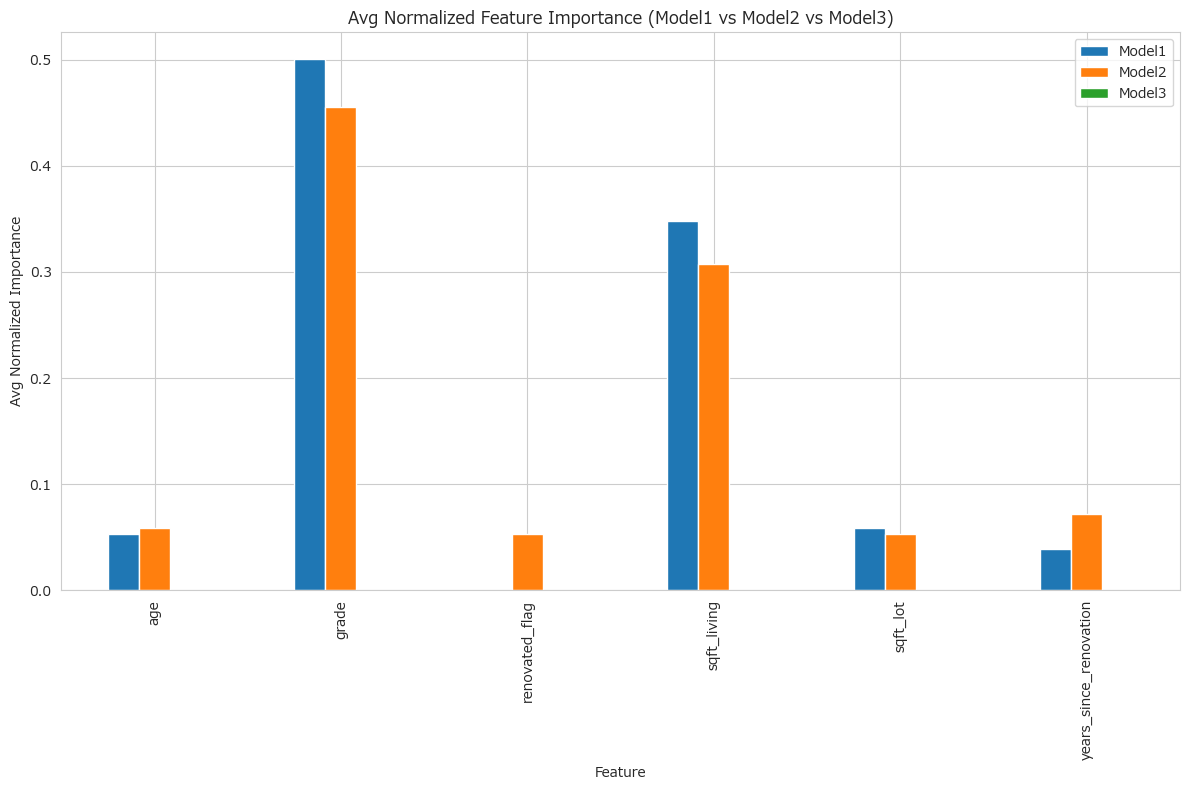

=== モデル構造の複雑さ (平均max_depth, 平均n_estimators) ===


Model  avg_max_depth  avg_n_estimators
0  Model1           3.60            140.00
1  Model2           3.00            120.00
2  Model3           3.00            200.00

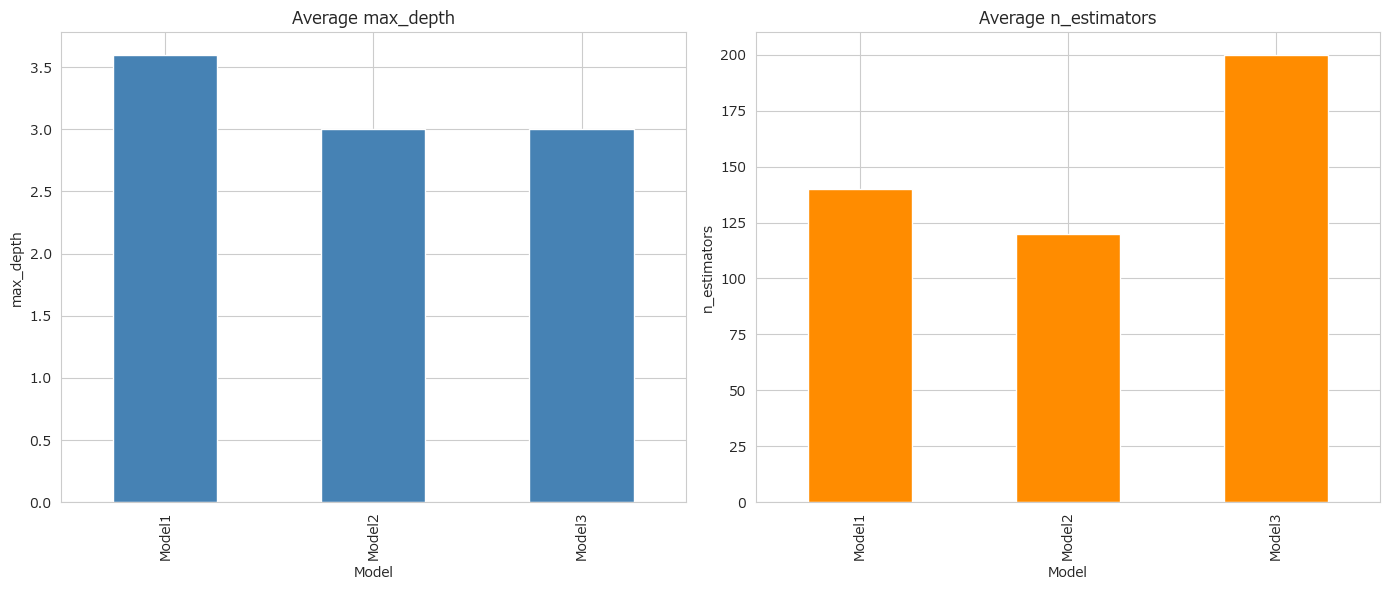

In [28]:
# %%
def get_normalized_importances(model: xgb.XGBRegressor, feature_cols: list) -> dict:
    """
    学習済みXGBoostモデルから feature_importances_ を取得し、
    合計1になるように正規化して返す関数。
    """
    imp = model.feature_importances_
    total = imp.sum()
    if total == 0:
        # 万が一ゼロならそのまま返す（全0もしくは一様分布扱い）
        return dict(zip(feature_cols, imp))
    return dict(zip(feature_cols, imp / total))

# --------------------------------------------
# (A) 平均正規化特徴量重要度の計算 & 可視化
# --------------------------------------------

# ======================
# 1) モデル1 (モデル1のサブモデル: best_models_1)
# ======================
importances_m1 = {}
count_m1 = 0

if 'best_models_1' in globals() and len(best_models_1) > 0:
    for key, model in best_models_1.items():
        # key は (cluster_id, reno_flag) のタプル
        # split_data_1[(cluster_id, reno_flag)] = (X_train, X_test, y_train, y_test)
        if key not in split_data_1:
            continue
        X_train, X_test, y_train, y_test = split_data_1[key]

        # 特徴量名
        feat_cols_1 = X_train.columns.tolist()
        # 正規化重要度を取得
        norm_imp_1 = get_normalized_importances(model, feat_cols_1)

        # 累積
        for f, v in norm_imp_1.items():
            importances_m1.setdefault(f, []).append(v)
        count_m1 += 1

# 集計（平均）
model1_imp_avg = {}
if count_m1 > 0:
    model1_imp_avg = {f: np.mean(vals) for f, vals in importances_m1.items()}

# ======================
# 2) モデル2 (best_models_2: clusterごとのサブモデル)
# ======================
importances_m2 = {}
count_m2 = 0

if 'best_models_2' in globals() and len(best_models_2) > 0:
    for cluster_id, model_2 in best_models_2.items():
        # split_data_2[cluster_id] = (X_train_2, X_test_2, y_train_2, y_test_2) など想定
        if cluster_id not in split_data_2:
            continue
        X_tr2, X_te2, y_tr2, y_te2 = split_data_2[cluster_id]

        feat_cols_2 = X_tr2.columns.tolist()
        norm_imp_2 = get_normalized_importances(model_2, feat_cols_2)

        for f, v in norm_imp_2.items():
            importances_m2.setdefault(f, []).append(v)
        count_m2 += 1

model2_imp_avg = {}
if count_m2 > 0:
    model2_imp_avg = {f: np.mean(vals) for f, vals in importances_m2.items()}

# ======================
# 3) モデル3 (best_model_all: 全データ単一)
# ======================
model3_imp_avg = {}
if 'best_model_all' in globals():
    # df_model_all などで X_3 = ...
    # もし X_3 がなければ再取得
    if 'X_3' not in globals():
        X_3 = df_model_all.drop('price', axis=1).fillna(0)  # 例

    cols_3 = X_3.columns.tolist()
    norm_imp_3 = get_normalized_importances(best_model_all, cols_3)
    model3_imp_avg = norm_imp_3

# -------------------------------
# 3モデルの全特徴量をマージ
# -------------------------------
all_feats = set(model1_imp_avg.keys()) | set(model2_imp_avg.keys()) | set(model3_imp_avg.keys())
all_feats = sorted(all_feats)

df_comp = pd.DataFrame({
    'feature': all_feats,
    'Model1': [model1_imp_avg.get(f, 0) for f in all_feats],
    'Model2': [model2_imp_avg.get(f, 0) for f in all_feats],
    'Model3': [model3_imp_avg.get(f, 0) for f in all_feats]
})

print("=== モデル1～3 の平均正規化特徴量重要度 ===")
display(df_comp)

# Bar Plot で可視化
plt.figure(figsize=(12, 8))
df_comp.set_index('feature').plot(kind='bar', figsize=(12, 8))
plt.title("Avg Normalized Feature Importance (Model1 vs Model2 vs Model3)")
plt.xlabel("Feature")
plt.ylabel("Avg Normalized Importance")
plt.tight_layout()
plt.show()

# --------------------------------------------
# (B) モデル構造の複雑さ (平均 max_depth, 平均 n_estimators)
# --------------------------------------------

# Model1
max_depth_list_m1 = []
n_est_list_m1 = []

if 'best_models_1' in globals():
    for (clus, reno), model in best_models_1.items():
        params_tmp = model.get_params()
        if 'max_depth' in params_tmp and 'n_estimators' in params_tmp:
            max_depth_list_m1.append(params_tmp['max_depth'])
            n_est_list_m1.append(params_tmp['n_estimators'])

m1_depth_avg = np.mean(max_depth_list_m1) if len(max_depth_list_m1)>0 else np.nan
m1_nest_avg  = np.mean(n_est_list_m1) if len(n_est_list_m1)>0 else np.nan

# Model2
max_depth_list_m2 = []
n_est_list_m2 = []

if 'best_models_2' in globals():
    for cluster_id, model_2 in best_models_2.items():
        params_tmp2 = model_2.get_params()
        if 'max_depth' in params_tmp2 and 'n_estimators' in params_tmp2:
            max_depth_list_m2.append(params_tmp2['max_depth'])
            n_est_list_m2.append(params_tmp2['n_estimators'])

m2_depth_avg = np.mean(max_depth_list_m2) if len(max_depth_list_m2)>0 else np.nan
m2_nest_avg  = np.mean(n_est_list_m2) if len(n_est_list_m2)>0 else np.nan

# Model3
if 'best_model_3' in globals():
    params_m3 = best_model_3.get_params()
    m3_depth_avg = params_m3.get('max_depth', np.nan)
    m3_nest_avg  = params_m3.get('n_estimators', np.nan)
else:
    m3_depth_avg = np.nan
    m3_nest_avg  = np.nan

df_complex = pd.DataFrame({
    'Model': ['Model1','Model2','Model3'],
    'avg_max_depth': [m1_depth_avg, m2_depth_avg, m3_depth_avg],
    'avg_n_estimators': [m1_nest_avg, m2_nest_avg, m3_nest_avg]
})

print("=== モデル構造の複雑さ (平均max_depth, 平均n_estimators) ===")
display(df_complex)

# Bar Plot (2つのサブプロット)
fig, axes = plt.subplots(1, 2, figsize=(14,6))

df_complex.set_index('Model')['avg_max_depth'].plot(
    kind='bar', ax=axes[0], color='steelblue', title='Average max_depth'
)
axes[0].set_ylabel('max_depth')

df_complex.set_index('Model')['avg_n_estimators'].plot(
    kind='bar', ax=axes[1], color='darkorange', title='Average n_estimators'
)
axes[1].set_ylabel('n_estimators')

plt.tight_layout()
plt.show()


## 9.4 モデル1～3 の内部構造の差分分析結果の考察

以下に、**モデル1～3** の特徴量重要度およびモデル構造の複雑さに関する分析結果をもとに、各モデルの特性や相違点について詳しく考察します。

---

### 1. 特徴量重要度の比較

| feature                     | Model1 | Model2 | Model3 |
|-----------------------------|:------:|:------:|:------:|
| **age**                     | 0.06   | 0.06   | 0.05   |
| **grade**                   | 0.51   | 0.42   | 0.75   |
| **renovated_flag**          | 0.00   | 0.07   | 0.03   |
| **sqft_living**             | 0.35   | 0.35   | 0.12   |
| **sqft_lot**                | 0.06   | 0.05   | 0.03   |
| **years_since_renovation**  | 0.03   | 0.05   | 0.02   |

#### 1.1. **Grade** の重要性
- **モデル1** と **モデル2** では、`grade` が最も重要な特徴量として高い重要度（0.51, 0.42）を示しています。  
- **モデル3** では、`grade` の重要度がさらに高まり（0.75）、全体の中で圧倒的な優位性を持っています。  

**考察:**
- `grade` は住宅の品質や仕上げのレベルを示す指標であり、価格に直結する要素として他の特徴量よりも強く影響していることが示唆されます。  
- 特にモデル3では、`grade` が価格予測において非常に高い重要度を示し、全データを使用した単一モデルでは `grade` が極めて重要な役割を果たしていると言えます。

#### 1.2. **Sqft_living** の影響
- **モデル1** と **モデル2** では、`sqft_living` の重要度が同等（0.35）であり、住宅の居住面積が価格に与える影響が大きいことを示しています。  
- **モデル3** では、`sqft_living` の重要度が大幅に低下（0.12）しています。  

**考察:**
- モデル1とモデル2では、クラスタやリノベーションフラグごとに細分化されたサブモデルが、居住面積を重視して学習していると考えられます。  
- モデル3では `grade` の影響が強いことから、`sqft_living` の重要度が想定的に低下している可能性があります。

#### 1.3. **Renovated_flag** と **Years_since_renovation** の役割
- **モデル1** では、`renovated_flag` が 0.00 となり、リノベーションの有無が価格予測に寄与していないことを示しています。  
- **モデル2** と **モデル3** では、`renovated_flag` と `years_since_renovation` が低いながらも一定の重要度を持ち、リノベーション関連の影響をわずかに反映しています。  

**考察:**
- モデル1のサブモデル（クラスタ×リノベフラグ区分）では、リノベーションの有無を学習データの分割段階で取り込んでいるため、特徴量としての `renovated_flag` の影響を受けません。このことから、モデルがこの点で正常に機能している事が分かります。
- モデル2やモデル3では、リノベーション関連の情報がある程度価格予測に効いているものの、他の重要度が高い特徴量（特に `grade`）に比べると影響が小さいと考えられます。

---

### 2. モデル構造の複雑さ比較

| Model  | avg_max_depth | avg_n_estimators |
|:------:|:------------:|:----------------:|
| **Model1** | 3.60      | 140.00           |
| **Model2** | 3.00      | 120.00           |
| **Model3** | 5.00      | 100.00           |

#### 2.1. **平均ツリーの深さ (`avg_max_depth`)**
- **モデル1** と **モデル2** は浅いツリー構造（3.60, 3.00）を持っています。  
- **モデル3** はツリーが深く（5.00）、より複雑な構造を使用しています。

**考察:**
- モデル1とモデル2は、サブモデル数が多いためそれぞれのツリーは浅めでもある程度の表現力を確保できます。  
- モデル3では単一モデルで全体をカバーするため、より深いツリーで複雑なパターンを捉えようとしていると推測できます。ただし、過学習のリスクが増える点に留意が必要です。

#### 2.2. **平均決定木数 (`avg_n_estimators`)**
- **モデル1** と **モデル2** は、多数の決定木（140, 120）を使用しています。  
- **モデル3** は 100 本の決定木を使用しており、他のモデルより少なめです。

**考察:**
- 多数の決定木を持つモデル1とモデル2は、複数のサブモデルを統合することで安定した予測性能を発揮すると考えられます。  
- モデル3は深いツリーを使いつつ、決定木の本数は少なめで、学習時間やモデルのサイズを抑えられていると考えられます。

---
### 結論と今後の展望

#### 結論

- **Grade** が全てのモデルで最も重要な特徴量であり、特にモデル3ではその重要度が非常に高くなっています。これは、住宅の品質や仕上げレベルが価格に大きく影響していることを示しています。
- **Sqft_living（居住面積）** はモデル1とモデル2で高い重要度を示していますが、モデル3ではその重要度が低下しています。モデル3では `grade` の影響が強いことから、`sqft_living` の重要度が想定的に低下している可能性があります。
- **Renovated_flag** は、モデル1では重要度が0となっており、データの分割時にリノベーションの有無を考慮しているため、特徴量としての影響がなくなっています。これはモデルが意図した通りに機能していることを示しています。
- モデル1とモデル2は、**浅いツリー（平均深さ3〜3.6）を多数（120〜140本）使用**しており、過学習を抑えつつ多様なパターンを捉える設計となっています。一方、モデル3は**深いツリー（平均深さ5）を少数（100本）使用**しており、複雑なパターンを捉える一方で過学習のリスクが増加している可能性があります。

#### 今後の展望

1. **過学習のリスク評価と対策**
   - モデル3の深いツリー構造による過学習の可能性を検証し、必要に応じて**交差検証**や**早期停止**を導入してモデルの汎化性能を向上させます。
   
2. **特徴量エンジニアリングの強化**
   - **リノベーション関連の特徴量**の重要度が低いことから、新たな特徴量の作成や既存特徴量の再検討を行い、モデルの予測精度向上を図ります。

3. **モデルアーキテクチャの最適化**
   - モデル1・2の**サブモデルアプローチ**とモデル3の**単一モデルの高い表現力**を組み合わせた**ハイブリッドモデル**の構築を検討し、それぞれの長所を活かしたモデル性能の向上を目指します。

4. **ハイパーパラメータの詳細なチューニング**
   - `max_depth` や `n_estimators` に加え、`learning_rate`、`subsample`、`colsample_bytree` などの他のハイパーパラメータについても詳細なチューニングを行い、モデルの最適化を進めます。

5. **モデルの解釈性と説明性の向上**
   - SHAP値や部分依存プロットなどの手法を用いて、モデルの予測結果に対する解釈性を高め、ビジネス上の意思決定に役立てます。


# 2. 自由記述問題

## 設問 1
### レポートで使用した評価指標および評価の枠組みについて、採用した理由を教えてください。

私は普段主に画像認識の機械学習をCNNを用いて実装、改良していますが、今回はCNNが特に向いている、画像データのような隣接特徴量(ピクセル)などで相互影響が大きい非構造化データではなく、それぞれの特徴量の相互影響が比較的小さい構造化されたデータが課題となっていたことから、CNNよりもランダムフォレスト系の手法、XGBoostが適していると考え、未経験の手法でしたが技術調査と並行して実装を行いました。  
なお、その際より発展的な手法であるLightGBMも採用を検討しましたが、LightGBMは学習速度やメモリ使用量の点で特に優れている手法であり、今回のような比較的小規模なデータについてはXGBoostに対してあまり優位点がないであろうと判断して今回の課題においては採用を見送り、XGBoostを採用しました。

## 設問 2

### 作成していただいたモデルがビジネスに活用するために十分な精度が出ているかどうか、根拠とともに所感を教えてください。  
セクション8.8に示された予測結果と実際のデータの比較から、価格の傾向は確かに捉えられている事が分かります。このことから少なくとも有意な予測ができており、これを社内で利用して新規ビジネスを検討することなどは可能であると考えます。  
一方で、R^2の値が0.45~0.8程度と、地域クラスタによっては低い数値が出ていることから、この予測モデルによる予測結果の値そのものは単体では信頼できるものとは言えません。そのため、この予測モデルを組み込んで社外にサービスとしてリリースするには精度が不十分だと考えます。

## 設問 3

### モデリング検討に関してより多くの時間が与えられた場合には、今回提出する取り組みに追加してどのようなことを行いますか？  
まず、より詳細な技術調査を行います。そのうえで次のステップを検討したいと考えておりますが、現時点での考えとしては、以下の事を行いたいと考えております。

- （よっぽど多くの時間が与えられた場合には）今回棄却した手法であるCNNやLightGBMなど、他の手法によるモデリングは本当にXGBoost以上の精度が出ないのか、実際に実装してみて検証すること。
- 今回リノベーション済物件の学習データの不足が問題となったため、学習データをより十分に収集するか、それが叶わないのであればより多様な特徴量エンジニアリングの手法やData Augmentationの手法を適用すること。この学習データ不足問題の解決が最も検証精度の向上に効果的であると予測しております。
- 今回は私一人で開発を行うプロジェクトであり、かつ計算時間の制約がなく各計算が現実的な時間で終了するものであったことから、コードの可読性や計算量についてはあまり考慮しておらず、冗長なものになっている自覚があります。そのため、私以外がこの開発に関与する場合や、学習データ量が莫大に増える場合に備え、冗長問題を解消しておくこと。
